# Full Forex EURUSD environment RL training and hyperparameter tuning

In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.abspath(""), os.pardir)))
sys.path.insert(0, os.path.abspath(os.path.join(os.path.abspath(""), os.pardir, 'rl-baselines3-zoo')))

In [2]:
import gym
import joblib
import rl_trading
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import tqdm
from datetime import datetime, timedelta
from optuna.visualization import plot_optimization_history, plot_param_importances
from gym.envs.registration import register, make
from sb3_contrib import RecurrentPPO
from stable_baselines3 import DQN, A2C, PPO
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.common.env_util import make_vec_env
from rl_zoo3.train import train
from rl_zoo3.plots.all_plots import all_plots
from rl_zoo3.plots.plot_from_file import plot_from_file
from rl_zoo3.plots.plot_train import plot_train
from rl_zoo3.utils import get_model_path
from rl_trading.data import (
    FOREX_PAIRS,
    ForexDataSource,
    ForexFeEngStrategy,
    load_processed_forex_data,
    engineer_forex_features
)
from rl_trading.environments import (
    Actions,
    ForexEnvBasic,
    ForexMarketOrderStrategyAllIn,
    ForexRewardStrategyLogPortfolioReturn,
    ForexTradingCostsStrategySpread,
    TrnOrEvalForexWrapper,
    RandomEpisodeForexWrapper
)
from rl_trading.utils import *
from tensorboard import notebook
from config import (
    DATA_PATH, 
    LOGS_PATH,
    HYPERPARAMS_PATH
)

In [3]:
%load_ext tensorboard

In [4]:
RANDOM_SEED = 604

In [5]:
TARGET = 'EURUSD'

In [6]:
EVAL_END_DATE = datetime(2022,9,30,18,45,0)
EVAL_START_DATE = EVAL_END_DATE - timedelta(hours=25000)
VAL_START_DATE = EVAL_START_DATE - timedelta(hours=25000)
TRN_START_DATE = datetime(2003,1,2,1,0,0)

In [7]:
forex_data = load_processed_forex_data(DATA_PATH, ForexDataSource.FOREXTESTER, pairs=FOREX_PAIRS, version='Agg')

In [8]:
target_prices = forex_data[TARGET]

target_prices_trn = target_prices[
    (target_prices['<DT>'] >= TRN_START_DATE) & (target_prices['<DT>'] < VAL_START_DATE)
].reset_index(drop=True)

target_prices_val = target_prices[
    (target_prices['<DT>'] >= VAL_START_DATE) & (target_prices['<DT>'] < EVAL_START_DATE)
].reset_index(drop=True)

target_prices_eval = target_prices[
    (target_prices['<DT>'] >= EVAL_START_DATE) & (target_prices['<DT>'] < EVAL_END_DATE)
].reset_index(drop=True)

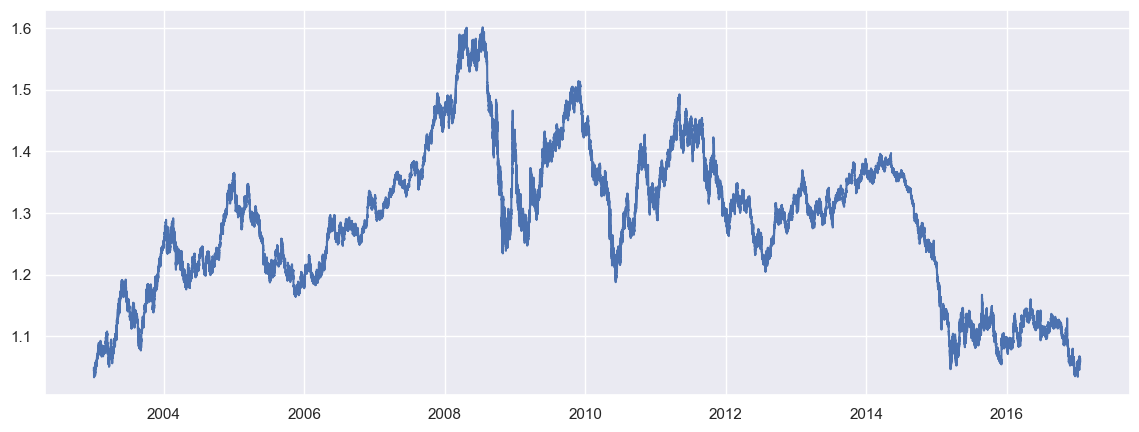

In [9]:
plt.figure(figsize=(14,5))
plt.plot(target_prices_trn['<DT>'], target_prices_trn['<OPEN>'])

In [10]:
len(target_prices_trn)

492327

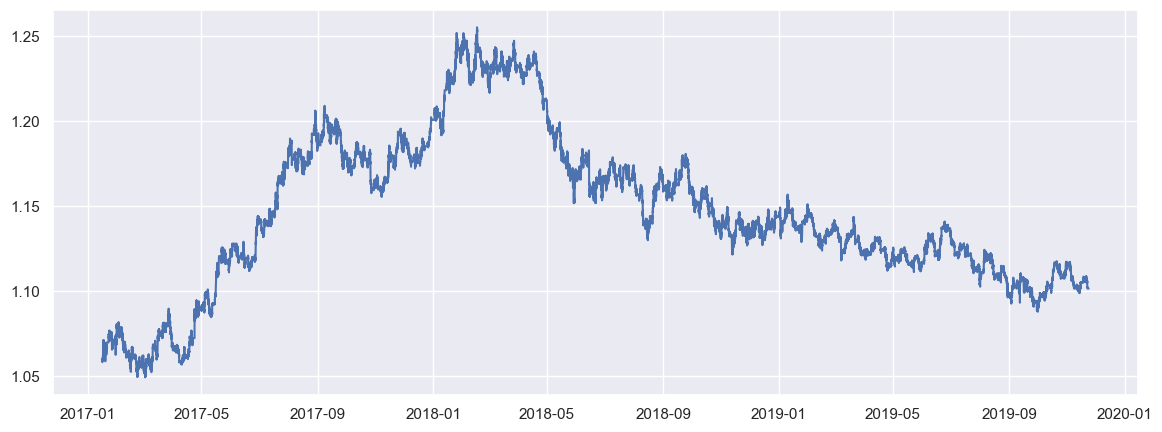

In [11]:
plt.figure(figsize=(14,5))
plt.plot(target_prices_val['<DT>'], target_prices_val['<OPEN>'])

In [12]:
len(target_prices_val)

100000

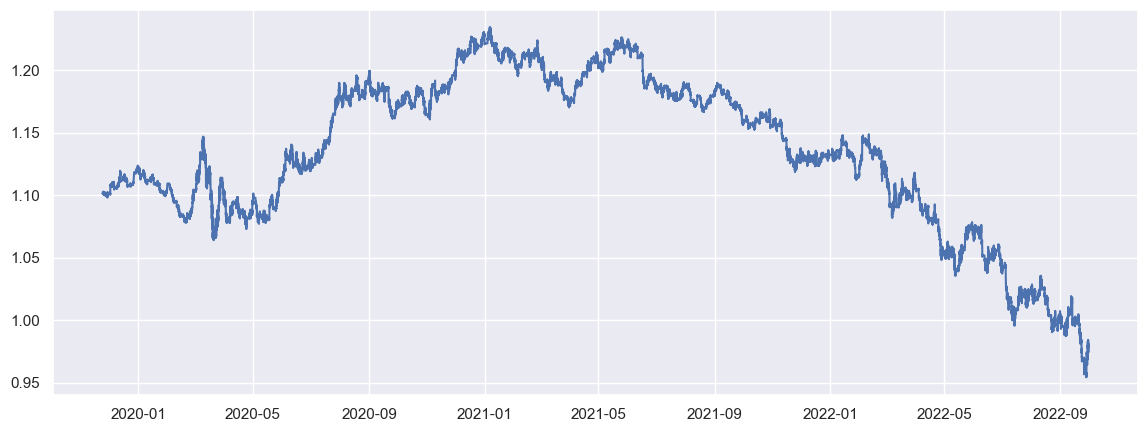

In [13]:
plt.figure(figsize=(14,5))
plt.plot(target_prices_eval['<DT>'], target_prices_eval['<OPEN>'])

In [14]:
len(target_prices_eval)

100000

In [15]:
basic_features = engineer_forex_features(forex_data, ForexFeEngStrategy.BASIC, {'recent_returns' : 8})

In [16]:
basic_features_trn = basic_features[
    (basic_features['<DT>'] >= TRN_START_DATE) & (basic_features['<DT>'] < VAL_START_DATE)
].drop('<DT>', axis=1).reset_index(drop=True)

basic_features_val = basic_features[
    (basic_features['<DT>'] >= VAL_START_DATE) & (basic_features['<DT>'] < EVAL_START_DATE)
].drop('<DT>', axis=1).reset_index(drop=True)

basic_features_eval = basic_features[
    (basic_features['<DT>'] >= EVAL_START_DATE) & (basic_features['<DT>'] < EVAL_END_DATE)
].drop('<DT>', axis=1).reset_index(drop=True)

In [17]:
basic_features

<DT>     <MIN SIN>  <HOUR SIN>  <WEEKDAY SIN>  \
0      2003-01-02 01:00:00  0.000000e+00    0.258819       0.433884   
1      2003-01-02 01:15:00  1.000000e+00    0.258819       0.433884   
2      2003-01-02 01:30:00  5.665539e-16    0.258819       0.433884   
3      2003-01-02 01:45:00 -1.000000e+00    0.258819       0.433884   
4      2003-01-02 02:00:00  0.000000e+00    0.500000       0.433884   
...                    ...           ...         ...            ...   
692323 2022-09-30 17:45:00 -1.000000e+00   -0.965926      -0.433884   
692324 2022-09-30 18:00:00  0.000000e+00   -1.000000      -0.433884   
692325 2022-09-30 18:15:00  1.000000e+00   -1.000000      -0.433884   
692326 2022-09-30 18:30:00  5.665539e-16   -1.000000      -0.433884   
692327 2022-09-30 18:45:00 -1.000000e+00   -1.000000      -0.433884   

        <AUDJPY OPEN RECENT RETURN 1>  <AUDJPY OPEN RECENT RETURN 2>  \
0                            0.000300                       0.000000   
1                            0.000749                       0.000300   
2                            0.000749                       0.000749   
3                            0.000598                       0.000749   
4                            0.000748                       0.000598   
...                               ...                            ...   
692323                      -0.000540                      -0.000432   
692324                      -0.000216                      -0.000540   
692325                       0.000432                      -0.000216   
692326                       0.000000                       0.000432   
692327                      -0.000540                       0.000000   

        <AUDJPY OPEN RECENT RETURN 3>  <AUDJPY OPEN RECENT RETURN 4>  \
0                           -0.000150                      -0.000600   
1                            0.000000                      -0.000150   
2                            0.000300                       0.000000   
3                            0.000749                       0.000300   
4                            0.000749                       0.000749   
...                               ...                            ...   
692323                      -0.001079                      -0.000970   
692324                      -0.000432                      -0.001079   
692325                      -0.000540                      -0.000432   
692326                      -0.000216                      -0.000540   
692327                       0.000432                      -0.000216   

        <AUDJPY OPEN RECENT RETURN 5>  <AUDJPY OPEN RECENT RETURN 6>  ...  \
0                            0.000000                       0.000450  ...   
1                           -0.000600                       0.000000  ...   
2                           -0.000150                      -0.000600  ...   
3                            0.000000                      -0.000150  ...   
4                            0.000300                       0.000000  ...   
...                               ...                            ...  ...   
692323                      -0.000323                       0.000000  ...   
692324                      -0.000970                      -0.000323  ...   
692325                      -0.001079                      -0.000970  ...   
692326                      -0.000432                      -0.001079  ...   
692327                      -0.000540                      -0.000432  ...   

        <USDCHF OPEN RECENT RETURN 7>  <USDCHF OPEN RECENT RETURN 8>  \
0                            0.000433                      -0.002020   
1                           -0.000144                       0.000433   
2                            0.000289                      -0.000144   
3                           -0.000289                       0.000289   
4                           -0.000289                      -0.000289   
...                               ...                            ...   
692323    

In [17]:
ta_target_features = engineer_forex_features({TARGET : forex_data[TARGET]}, ForexFeEngStrategy.TA, {'lags' : 8})

/Users/astepura/miniforge3/envs/rl/lib/python3.9/site-packages/ta/trend.py:730: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  self._trs[0] = diff_directional_movement.dropna()[
/Users/astepura/miniforge3/envs/rl/lib/python3.9/site-packages/ta/trend.py:748: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  self._dip[0] = pos.dropna()[0: self._window].sum()
/Users/astepura/miniforge3/envs/rl/lib/python3.9/site-packages/ta/trend.py:760: FutureWarning: The behavior of `series[i:j]` with 

In [18]:
ta_target_features

<DT>  <EURUSD BB HIGH INDICATOR>  \
0      2001-01-03 01:00:00                         0.0   
1      2001-01-03 01:15:00                         0.0   
2      2001-01-03 01:30:00                         0.0   
3      2001-01-03 01:45:00                         0.0   
4      2001-01-03 02:00:00                         0.0   
...                    ...                         ...   
762307 2022-09-30 17:45:00                         0.0   
762308 2022-09-30 18:00:00                         0.0   
762309 2022-09-30 18:15:00                         0.0   
762310 2022-09-30 18:30:00                         0.0   
762311 2022-09-30 18:45:00                         0.0   

        <EURUSD BB LOW INDICATOR>  <EURUSD BB PERC BAND>  \
0                             1.0              -0.039328   
1                             0.0               0.245593   
2                             0.0               0.665412   
3                             0.0               0.596355   
4                             0.0               0.528814   
...                           ...                    ...   
762307                        0.0               0.733767   
762308                        0.0               0.625541   
762309                        0.0               0.850067   
762310                        0.0               0.783564   
762311                        0.0               0.645364   

        <EURUSD BB WIDTH BAND>  <EURUSD ATR>  <EURUSD MACD DIFF>  \
0                     0.168259      0.000000           -0.000097   
1                     0.170031      0.000389           -0.000097   
2                     0.165373      0.000440           -0.000046   
3                     0.158859      0.000416           -0.000018   
4                     0.152187      0.000404           -0.000005   
...                        ...           ...                 ...   
762307                0.388758      0.001176            0.000115   
762308                0.390403      0.001128            0.000072   
762309                0.398155      0.001135            0.000095   
762310                0.408687      0.001042            0.000088   
762311                0.410905      0.001017            0.000042   

        <EURUSD VORTEX DIFF>  <EURUSD +DIR>  <EURUSD -DIR>  ...  \
0                  -0.689694       0.000000       0.000000  ...   
1                  -0.457151       0.000000       0.000000  ...   
2                  -0.068181       0.000000       0.000000  ...   
3                   0.000000       0.000000       0.000000  ...   
4                  -0.061223       0.000000       0.000000  ...   
...                      ...            ...            ...  ...   
762307              0.300745      26.808933      18.382341  ...   
762308              0.356585      25.741488      17.650415  ...   
762309              0.350740      27.402533      16.441844  ...   
762310              0.392000      27.069780      16.242188  ...   
762311              0.214875      25.724367      19.162365  ...   

        <EURUSD STOCH RSI K LAG 7>  <EURUSD STOCH RSI K LAG 8>  \
0                         0.000000                    0.000000   
1                         0.000000                    0.000000   
2                         0.000000                    0.000000   
3                         0.000000                    0.000000   
4                         0.000000                    0.000000   
...                            ...                         ...   
762307                    0.678206                    0.673186   
762308                    0.766450                    0.678206   
762309                    0.810133                    0.766450   
762310                    0.890754                    0.810133   
762311                    0.950772                    0.890754   

        <EURUSD UO LAG 1>  <EURUSD UO LAG 2>  <EURUSD UO LAG 3>  \
0               19.046267          30.768525          33.335541   
1               28.753244          19.046267          3

In [19]:
ta_target_features_trn = ta_target_features[
    (ta_target_features['<DT>'] >= TRN_START_DATE) & (ta_target_features['<DT>'] < VAL_START_DATE)
].drop('<DT>', axis=1).reset_index(drop=True)

ta_target_features_val = ta_target_features[
    (ta_target_features['<DT>'] >= VAL_START_DATE) & (ta_target_features['<DT>'] < EVAL_START_DATE)
].drop('<DT>', axis=1).reset_index(drop=True)

ta_target_features_eval = ta_target_features[
    (ta_target_features['<DT>'] >= EVAL_START_DATE) & (ta_target_features['<DT>'] < EVAL_END_DATE)
].drop('<DT>', axis=1).reset_index(drop=True)

In [20]:
extended_features = pd.merge(basic_features, ta_target_features, on='<DT>')

In [21]:
extended_features_trn = extended_features[
    (extended_features['<DT>'] >= TRN_START_DATE) & (extended_features['<DT>'] < VAL_START_DATE)
].drop('<DT>', axis=1).reset_index(drop=True)

extended_features_val = extended_features[
    (extended_features['<DT>'] >= VAL_START_DATE) & (extended_features['<DT>'] < EVAL_START_DATE)
].drop('<DT>', axis=1).reset_index(drop=True)

extended_features_eval = extended_features[
    (extended_features['<DT>'] >= EVAL_START_DATE) & (extended_features['<DT>'] < EVAL_END_DATE)
].drop('<DT>', axis=1).reset_index(drop=True)

In [22]:
def create_eurusd_env(
    eval,
    target_prices_trn,
    target_prices_eval,
    features_trn,
    features_eval,
    env_kwargs,
    trn_wrappers={},
    eval_wrappers={}
):
    env = ForexEnvBasic(
        target_prices_trn,
        features_trn,
        **deepcopy(env_kwargs)
    )
    return TrnOrEvalForexWrapper(
        env,
        target_prices_val,
        features_eval,
        eval,
        trn_wrappers,
        eval_wrappers
    )

In [23]:
BASE_ENV_KWARGS = dict(
    portfolio_value=1000,
    allowed_actions={Actions.SELL, Actions.BUY},
    market_order_strategy=ForexMarketOrderStrategyAllIn(),
    reward_strategy=ForexRewardStrategyLogPortfolioReturn(),
    trading_costs_strategy=ForexTradingCostsStrategySpread(spread=0.0001),
    include_in_obs = ['position']
)

In [ ]:
#%tensorboard --logdir {LOGS_PATH}/training/TensorBoard

## 2 actions, basic features, running normalization environment

In [24]:
def create_full_eurusd_env_v1(eval):
    return create_eurusd_env(
        eval,
        target_prices_trn,
        target_prices_val,
        basic_features_trn,
        basic_features_val,
        BASE_ENV_KWARGS
    )

In [25]:
register(
    'ForexFullEURUSD-v1',
    entry_point=create_full_eurusd_env_v1
)

### DQN

In [20]:
sys.argv = [
    'python', 
    '--algo', 'dqn',
    '--env', 'ForexFullEURUSD-v1',
    '--tensorboard-log', f'{LOGS_PATH}/training/TensorBoard',
    '--n-timesteps', '5000000',
    '--eval-freq', '100000',
    '--eval-episodes', '1',
    '--log-folder', f'{LOGS_PATH}/training',
    '--seed', '604',
    '--verbose', '0',
    '--hyperparams', 'normalize:dict(norm_reward=False)', 'callback:"rl_trading.utils.TextProgressBarCallback"',
    '--conf-file', f'{HYPERPARAMS_PATH}/default/dqn.yml'
]

train()

========== ForexFullEURUSD-v1 ==========
Seed: 604
Loading hyperparameters from: /Users/astepura/Desktop/I-CUREUS/RL-trading/hyperparams/default/dqn.yml
Default hyperparameters for environment (ones being tuned will be overridden):
OrderedDict([('batch_size', 32),
             ('buffer_size', 1000000),
             ('callback', 'rl_trading.utils.TextProgressBarCallback'),
             ('exploration_final_eps', 0.05),
             ('exploration_fraction', 0.1),
             ('gamma', 0.99),
             ('gradient_steps', 1),
             ('learning_rate', 0.0001),
             ('learning_starts', 50000),
             ('normalize', {'norm_reward': False}),
             ('policy', 'MlpPolicy'),
             ('policy_kwargs', 'dict( net_arch=[64, 64] )'),
             ('target_update_interval', 10000),
             ('train_freq', 4)])
Log path: /Users/astepura/Desktop/I-CUREUS/RL-trading/logs/training/dqn/ForexFullEURUSD-v1_2


  2%|▌                          | 100289/5000000 [00:39<16:44:50, 81.27it/s]

Eval num_timesteps=100000, episode_reward=-4.56 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


  4%|█                          | 200361/5000000 [01:28<14:52:27, 89.63it/s]

Eval num_timesteps=200000, episode_reward=-1.73 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


  6%|█▌                         | 300393/5000000 [02:18<15:09:50, 86.09it/s]

Eval num_timesteps=300000, episode_reward=-1.12 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


  8%|██▏                        | 400269/5000000 [03:08<14:40:18, 87.09it/s]

Eval num_timesteps=400000, episode_reward=-0.39 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 10%|██▋                        | 500333/5000000 [04:00<15:27:04, 80.89it/s]

Eval num_timesteps=500000, episode_reward=-1.97 +/- 0.00
Episode length: 99999.00 +/- 0.00


 12%|███▏                       | 600187/5000000 [04:54<17:01:44, 71.77it/s]

Eval num_timesteps=600000, episode_reward=-1.60 +/- 0.00
Episode length: 99999.00 +/- 0.00


 14%|███▊                       | 700235/5000000 [05:49<20:49:11, 57.37it/s]

Eval num_timesteps=700000, episode_reward=-0.74 +/- 0.00
Episode length: 99999.00 +/- 0.00


 16%|████▎                      | 800185/5000000 [06:43<18:47:54, 62.06it/s]

Eval num_timesteps=800000, episode_reward=0.05 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 18%|████▊                      | 900188/5000000 [07:42<16:28:17, 69.14it/s]

Eval num_timesteps=900000, episode_reward=-0.49 +/- 0.00
Episode length: 99999.00 +/- 0.00


 20%|█████▏                    | 1000269/5000000 [08:37<14:45:52, 75.25it/s]

Eval num_timesteps=1000000, episode_reward=-1.22 +/- 0.00
Episode length: 99999.00 +/- 0.00


 22%|█████▋                    | 1100121/5000000 [09:35<25:07:59, 43.10it/s]

Eval num_timesteps=1100000, episode_reward=-2.14 +/- 0.00
Episode length: 99999.00 +/- 0.00


 24%|██████▏                   | 1200177/5000000 [10:45<17:09:28, 61.52it/s]

Eval num_timesteps=1200000, episode_reward=-1.42 +/- 0.00
Episode length: 99999.00 +/- 0.00


 26%|███████                    | 1299984/5000000 [11:44<31:40, 1946.99it/s]

Eval num_timesteps=1300000, episode_reward=-2.07 +/- 0.00
Episode length: 99999.00 +/- 0.00


 28%|███████▎                  | 1400145/5000000 [13:04<20:56:26, 47.75it/s]

Eval num_timesteps=1400000, episode_reward=-1.82 +/- 0.00
Episode length: 99999.00 +/- 0.00


 30%|███████▊                  | 1500021/5000000 [14:32<54:05:17, 17.97it/s]

Eval num_timesteps=1500000, episode_reward=-1.37 +/- 0.00
Episode length: 99999.00 +/- 0.00


 32%|████████▎                 | 1600065/5000000 [16:26<22:23:55, 42.16it/s]

Eval num_timesteps=1600000, episode_reward=-1.85 +/- 0.00
Episode length: 99999.00 +/- 0.00


 34%|████████▊                 | 1700315/5000000 [17:26<12:11:25, 75.19it/s]

Eval num_timesteps=1700000, episode_reward=-1.26 +/- 0.00
Episode length: 99999.00 +/- 0.00


 36%|█████████▎                | 1800224/5000000 [18:22<11:45:38, 75.58it/s]

Eval num_timesteps=1800000, episode_reward=-0.75 +/- 0.00
Episode length: 99999.00 +/- 0.00


 38%|█████████▉                | 1900045/5000000 [19:33<23:26:52, 36.72it/s]

Eval num_timesteps=1900000, episode_reward=-1.09 +/- 0.00
Episode length: 99999.00 +/- 0.00


 40%|██████████▍               | 2000186/5000000 [20:39<17:11:19, 48.48it/s]

Eval num_timesteps=2000000, episode_reward=-0.62 +/- 0.00
Episode length: 99999.00 +/- 0.00


 42%|██████████▉               | 2100253/5000000 [21:38<10:52:43, 74.04it/s]

Eval num_timesteps=2100000, episode_reward=-0.37 +/- 0.00
Episode length: 99999.00 +/- 0.00


 44%|███████████▍              | 2200173/5000000 [22:35<11:55:43, 65.20it/s]

Eval num_timesteps=2200000, episode_reward=-0.69 +/- 0.00
Episode length: 99999.00 +/- 0.00


 46%|███████████▉              | 2300191/5000000 [23:32<11:22:01, 65.97it/s]

Eval num_timesteps=2300000, episode_reward=-0.80 +/- 0.00
Episode length: 99999.00 +/- 0.00


 48%|████████████▍             | 2400193/5000000 [24:44<11:59:59, 60.18it/s]

Eval num_timesteps=2400000, episode_reward=-0.72 +/- 0.00
Episode length: 99999.00 +/- 0.00


 50%|█████████████             | 2500105/5000000 [25:42<14:14:33, 48.76it/s]

Eval num_timesteps=2500000, episode_reward=-0.07 +/- 0.00
Episode length: 99999.00 +/- 0.00


 52%|█████████████▌            | 2600078/5000000 [26:42<17:21:50, 38.39it/s]

Eval num_timesteps=2600000, episode_reward=-0.30 +/- 0.00
Episode length: 99999.00 +/- 0.00


 54%|██████████████▌            | 2700388/5000000 [27:38<8:31:21, 74.95it/s]

Eval num_timesteps=2700000, episode_reward=0.01 +/- 0.00
Episode length: 99999.00 +/- 0.00


 56%|███████████████            | 2800225/5000000 [28:47<8:19:06, 73.46it/s]

Eval num_timesteps=2800000, episode_reward=-0.10 +/- 0.00
Episode length: 99999.00 +/- 0.00


 58%|███████████████▋           | 2899835/5000000 [29:33<14:19, 2442.97it/s]

Eval num_timesteps=2900000, episode_reward=-0.02 +/- 0.00
Episode length: 99999.00 +/- 0.00


 60%|████████████████▏          | 3000189/5000000 [31:05<8:15:53, 67.21it/s]

Eval num_timesteps=3000000, episode_reward=-0.04 +/- 0.00
Episode length: 99999.00 +/- 0.00


 62%|████████████████▋          | 3100345/5000000 [32:00<7:10:27, 73.55it/s]

Eval num_timesteps=3100000, episode_reward=-0.28 +/- 0.00
Episode length: 99999.00 +/- 0.00


 64%|█████████████████▎         | 3200233/5000000 [32:54<6:12:13, 80.59it/s]

Eval num_timesteps=3200000, episode_reward=-0.75 +/- 0.00
Episode length: 99999.00 +/- 0.00


 66%|█████████████████▊         | 3300337/5000000 [33:45<5:33:27, 84.95it/s]

Eval num_timesteps=3300000, episode_reward=0.02 +/- 0.00
Episode length: 99999.00 +/- 0.00


 68%|██████████████████▎        | 3400214/5000000 [34:37<5:12:50, 85.23it/s]

Eval num_timesteps=3400000, episode_reward=-0.09 +/- 0.00
Episode length: 99999.00 +/- 0.00


 70%|██████████████████▉        | 3500257/5000000 [35:29<4:51:48, 85.66it/s]

Eval num_timesteps=3500000, episode_reward=-0.05 +/- 0.00
Episode length: 99999.00 +/- 0.00


 72%|███████████████████▍       | 3600305/5000000 [36:21<4:43:02, 82.42it/s]

Eval num_timesteps=3600000, episode_reward=-0.17 +/- 0.00
Episode length: 99999.00 +/- 0.00


 74%|███████████████████▉       | 3700216/5000000 [37:12<4:53:08, 73.90it/s]

Eval num_timesteps=3700000, episode_reward=-0.18 +/- 0.00
Episode length: 99999.00 +/- 0.00


 76%|████████████████████▌      | 3800145/5000000 [38:06<6:33:57, 50.76it/s]

Eval num_timesteps=3800000, episode_reward=-0.05 +/- 0.00
Episode length: 99999.00 +/- 0.00


 78%|█████████████████████      | 3900213/5000000 [39:07<4:42:25, 64.90it/s]

Eval num_timesteps=3900000, episode_reward=-0.06 +/- 0.00
Episode length: 99999.00 +/- 0.00


 80%|█████████████████████▌     | 4000121/5000000 [40:32<4:51:13, 57.22it/s]

Eval num_timesteps=4000000, episode_reward=-0.05 +/- 0.00
Episode length: 99999.00 +/- 0.00


 82%|██████████████████████▏    | 4100204/5000000 [41:29<4:14:17, 58.97it/s]

Eval num_timesteps=4100000, episode_reward=-0.10 +/- 0.00
Episode length: 99999.00 +/- 0.00


 84%|██████████████████████▋    | 4200199/5000000 [42:24<3:39:13, 60.80it/s]

Eval num_timesteps=4200000, episode_reward=0.02 +/- 0.00
Episode length: 99999.00 +/- 0.00


 86%|███████████████████████▏   | 4300253/5000000 [43:19<2:42:16, 71.87it/s]

Eval num_timesteps=4300000, episode_reward=0.04 +/- 0.00
Episode length: 99999.00 +/- 0.00


 88%|███████████████████████▊   | 4400130/5000000 [44:18<2:49:40, 58.92it/s]

Eval num_timesteps=4400000, episode_reward=-0.06 +/- 0.00
Episode length: 99999.00 +/- 0.00


 90%|████████████████████████▎  | 4500333/5000000 [45:25<2:01:13, 68.70it/s]

Eval num_timesteps=4500000, episode_reward=-0.06 +/- 0.00
Episode length: 99999.00 +/- 0.00


 92%|████████████████████████▊  | 4600142/5000000 [46:24<1:36:06, 69.34it/s]

Eval num_timesteps=4600000, episode_reward=-0.04 +/- 0.00
Episode length: 99999.00 +/- 0.00


 94%|█████████████████████████▍ | 4700173/5000000 [47:20<1:05:54, 75.82it/s]

Eval num_timesteps=4700000, episode_reward=-0.06 +/- 0.00
Episode length: 99999.00 +/- 0.00


 96%|█████████████████████████▉ | 4800149/5000000 [48:15<1:00:09, 55.36it/s]

Eval num_timesteps=4800000, episode_reward=-0.10 +/- 0.00
Episode length: 99999.00 +/- 0.00


 98%|████████████████████████████▍| 4900186/5000000 [49:13<28:36, 58.15it/s]

Eval num_timesteps=4900000, episode_reward=0.04 +/- 0.00
Episode length: 99999.00 +/- 0.00


100%|███████████████████████████| 5000000/5000000 [50:11<00:00, 1660.18it/s]

Eval num_timesteps=5000000, episode_reward=0.02 +/- 0.00
Episode length: 99999.00 +/- 0.00
Saving to /Users/astepura/Desktop/I-CUREUS/RL-trading/logs/training/dqn/ForexFullEURUSD-v1_2


#### Final model

In [21]:
_, model_path, log_path = get_model_path(0, f'{LOGS_PATH}/training', 'dqn', 'ForexFullEURUSD-v1')

Loading latest experiment, id=2


In [23]:
model = DQN.load(model_path)

##### Train set results

In [22]:
eurusd_env_trn = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/vecnormalize.pkl',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=False)
    )
)

In [24]:
obs = eurusd_env_trn.reset()
for i in tqdm(range(len(target_prices_trn) - 2)):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_trn.step(action)

100%|█████████████████████████████| 492325/492325 [01:40<00:00, 4883.70it/s]


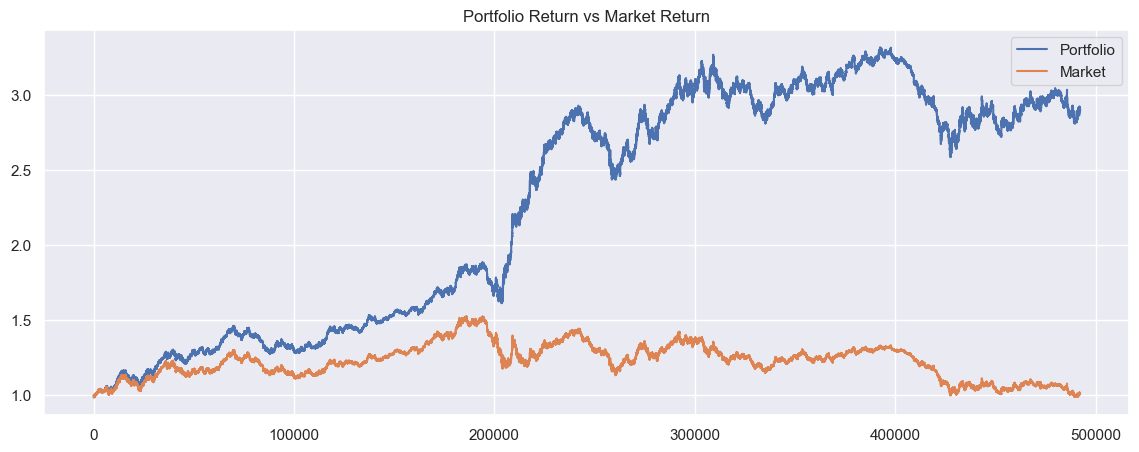

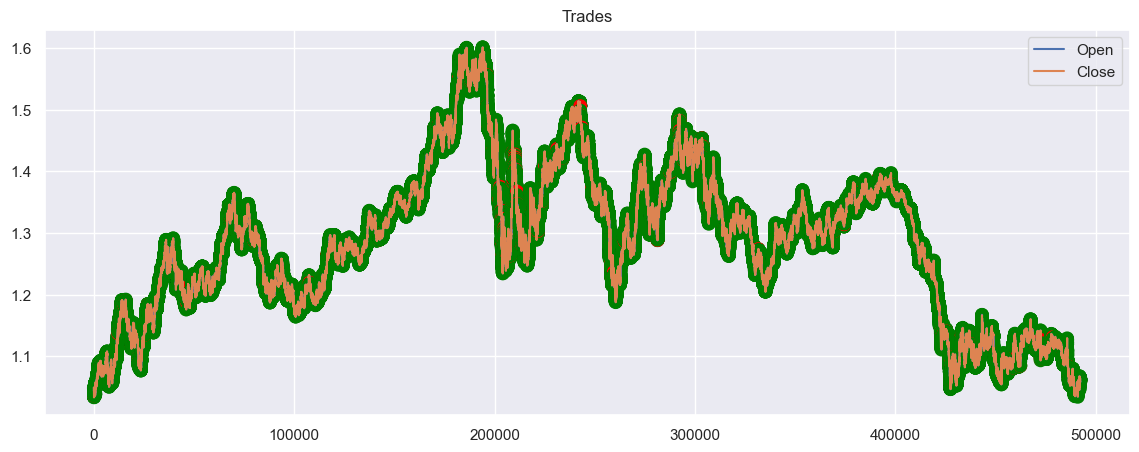

In [25]:
eurusd_env_trn.render()

In [29]:
len([fee for fee in eurusd_env_trn.get_attr('history')[0]['trading_costs'] if fee != 0])

1250

##### Validation set results

In [30]:
eurusd_env_val = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/vecnormalize.pkl',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=True)
    )
)

In [31]:
obs = eurusd_env_val.reset()
for i in tqdm(range(len(target_prices_val) - 2)):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_val.step(action)

100%|███████████████████████████████| 99998/99998 [00:20<00:00, 4888.34it/s]


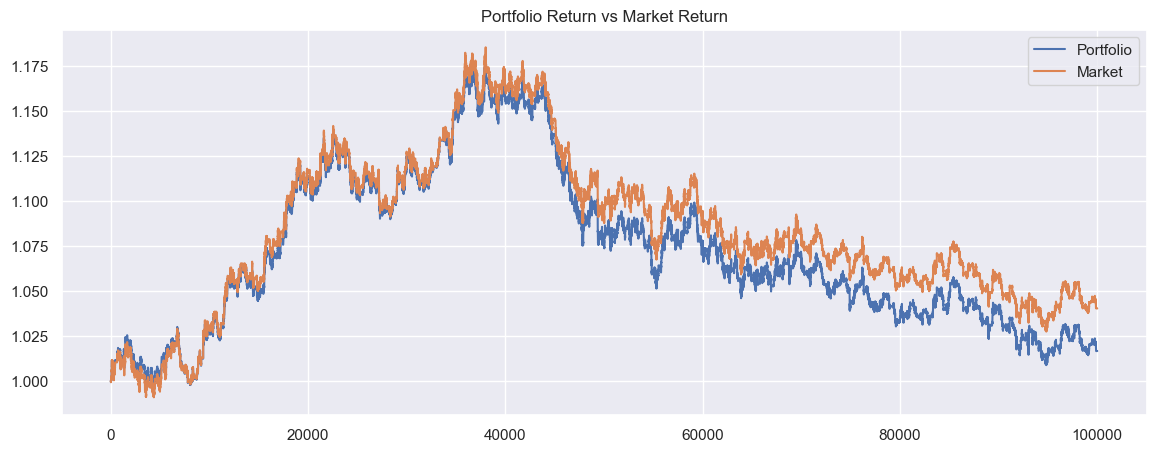

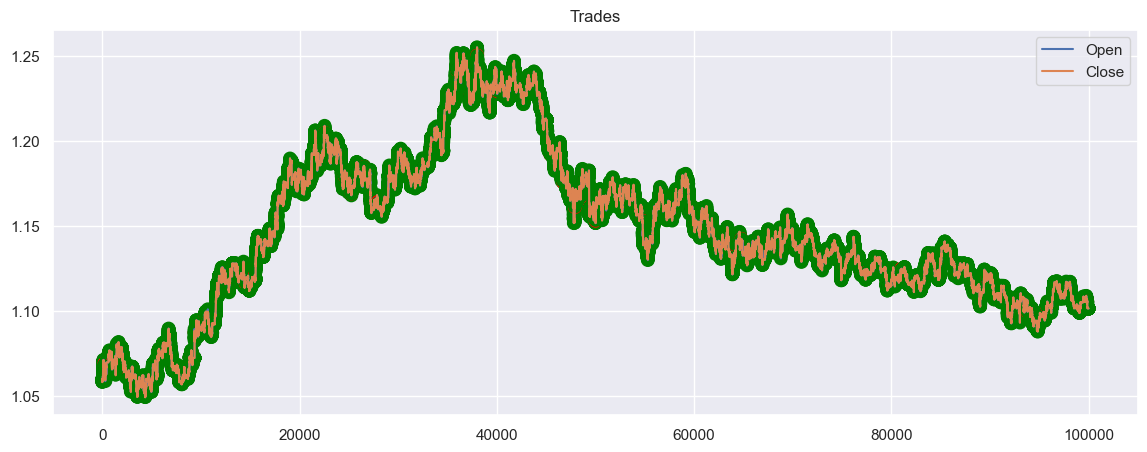

In [32]:
eurusd_env_val.render()

In [33]:
len([fee for fee in eurusd_env_val.get_attr('history')[0]['trading_costs'] if fee != 0])

149

##### Evaluation set results

In [37]:
eurusd_env_eval = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/vecnormalize.pkl',
    make_vec_env(
        ForexEnvBasic,
        env_kwargs=dict(
            target_prices_df=target_prices_eval,
            features_df=basic_features_eval,
            **deepcopy(BASE_ENV_KWARGS)
        )
    )
)

In [38]:
obs = eurusd_env_eval.reset()
for i in tqdm(range(len(target_prices_eval) - 2)):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_eval.step(action)

100%|███████████████████████████████| 99998/99998 [00:18<00:00, 5396.68it/s]


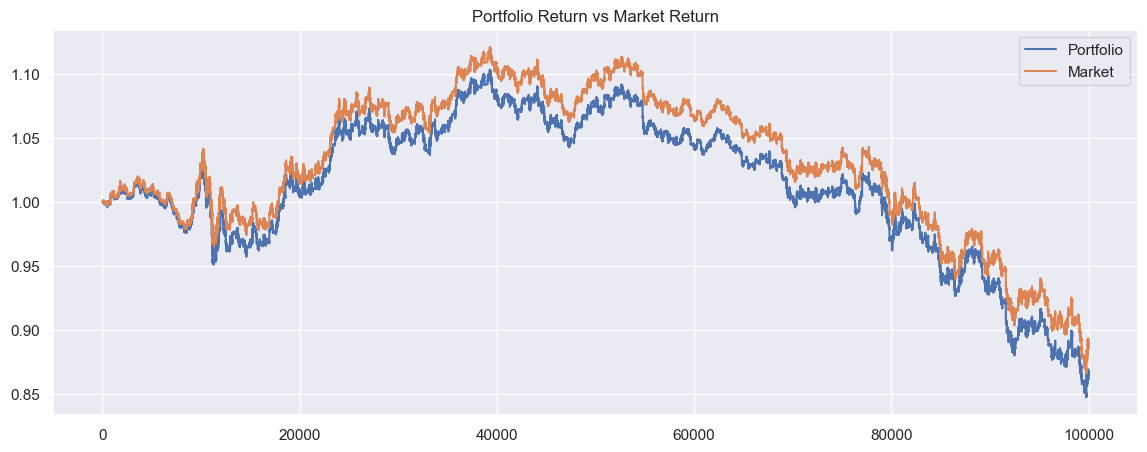

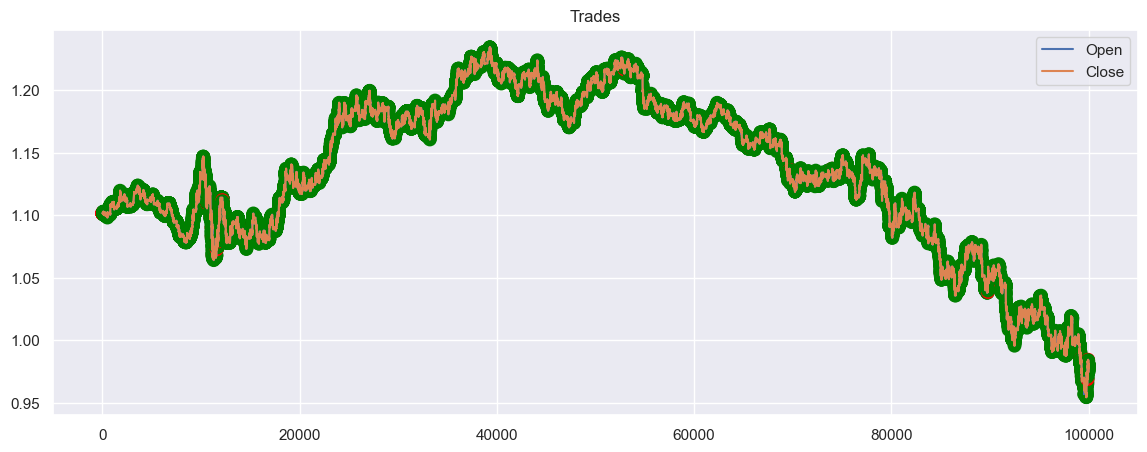

In [39]:
eurusd_env_eval.render()

In [40]:
len([fee for fee in eurusd_env_eval.get_attr('history')[0]['trading_costs'] if fee != 0])

148

#### Best model

In [41]:
_, best_model_path, log_path = get_model_path(0, f'{LOGS_PATH}/training', 'dqn', 'ForexFullEURUSD-v1', load_best=True)

Loading latest experiment, id=2


In [42]:
best_model_vecnormalize = sorted(
    [filename for filename in os.listdir(f'{log_path}/ForexFullEURUSD-v1') if 'vecnormalize_' in filename], 
    key=lambda x: int(x.split('_')[1])
)[-1]

In [43]:
best_model_vecnormalize

'vecnormalize_800000_steps.pkl'

In [45]:
best_model = DQN.load(best_model_path)

##### Train set results

In [44]:
eurusd_env_trn = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/{best_model_vecnormalize}',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=False)
    )
)

In [46]:
obs = eurusd_env_trn.reset()
for i in tqdm(range(len(target_prices_trn) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_trn.step(action)

100%|█████████████████████████████| 492325/492325 [01:35<00:00, 5146.43it/s]


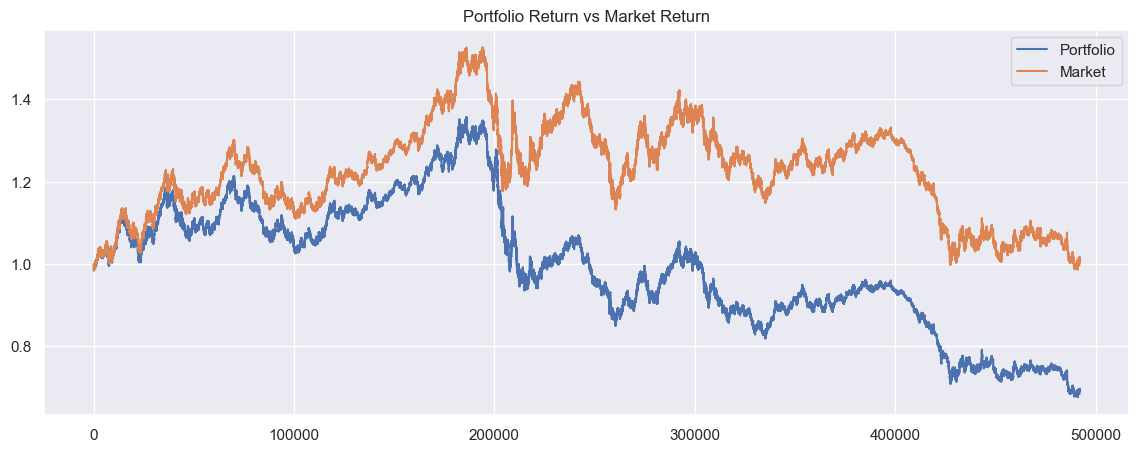

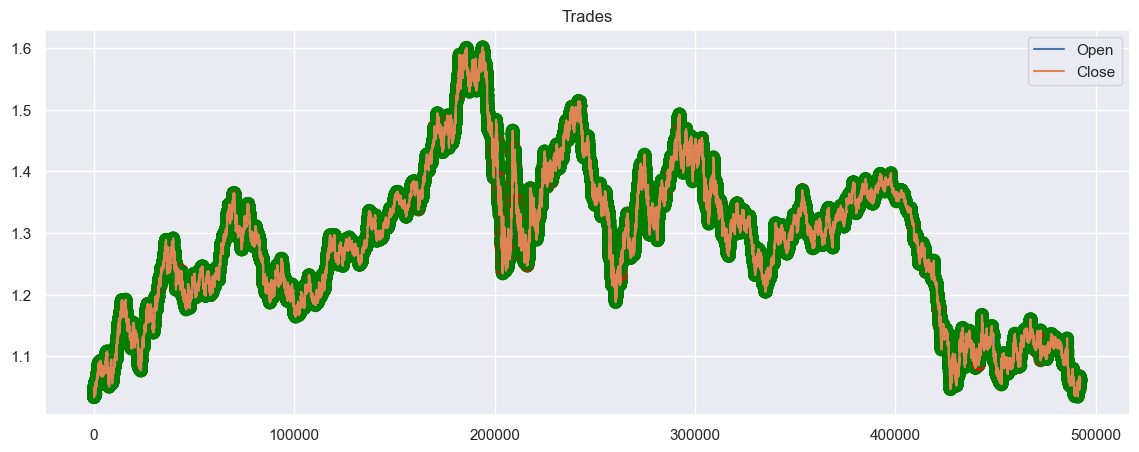

In [47]:
eurusd_env_trn.render()

In [48]:
len([fee for fee in eurusd_env_trn.get_attr('history')[0]['trading_costs'] if fee != 0])

2382

##### Validation set results

In [49]:
eurusd_env_val = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/{best_model_vecnormalize}',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=True)
    )
)

In [50]:
obs = eurusd_env_val.reset()
for i in tqdm(range(len(target_prices_val) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_val.step(action)

100%|███████████████████████████████| 99998/99998 [00:19<00:00, 5169.42it/s]


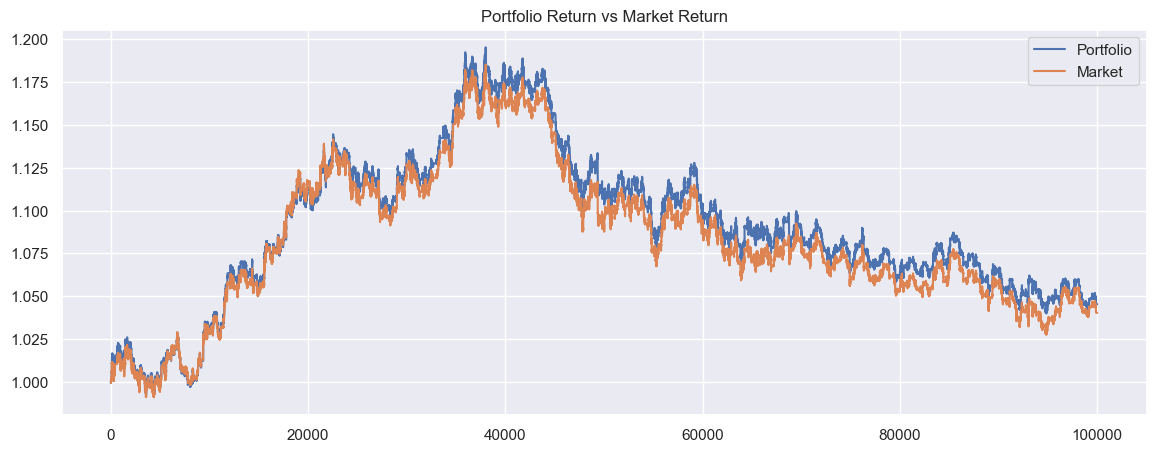

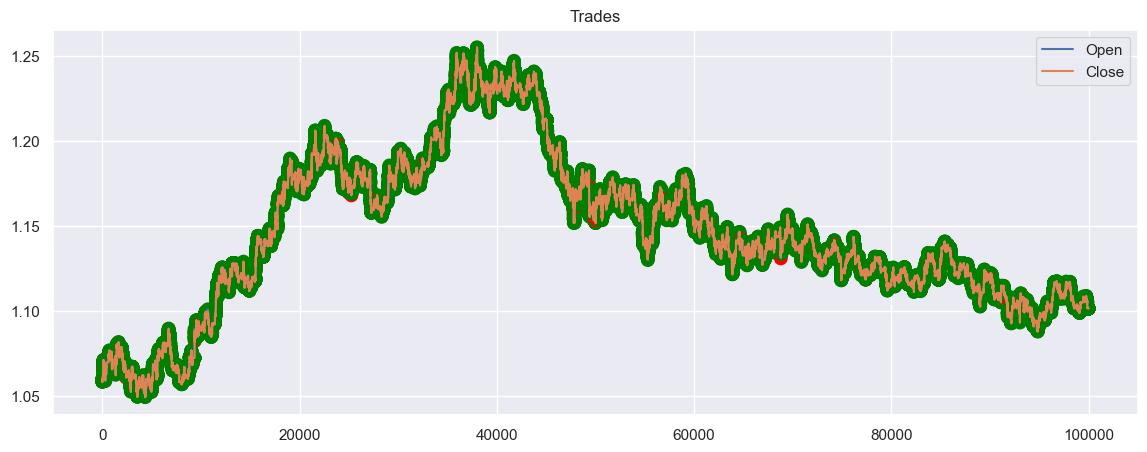

In [51]:
eurusd_env_val.render()

In [52]:
len([fee for fee in eurusd_env_val.get_attr('history')[0]['trading_costs'] if fee != 0])

212

##### Evaluation set results

In [53]:
eurusd_env_eval = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/{best_model_vecnormalize}',
    make_vec_env(
        ForexEnvBasic,
        env_kwargs=dict(
            target_prices_df=target_prices_eval,
            features_df=basic_features_eval,
            **deepcopy(BASE_ENV_KWARGS)
        )
    )
)

In [54]:
obs = eurusd_env_eval.reset()
for i in tqdm(range(len(target_prices_eval) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_eval.step(action)

100%|███████████████████████████████| 99998/99998 [00:19<00:00, 5167.21it/s]


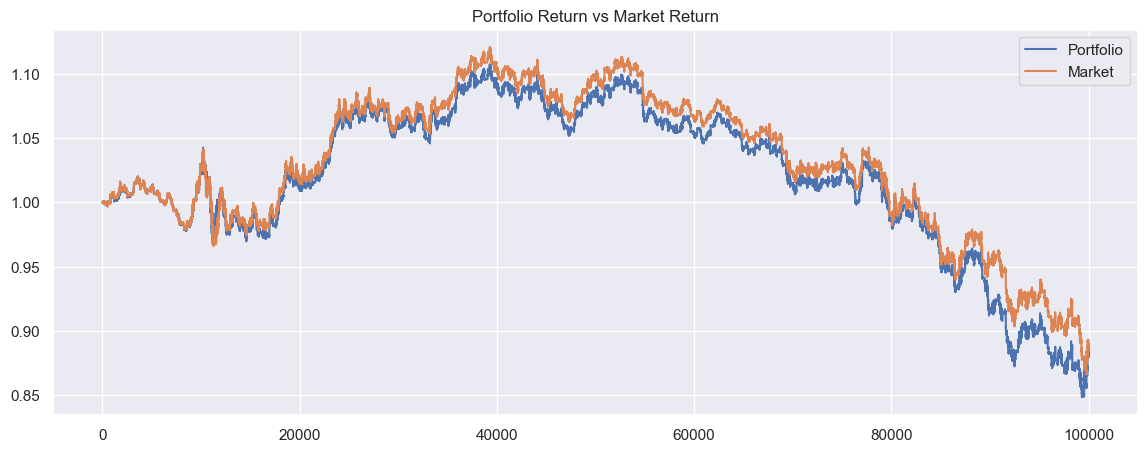

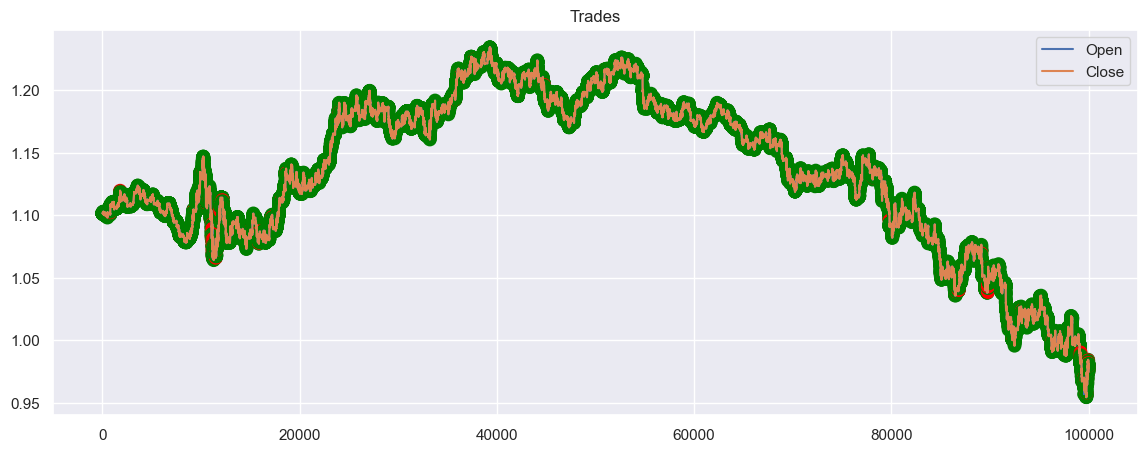

In [55]:
eurusd_env_eval.render()

In [56]:
len([fee for fee in eurusd_env_eval.get_attr('history')[0]['trading_costs'] if fee != 0])

280

### A2C

In [57]:
sys.argv = [
    'python', 
    '--algo', 'a2c',
    '--env', 'ForexFullEURUSD-v1',
    '--tensorboard-log', f'{LOGS_PATH}/training/TensorBoard',
    '--n-timesteps', '5000000',
    '--eval-freq', '100000',
    '--eval-episodes', '1',
    '--log-folder', f'{LOGS_PATH}/training',
    '--seed', '604',
    '--verbose', '0',
    '--hyperparams', 'normalize:dict(norm_reward=False)', 'callback:"rl_trading.utils.TextProgressBarCallback"',
    '--conf-file', f'{HYPERPARAMS_PATH}/default/a2c.yml'
]

train()

========== ForexFullEURUSD-v1 ==========
Seed: 604
Loading hyperparameters from: /Users/astepura/Desktop/I-CUREUS/RL-trading/hyperparams/default/a2c.yml
Default hyperparameters for environment (ones being tuned will be overridden):
OrderedDict([('callback', 'rl_trading.utils.TextProgressBarCallback'),
             ('ent_coef', 0.0),
             ('gae_lambda', 1.0),
             ('gamma', 0.99),
             ('learning_rate', 0.0007),
             ('max_grad_norm', 0.5),
             ('n_steps', 5),
             ('normalize', {'norm_reward': False}),
             ('normalize_advantage', False),
             ('policy', 'MlpPolicy'),
             ('policy_kwargs',
              'dict( net_arch=[dict(pi=[64, 64], vf=[64, 64])], '
              'activation_fn=nn.Tanh, ortho_init=True )'),
             ('use_rms_prop', True),
             ('vf_coef', 0.5)])
Log path: /Users/astepura/Desktop/I-CUREUS/RL-trading/logs/training/a2c/ForexFullEURUSD-v1_1


  2%|▌                          | 100310/5000000 [01:02<23:26:12, 58.07it/s]

Eval num_timesteps=100000, episode_reward=-2.49 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


  4%|█                          | 200211/5000000 [02:09<25:05:30, 53.14it/s]

Eval num_timesteps=200000, episode_reward=-2.69 +/- 0.00
Episode length: 99999.00 +/- 0.00


  6%|█▌                         | 300221/5000000 [03:11<27:18:56, 47.79it/s]

Eval num_timesteps=300000, episode_reward=-2.85 +/- 0.00
Episode length: 99999.00 +/- 0.00


  8%|██▏                        | 400219/5000000 [04:18<27:36:29, 46.28it/s]

Eval num_timesteps=400000, episode_reward=-2.84 +/- 0.00
Episode length: 99999.00 +/- 0.00


 10%|██▋                        | 500226/5000000 [05:24<21:57:11, 56.94it/s]

Eval num_timesteps=500000, episode_reward=-2.97 +/- 0.00
Episode length: 99999.00 +/- 0.00


 12%|███▏                       | 600121/5000000 [06:47<53:36:58, 22.80it/s]

Eval num_timesteps=600000, episode_reward=-3.05 +/- 0.00
Episode length: 99999.00 +/- 0.00


 14%|███▊                       | 700134/5000000 [08:14<36:29:55, 32.72it/s]

Eval num_timesteps=700000, episode_reward=-2.76 +/- 0.00
Episode length: 99999.00 +/- 0.00


 16%|████▎                      | 800036/5000000 [09:35<52:30:16, 22.22it/s]

Eval num_timesteps=800000, episode_reward=-3.07 +/- 0.00
Episode length: 99999.00 +/- 0.00


 18%|████▊                      | 900108/5000000 [11:11<49:55:41, 22.81it/s]

Eval num_timesteps=900000, episode_reward=-2.60 +/- 0.00
Episode length: 99999.00 +/- 0.00


 20%|█████▏                    | 1000191/5000000 [12:35<27:51:31, 39.88it/s]

Eval num_timesteps=1000000, episode_reward=-2.24 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 22%|█████▋                    | 1100046/5000000 [13:48<41:46:08, 25.94it/s]

Eval num_timesteps=1100000, episode_reward=-2.03 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 24%|██████▏                   | 1200192/5000000 [14:57<25:43:37, 41.03it/s]

Eval num_timesteps=1200000, episode_reward=-1.96 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 26%|██████▊                   | 1300186/5000000 [16:07<24:59:54, 41.11it/s]

Eval num_timesteps=1300000, episode_reward=-1.57 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 28%|███████▎                  | 1400204/5000000 [17:15<21:03:19, 47.49it/s]

Eval num_timesteps=1400000, episode_reward=-1.40 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 30%|███████▊                  | 1500221/5000000 [18:26<20:05:37, 48.38it/s]

Eval num_timesteps=1500000, episode_reward=-1.40 +/- 0.00
Episode length: 99999.00 +/- 0.00


 32%|████████▋                  | 1600000/5000000 [19:34<27:08, 2087.44it/s]

Eval num_timesteps=1600000, episode_reward=-0.80 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 34%|████████▊                 | 1700191/5000000 [21:02<27:27:41, 33.38it/s]

Eval num_timesteps=1700000, episode_reward=-0.96 +/- 0.00
Episode length: 99999.00 +/- 0.00


 36%|█████████▎                | 1800201/5000000 [22:06<17:42:05, 50.21it/s]

Eval num_timesteps=1800000, episode_reward=-0.78 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 38%|█████████▉                | 1900160/5000000 [23:11<18:11:37, 47.33it/s]

Eval num_timesteps=1900000, episode_reward=-0.62 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 40%|██████████▍               | 2000216/5000000 [24:15<16:07:00, 51.70it/s]

Eval num_timesteps=2000000, episode_reward=-0.54 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 42%|██████████▉               | 2100225/5000000 [25:19<13:55:24, 57.85it/s]

Eval num_timesteps=2100000, episode_reward=-0.43 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 44%|███████████▍              | 2200216/5000000 [26:22<13:29:20, 57.66it/s]

Eval num_timesteps=2200000, episode_reward=-0.60 +/- 0.00
Episode length: 99999.00 +/- 0.00


 46%|███████████▉              | 2300222/5000000 [27:28<13:18:52, 56.32it/s]

Eval num_timesteps=2300000, episode_reward=-0.59 +/- 0.00
Episode length: 99999.00 +/- 0.00


 48%|████████████▍             | 2400216/5000000 [28:35<15:59:04, 45.18it/s]

Eval num_timesteps=2400000, episode_reward=-0.45 +/- 0.00
Episode length: 99999.00 +/- 0.00


 50%|█████████████             | 2500210/5000000 [29:44<17:18:06, 40.13it/s]

Eval num_timesteps=2500000, episode_reward=-0.40 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 52%|█████████████▌            | 2600219/5000000 [30:50<12:21:36, 53.93it/s]

Eval num_timesteps=2600000, episode_reward=-0.32 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 54%|██████████████            | 2700207/5000000 [31:59<15:10:53, 42.08it/s]

Eval num_timesteps=2700000, episode_reward=-0.41 +/- 0.00
Episode length: 99999.00 +/- 0.00


 56%|██████████████▌           | 2800266/5000000 [33:03<10:48:22, 56.54it/s]

Eval num_timesteps=2800000, episode_reward=-0.40 +/- 0.00
Episode length: 99999.00 +/- 0.00


 58%|███████████████           | 2900231/5000000 [34:05<10:43:53, 54.35it/s]

Eval num_timesteps=2900000, episode_reward=-0.36 +/- 0.00
Episode length: 99999.00 +/- 0.00


 60%|███████████████▌          | 3000229/5000000 [35:08<11:22:42, 48.82it/s]

Eval num_timesteps=3000000, episode_reward=-0.38 +/- 0.00
Episode length: 99999.00 +/- 0.00


 62%|████████████████          | 3100228/5000000 [36:11<10:13:34, 51.60it/s]

Eval num_timesteps=3100000, episode_reward=-0.31 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 64%|█████████████████▎         | 3200221/5000000 [37:12<8:46:33, 56.97it/s]

Eval num_timesteps=3200000, episode_reward=-0.21 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 66%|█████████████████▊         | 3300261/5000000 [38:14<7:44:11, 61.03it/s]

Eval num_timesteps=3300000, episode_reward=-0.11 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 68%|██████████████████▎        | 3400220/5000000 [39:16<7:52:17, 56.45it/s]

Eval num_timesteps=3400000, episode_reward=-0.10 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 70%|██████████████████▉        | 3500227/5000000 [40:17<6:57:25, 59.88it/s]

Eval num_timesteps=3500000, episode_reward=-0.17 +/- 0.00
Episode length: 99999.00 +/- 0.00


 72%|███████████████████▍       | 3600231/5000000 [41:18<7:09:38, 54.30it/s]

Eval num_timesteps=3600000, episode_reward=-0.16 +/- 0.00
Episode length: 99999.00 +/- 0.00


 74%|███████████████████▉       | 3700226/5000000 [42:19<6:22:17, 56.67it/s]

Eval num_timesteps=3700000, episode_reward=-0.06 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 76%|████████████████████▌      | 3800229/5000000 [43:21<6:49:10, 48.87it/s]

Eval num_timesteps=3800000, episode_reward=-0.12 +/- 0.00
Episode length: 99999.00 +/- 0.00


 78%|█████████████████████      | 3900229/5000000 [44:22<5:37:53, 54.25it/s]

Eval num_timesteps=3900000, episode_reward=-0.10 +/- 0.00
Episode length: 99999.00 +/- 0.00


 80%|█████████████████████▌     | 4000429/5000000 [45:23<4:29:44, 61.76it/s]

Eval num_timesteps=4000000, episode_reward=-0.06 +/- 0.00
Episode length: 99999.00 +/- 0.00


 82%|██████████████████████▏    | 4100238/5000000 [46:24<4:05:11, 61.16it/s]

Eval num_timesteps=4100000, episode_reward=-0.12 +/- 0.00
Episode length: 99999.00 +/- 0.00


 84%|██████████████████████▋    | 4200337/5000000 [47:25<3:34:18, 62.19it/s]

Eval num_timesteps=4200000, episode_reward=-0.17 +/- 0.00
Episode length: 99999.00 +/- 0.00


 86%|███████████████████████▏   | 4300229/5000000 [48:27<3:56:19, 49.35it/s]

Eval num_timesteps=4300000, episode_reward=-0.18 +/- 0.00
Episode length: 99999.00 +/- 0.00


 88%|███████████████████████▊   | 4400231/5000000 [49:28<2:50:27, 58.64it/s]

Eval num_timesteps=4400000, episode_reward=-0.12 +/- 0.00
Episode length: 99999.00 +/- 0.00


 90%|████████████████████████▎  | 4500231/5000000 [50:30<2:49:01, 49.28it/s]

Eval num_timesteps=4500000, episode_reward=-0.12 +/- 0.00
Episode length: 99999.00 +/- 0.00


 92%|████████████████████████▊  | 4600212/5000000 [51:32<2:17:57, 48.30it/s]

Eval num_timesteps=4600000, episode_reward=-0.15 +/- 0.00
Episode length: 99999.00 +/- 0.00


 94%|█████████████████████████▍ | 4700193/5000000 [52:33<1:55:31, 43.25it/s]

Eval num_timesteps=4700000, episode_reward=-0.08 +/- 0.00
Episode length: 99999.00 +/- 0.00


 96%|███████████████████████████▊ | 4800301/5000000 [53:35<56:05, 59.33it/s]

Eval num_timesteps=4800000, episode_reward=-0.13 +/- 0.00
Episode length: 99999.00 +/- 0.00


 98%|████████████████████████████▍| 4900221/5000000 [54:37<31:34, 52.67it/s]

Eval num_timesteps=4900000, episode_reward=-0.10 +/- 0.00
Episode length: 99999.00 +/- 0.00


100%|███████████████████████████| 5000000/5000000 [55:45<00:00, 1494.56it/s]

Eval num_timesteps=5000000, episode_reward=-0.13 +/- 0.00
Episode length: 99999.00 +/- 0.00
Saving to /Users/astepura/Desktop/I-CUREUS/RL-trading/logs/training/a2c/ForexFullEURUSD-v1_1


#### Final model

In [58]:
_, model_path, log_path = get_model_path(0, f'{LOGS_PATH}/training', 'a2c', 'ForexFullEURUSD-v1')

Loading latest experiment, id=1


In [59]:
model = A2C.load(model_path)

##### Train set results

In [61]:
eurusd_env_trn = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/vecnormalize.pkl',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=False)
    )
)

In [62]:
obs = eurusd_env_trn.reset()
for i in tqdm(range(len(target_prices_trn) - 2)):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_trn.step(action)

100%|█████████████████████████████| 492325/492325 [01:52<00:00, 4389.04it/s]


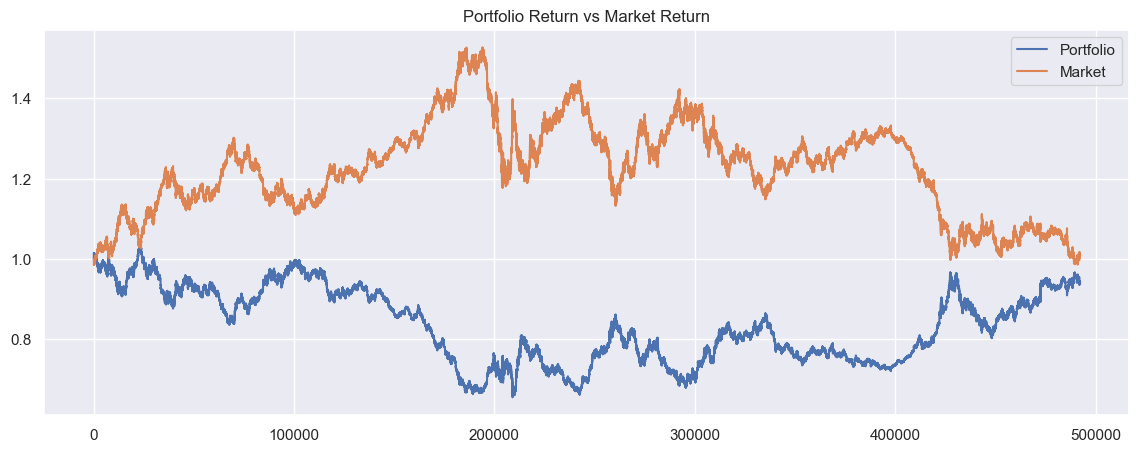

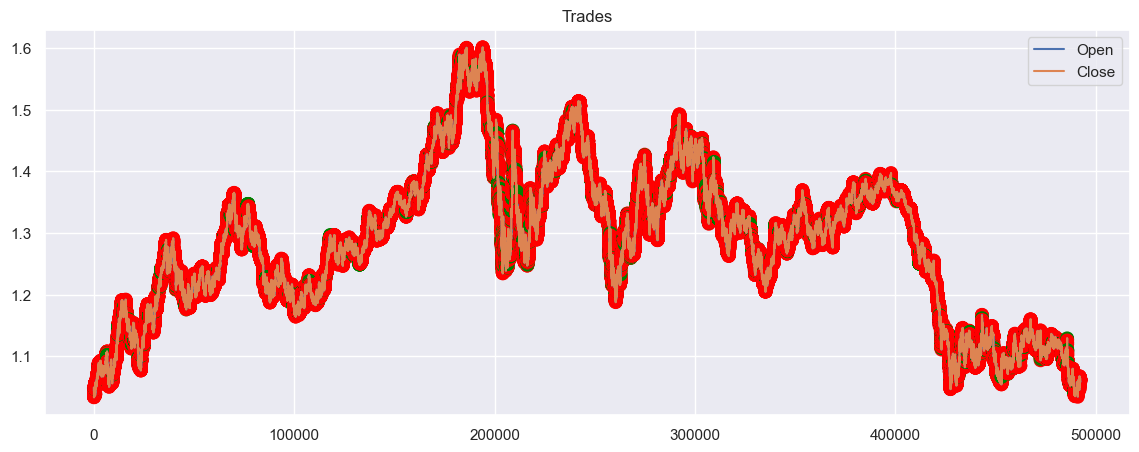

In [63]:
eurusd_env_trn.render()

In [64]:
len([fee for fee in eurusd_env_trn.get_attr('history')[0]['trading_costs'] if fee != 0])

2635

##### Validation set results

In [65]:
eurusd_env_val = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/vecnormalize.pkl',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=True)
    )
)

In [66]:
obs = eurusd_env_val.reset()
for i in tqdm(range(len(target_prices_val) - 2)):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_val.step(action)

100%|███████████████████████████████| 99998/99998 [00:23<00:00, 4282.98it/s]


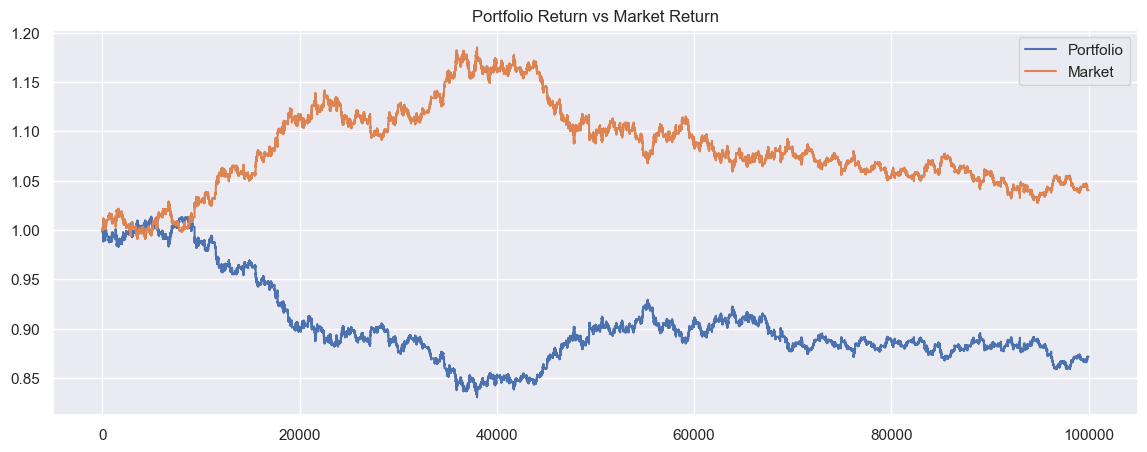

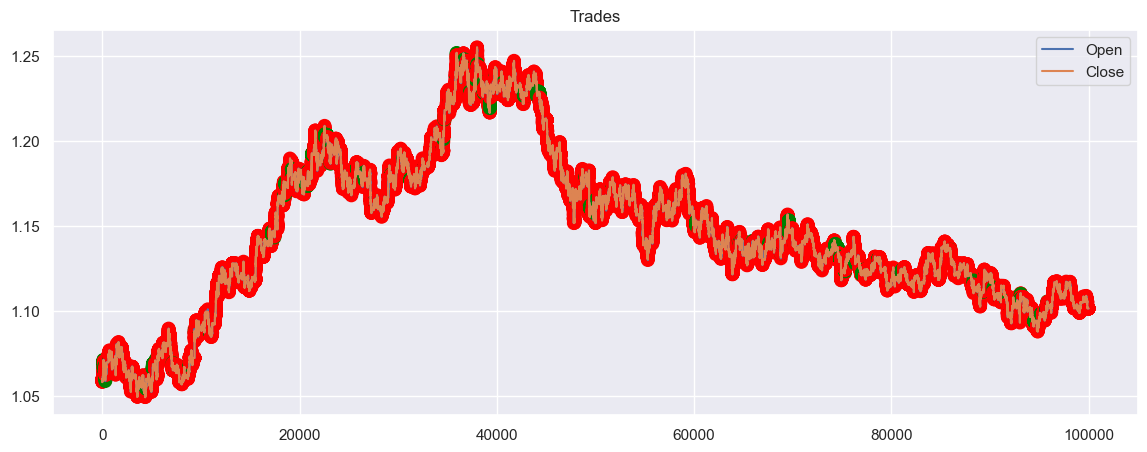

In [67]:
eurusd_env_val.render()

In [68]:
len([fee for fee in eurusd_env_val.get_attr('history')[0]['trading_costs'] if fee != 0])

144

##### Evaluation set results

In [69]:
eurusd_env_eval = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/vecnormalize.pkl',
    make_vec_env(
        ForexEnvBasic,
        env_kwargs=dict(
            target_prices_df=target_prices_eval,
            features_df=basic_features_eval,
            **deepcopy(BASE_ENV_KWARGS)
        )
    )
)

In [70]:
obs = eurusd_env_eval.reset()
for i in tqdm(range(len(target_prices_eval) - 2)):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_eval.step(action)

100%|███████████████████████████████| 99998/99998 [00:22<00:00, 4357.37it/s]


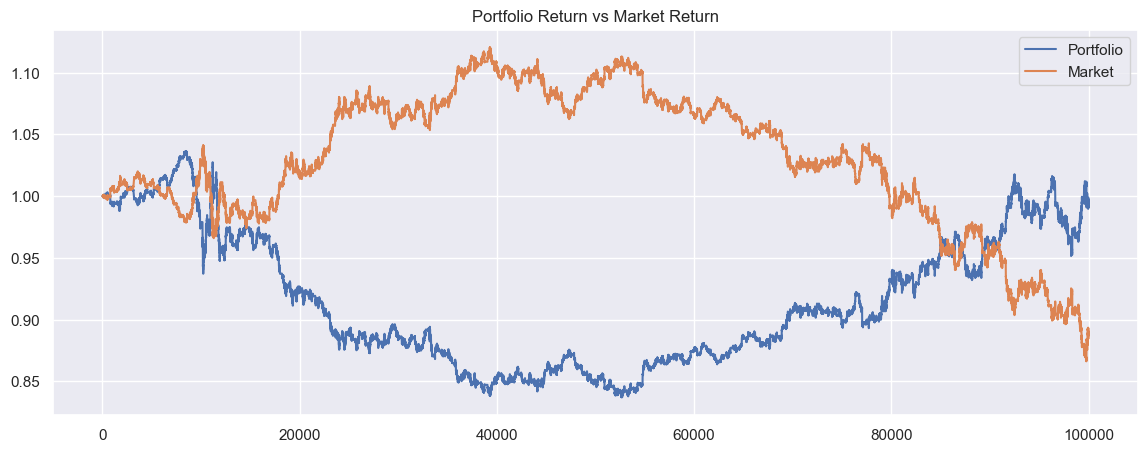

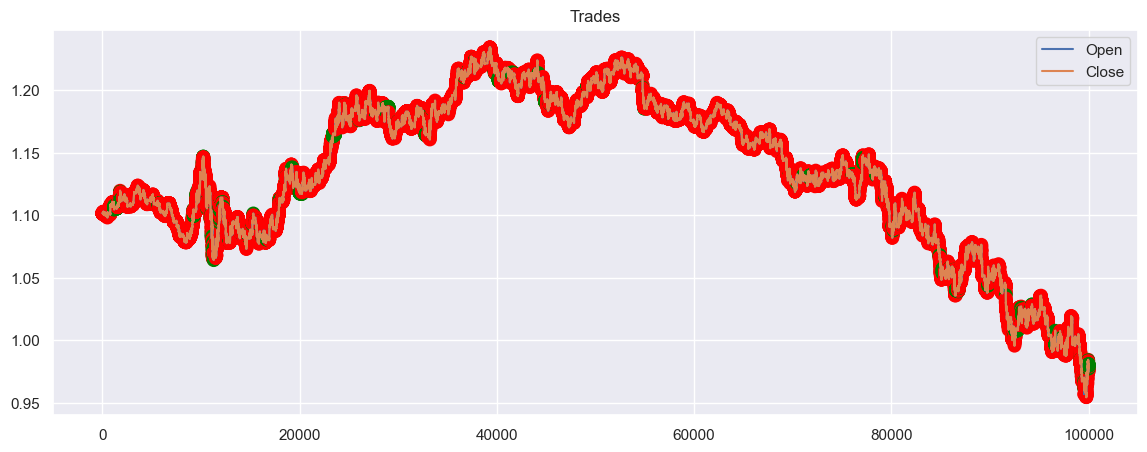

In [71]:
eurusd_env_eval.render()

In [72]:
len([fee for fee in eurusd_env_eval.get_attr('history')[0]['trading_costs'] if fee != 0])

237

#### Best model

In [73]:
_, best_model_path, log_path = get_model_path(0, f'{LOGS_PATH}/training', 'a2c', 'ForexFullEURUSD-v1', load_best=True)

Loading latest experiment, id=1


In [74]:
best_model_vecnormalize = sorted(
    [filename for filename in os.listdir(f'{log_path}/ForexFullEURUSD-v1') if 'vecnormalize_' in filename], 
    key=lambda x: int(x.split('_')[1])
)[-1]

In [75]:
best_model_vecnormalize

'vecnormalize_3700000_steps.pkl'

In [76]:
best_model = A2C.load(best_model_path)

##### Train set results

In [77]:
eurusd_env_trn = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/{best_model_vecnormalize}',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=False)
    )
)

In [78]:
obs = eurusd_env_trn.reset()
for i in tqdm(range(len(target_prices_trn) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_trn.step(action)

100%|█████████████████████████████| 492325/492325 [01:53<00:00, 4322.99it/s]


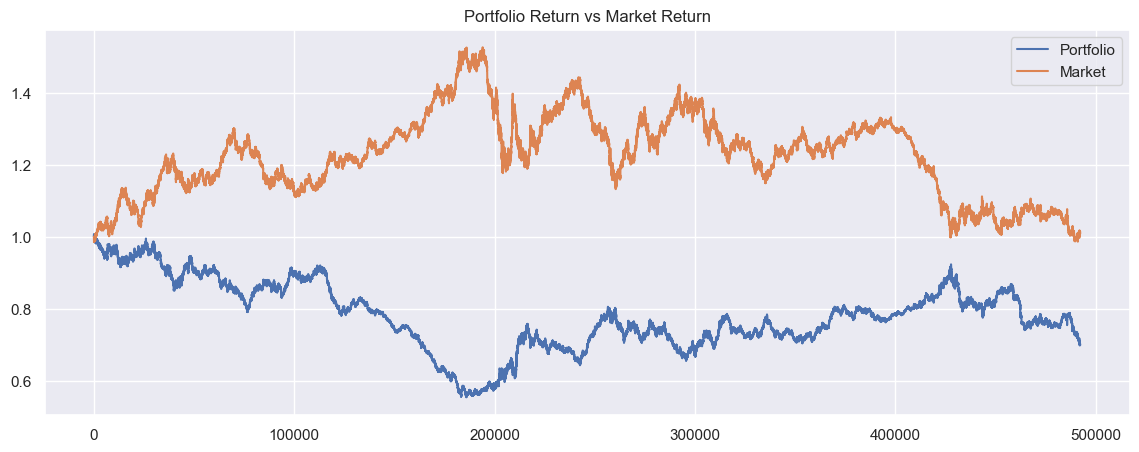

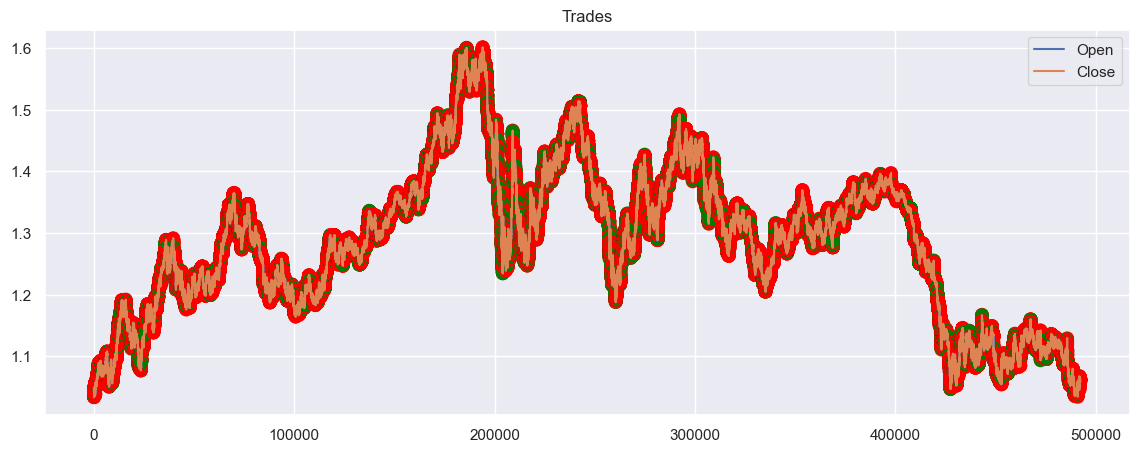

In [80]:
eurusd_env_trn.render()

In [81]:
len([fee for fee in eurusd_env_trn.get_attr('history')[0]['trading_costs'] if fee != 0])

9830

##### Validation set results

In [82]:
eurusd_env_val = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/{best_model_vecnormalize}',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=True)
    )
)

In [83]:
obs = eurusd_env_val.reset()
for i in tqdm(range(len(target_prices_val) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_val.step(action)

100%|███████████████████████████████| 99998/99998 [00:23<00:00, 4231.38it/s]


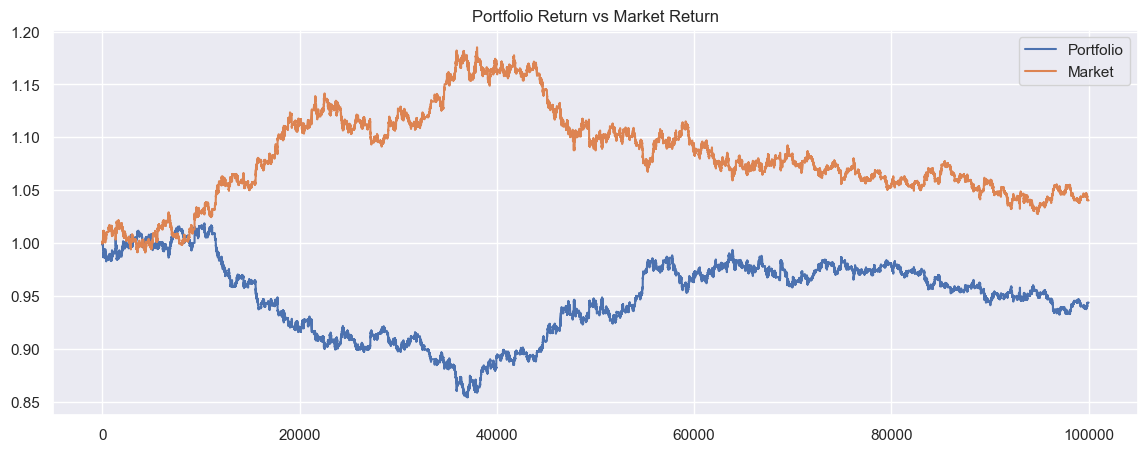

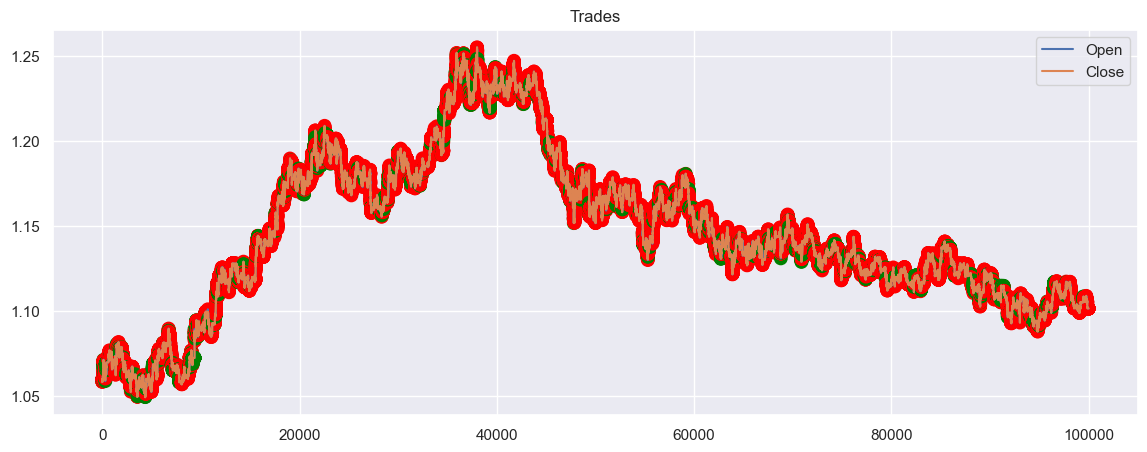

In [85]:
eurusd_env_val.render()

In [84]:
len([fee for fee in eurusd_env_val.get_attr('history')[0]['trading_costs'] if fee != 0])

907

##### Evaluation set results

In [86]:
eurusd_env_eval = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/{best_model_vecnormalize}',
    make_vec_env(
        ForexEnvBasic,
        env_kwargs=dict(
            target_prices_df=target_prices_eval,
            features_df=basic_features_eval,
            **deepcopy(BASE_ENV_KWARGS)
        )
    )
)

In [87]:
obs = eurusd_env_eval.reset()
for i in tqdm(range(len(target_prices_eval) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_eval.step(action)

100%|███████████████████████████████| 99998/99998 [00:22<00:00, 4396.71it/s]


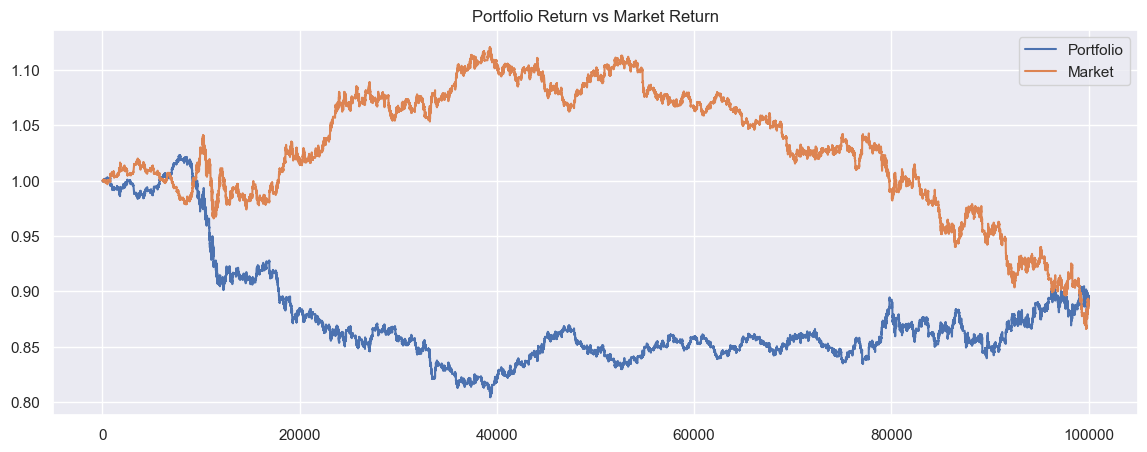

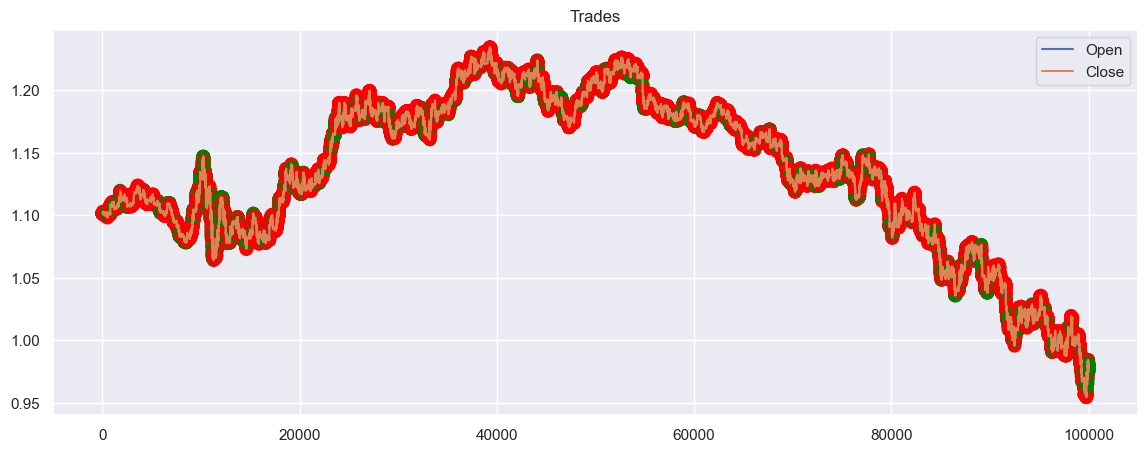

In [88]:
eurusd_env_eval.render() 

In [90]:
len([fee for fee in eurusd_env_eval.get_attr('history')[0]['trading_costs'] if fee != 0])

1264

### PPO

In [89]:
sys.argv = [
    'python', 
    '--algo', 'ppo',
    '--env', 'ForexFullEURUSD-v1',
    '--tensorboard-log', f'{LOGS_PATH}/training/TensorBoard',
    '--n-timesteps', '5000000',
    '--eval-freq', '100000',
    '--eval-episodes', '1',
    '--log-folder', f'{LOGS_PATH}/training',
    '--seed', '604',
    '--verbose', '0',
    '--hyperparams', 'normalize:dict(norm_reward=False)', 'callback:"rl_trading.utils.TextProgressBarCallback"',
    '--conf-file', f'{HYPERPARAMS_PATH}/default/ppo.yml'
]

train()

========== ForexFullEURUSD-v1 ==========
Seed: 604
Loading hyperparameters from: /Users/astepura/Desktop/I-CUREUS/RL-trading/hyperparams/default/ppo.yml
Default hyperparameters for environment (ones being tuned will be overridden):
OrderedDict([('batch_size', 64),
             ('callback', 'rl_trading.utils.TextProgressBarCallback'),
             ('clip_range', 0.2),
             ('ent_coef', 0.0),
             ('gae_lambda', 0.95),
             ('gamma', 0.99),
             ('learning_rate', 0.0003),
             ('max_grad_norm', 0.5),
             ('n_epochs', 10),
             ('n_steps', 2048),
             ('normalize', {'norm_reward': False}),
             ('policy', 'MlpPolicy'),
             ('policy_kwargs',
              'dict( net_arch=[dict(pi=[64, 64], vf=[64, 64])], '
              'activation_fn=nn.Tanh, ortho_init=True )'),
             ('vf_coef', 0.5)])
Log path: /Users/astepura/Desktop/I-CUREUS/RL-trading/logs/training/ppo/ForexFullEURUSD-v1_1


  2%|▌                          | 100047/5000000 [01:00<21:31:33, 63.23it/s]

Eval num_timesteps=100000, episode_reward=-2.18 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


  4%|█                          | 200340/5000000 [02:03<19:04:41, 69.88it/s]

Eval num_timesteps=200000, episode_reward=-1.44 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


  6%|█▌                         | 300395/5000000 [03:04<13:31:39, 96.50it/s]

Eval num_timesteps=300000, episode_reward=-2.22 +/- 0.00
Episode length: 99999.00 +/- 0.00


  8%|██▏                        | 400359/5000000 [04:07<15:41:13, 81.45it/s]

Eval num_timesteps=400000, episode_reward=-1.78 +/- 0.00
Episode length: 99999.00 +/- 0.00


 10%|██▋                        | 500383/5000000 [05:11<14:19:55, 87.21it/s]

Eval num_timesteps=500000, episode_reward=-1.73 +/- 0.00
Episode length: 99999.00 +/- 0.00


 12%|███▏                       | 600001/5000000 [06:11<19:46:31, 61.81it/s]

Eval num_timesteps=600000, episode_reward=-1.97 +/- 0.00
Episode length: 99999.00 +/- 0.00


 14%|███▊                       | 700398/5000000 [07:12<14:01:11, 85.19it/s]

Eval num_timesteps=700000, episode_reward=-1.87 +/- 0.00
Episode length: 99999.00 +/- 0.00


 16%|████▎                      | 800401/5000000 [08:13<12:31:05, 93.19it/s]

Eval num_timesteps=800000, episode_reward=-1.84 +/- 0.00
Episode length: 99999.00 +/- 0.00


 18%|████▊                      | 900373/5000000 [09:16<12:35:48, 90.40it/s]

Eval num_timesteps=900000, episode_reward=-1.92 +/- 0.00
Episode length: 99999.00 +/- 0.00


 20%|█████▏                    | 1000347/5000000 [10:21<13:59:57, 79.36it/s]

Eval num_timesteps=1000000, episode_reward=-2.27 +/- 0.00
Episode length: 99999.00 +/- 0.00


 22%|█████▋                    | 1100370/5000000 [11:29<22:05:32, 49.03it/s]

Eval num_timesteps=1100000, episode_reward=-1.95 +/- 0.00
Episode length: 99999.00 +/- 0.00


 24%|██████▏                   | 1200001/5000000 [12:29<15:39:27, 67.41it/s]

Eval num_timesteps=1200000, episode_reward=-2.00 +/- 0.00
Episode length: 99999.00 +/- 0.00


 26%|██████▊                   | 1300379/5000000 [13:33<13:33:09, 75.83it/s]

Eval num_timesteps=1300000, episode_reward=-2.37 +/- 0.00
Episode length: 99999.00 +/- 0.00


 28%|███████▎                  | 1400652/5000000 [14:32<10:02:37, 99.55it/s]

Eval num_timesteps=1400000, episode_reward=-2.25 +/- 0.00
Episode length: 99999.00 +/- 0.00


 30%|███████▊                  | 1500391/5000000 [15:33<11:55:52, 81.48it/s]

Eval num_timesteps=1500000, episode_reward=-2.12 +/- 0.00
Episode length: 99999.00 +/- 0.00


 32%|████████▎                 | 1600336/5000000 [16:35<13:17:16, 71.07it/s]

Eval num_timesteps=1600000, episode_reward=-1.79 +/- 0.00
Episode length: 99999.00 +/- 0.00


 34%|████████▊                 | 1700392/5000000 [17:38<13:40:23, 67.03it/s]

Eval num_timesteps=1700000, episode_reward=-1.87 +/- 0.00
Episode length: 99999.00 +/- 0.00


 36%|█████████▎                | 1800070/5000000 [18:42<13:57:07, 63.71it/s]

Eval num_timesteps=1800000, episode_reward=-2.06 +/- 0.00
Episode length: 99999.00 +/- 0.00


 38%|█████████▉                | 1900336/5000000 [19:46<12:02:25, 71.51it/s]

Eval num_timesteps=1900000, episode_reward=-1.77 +/- 0.00
Episode length: 99999.00 +/- 0.00


 40%|██████████▍               | 2000286/5000000 [20:51<11:01:17, 75.60it/s]

Eval num_timesteps=2000000, episode_reward=-2.18 +/- 0.00
Episode length: 99999.00 +/- 0.00


 42%|██████████▉               | 2100383/5000000 [21:54<10:16:53, 78.34it/s]

Eval num_timesteps=2100000, episode_reward=-2.54 +/- 0.00
Episode length: 99999.00 +/- 0.00


 44%|███████████▉               | 2200373/5000000 [22:53<9:36:29, 80.94it/s]

Eval num_timesteps=2200000, episode_reward=-2.35 +/- 0.00
Episode length: 99999.00 +/- 0.00


 46%|████████████▍              | 2300346/5000000 [23:53<8:27:12, 88.71it/s]

Eval num_timesteps=2300000, episode_reward=-2.29 +/- 0.00
Episode length: 99999.00 +/- 0.00


 48%|████████████▍             | 2400001/5000000 [24:58<14:36:25, 49.44it/s]

Eval num_timesteps=2400000, episode_reward=-2.08 +/- 0.00
Episode length: 99999.00 +/- 0.00


 50%|█████████████             | 2500374/5000000 [26:04<10:10:40, 68.22it/s]

Eval num_timesteps=2500000, episode_reward=-2.04 +/- 0.00
Episode length: 99999.00 +/- 0.00


 52%|██████████████             | 2600383/5000000 [27:11<8:40:02, 76.90it/s]

Eval num_timesteps=2600000, episode_reward=-2.12 +/- 0.00
Episode length: 99999.00 +/- 0.00


 54%|██████████████▌            | 2700317/5000000 [28:15<7:47:54, 81.91it/s]

Eval num_timesteps=2700000, episode_reward=-2.24 +/- 0.00
Episode length: 99999.00 +/- 0.00


 56%|███████████████            | 2800380/5000000 [29:16<7:05:25, 86.17it/s]

Eval num_timesteps=2800000, episode_reward=-1.81 +/- 0.00
Episode length: 99999.00 +/- 0.00


 58%|███████████████▋           | 2900339/5000000 [30:19<7:46:13, 75.06it/s]

Eval num_timesteps=2900000, episode_reward=-2.14 +/- 0.00
Episode length: 99999.00 +/- 0.00


 60%|███████████████▌          | 3000001/5000000 [31:20<10:00:49, 55.48it/s]

Eval num_timesteps=3000000, episode_reward=-2.12 +/- 0.00
Episode length: 99999.00 +/- 0.00


 62%|████████████████▋          | 3100534/5000000 [32:20<5:50:44, 90.26it/s]

Eval num_timesteps=3100000, episode_reward=-2.35 +/- 0.00
Episode length: 99999.00 +/- 0.00


 64%|█████████████████▎         | 3200359/5000000 [33:20<5:57:36, 83.87it/s]

Eval num_timesteps=3200000, episode_reward=-2.07 +/- 0.00
Episode length: 99999.00 +/- 0.00


 66%|█████████████████▊         | 3300389/5000000 [34:19<5:22:40, 87.79it/s]

Eval num_timesteps=3300000, episode_reward=-2.09 +/- 0.00
Episode length: 99999.00 +/- 0.00


 68%|██████████████████▎        | 3400394/5000000 [35:19<4:47:09, 92.84it/s]

Eval num_timesteps=3400000, episode_reward=-2.15 +/- 0.00
Episode length: 99999.00 +/- 0.00


 70%|██████████████████▉        | 3500001/5000000 [36:18<8:07:30, 51.28it/s]

Eval num_timesteps=3500000, episode_reward=-2.27 +/- 0.00
Episode length: 99999.00 +/- 0.00


 72%|███████████████████▍       | 3600001/5000000 [37:19<6:24:35, 60.67it/s]

Eval num_timesteps=3600000, episode_reward=-2.10 +/- 0.00
Episode length: 99999.00 +/- 0.00


 74%|███████████████████▉       | 3700380/5000000 [38:23<5:09:06, 70.07it/s]

Eval num_timesteps=3700000, episode_reward=-2.29 +/- 0.00
Episode length: 99999.00 +/- 0.00


 76%|████████████████████▌      | 3800575/5000000 [39:22<3:27:23, 96.39it/s]

Eval num_timesteps=3800000, episode_reward=-2.06 +/- 0.00
Episode length: 99999.00 +/- 0.00


 78%|█████████████████████      | 3900516/5000000 [40:21<3:08:30, 97.21it/s]

Eval num_timesteps=3900000, episode_reward=-2.12 +/- 0.00
Episode length: 99999.00 +/- 0.00


 80%|█████████████████████▌     | 4000393/5000000 [41:20<3:00:17, 92.41it/s]

Eval num_timesteps=4000000, episode_reward=-2.08 +/- 0.00
Episode length: 99999.00 +/- 0.00


 82%|██████████████████████▏    | 4100001/5000000 [42:21<4:18:35, 58.01it/s]

Eval num_timesteps=4100000, episode_reward=-2.36 +/- 0.00
Episode length: 99999.00 +/- 0.00


 84%|██████████████████████▋    | 4200343/5000000 [43:22<2:20:49, 94.64it/s]

Eval num_timesteps=4200000, episode_reward=-2.47 +/- 0.00
Episode length: 99999.00 +/- 0.00


 86%|███████████████████████▏   | 4300475/5000000 [44:23<2:23:14, 81.40it/s]

Eval num_timesteps=4300000, episode_reward=-2.43 +/- 0.00
Episode length: 99999.00 +/- 0.00


 88%|███████████████████████▊   | 4400388/5000000 [45:26<1:49:57, 90.88it/s]

Eval num_timesteps=4400000, episode_reward=-2.30 +/- 0.00
Episode length: 99999.00 +/- 0.00


 90%|████████████████████████▎  | 4500378/5000000 [46:27<1:28:07, 94.49it/s]

Eval num_timesteps=4500000, episode_reward=-2.23 +/- 0.00
Episode length: 99999.00 +/- 0.00


 92%|████████████████████████▊  | 4600381/5000000 [47:28<1:13:19, 90.84it/s]

Eval num_timesteps=4600000, episode_reward=-2.27 +/- 0.00
Episode length: 99999.00 +/- 0.00


 94%|█████████████████████████▍ | 4700001/5000000 [48:27<1:35:55, 52.12it/s]

Eval num_timesteps=4700000, episode_reward=-2.49 +/- 0.00
Episode length: 99999.00 +/- 0.00


 96%|███████████████████████████▊ | 4800401/5000000 [49:26<33:22, 99.68it/s]

Eval num_timesteps=4800000, episode_reward=-2.38 +/- 0.00
Episode length: 99999.00 +/- 0.00


 98%|████████████████████████████▍| 4900390/5000000 [50:25<17:00, 97.60it/s]

Eval num_timesteps=4900000, episode_reward=-2.59 +/- 0.00
Episode length: 99999.00 +/- 0.00


5000392it [51:24, 88.14it/s]                                                

Eval num_timesteps=5000000, episode_reward=-2.27 +/- 0.00
Episode length: 99999.00 +/- 0.00


5001216it [51:25, 1620.97it/s]

Saving to /Users/astepura/Desktop/I-CUREUS/RL-trading/logs/training/ppo/ForexFullEURUSD-v1_1


#### Final model

In [91]:
_, model_path, log_path = get_model_path(0, f'{LOGS_PATH}/training', 'ppo', 'ForexFullEURUSD-v1')

Loading latest experiment, id=1


In [92]:
model = PPO.load(model_path)

##### Train set results

In [93]:
eurusd_env_trn = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/vecnormalize.pkl',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=False)
    )
)

In [94]:
obs = eurusd_env_trn.reset()
for i in tqdm(range(len(target_prices_trn) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_trn.step(action)

100%|█████████████████████████████| 492325/492325 [01:50<00:00, 4440.22it/s]


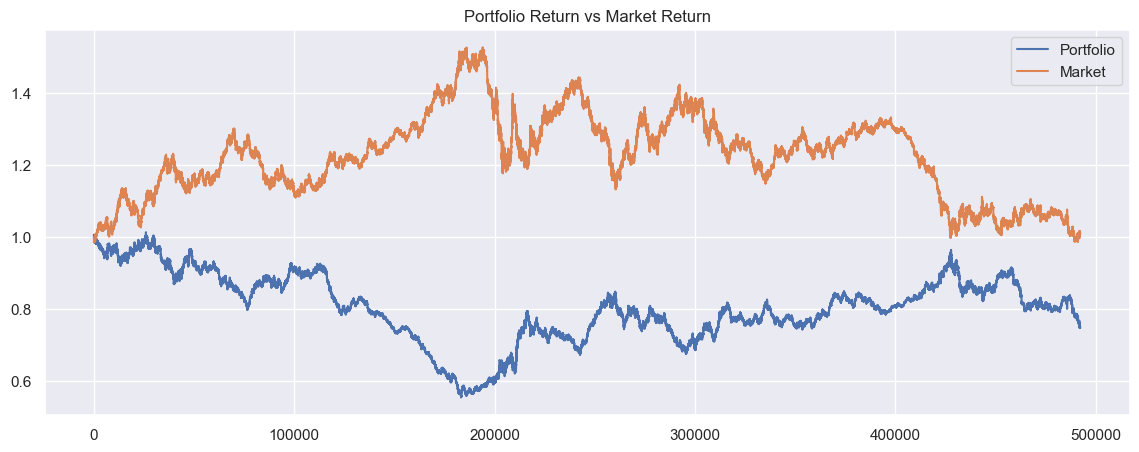

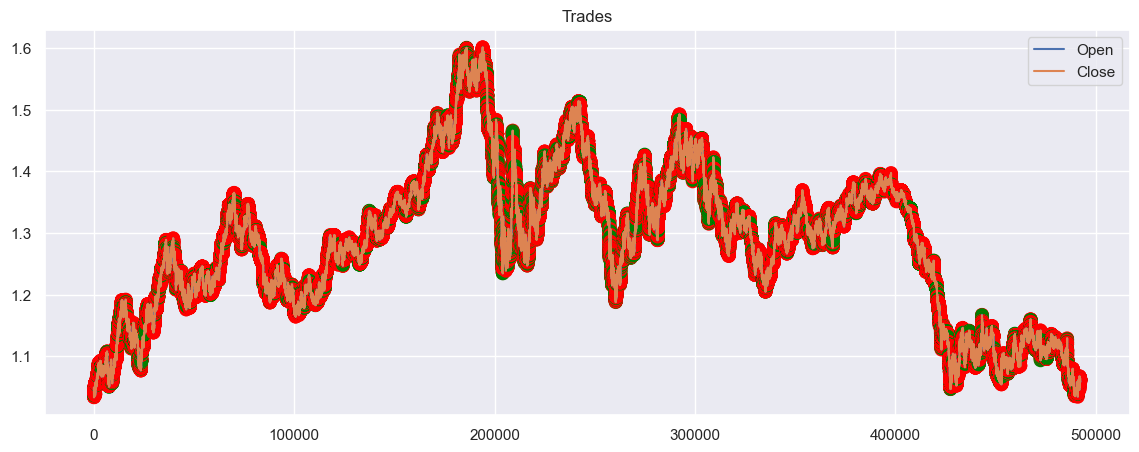

In [95]:
eurusd_env_trn.render()

In [96]:
len([fee for fee in eurusd_env_trn.get_attr('history')[0]['trading_costs'] if fee != 0])

9813

##### Validation set results

In [97]:
eurusd_env_val = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/vecnormalize.pkl',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=True)
    )
)

In [98]:
obs = eurusd_env_val.reset()
for i in tqdm(range(len(target_prices_val) - 2)):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_val.step(action)

100%|███████████████████████████████| 99998/99998 [00:22<00:00, 4448.81it/s]


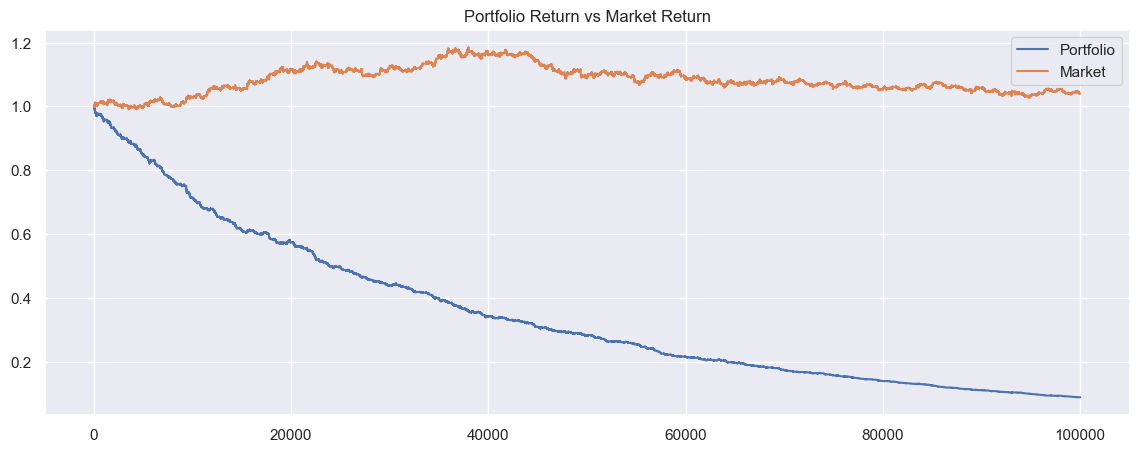

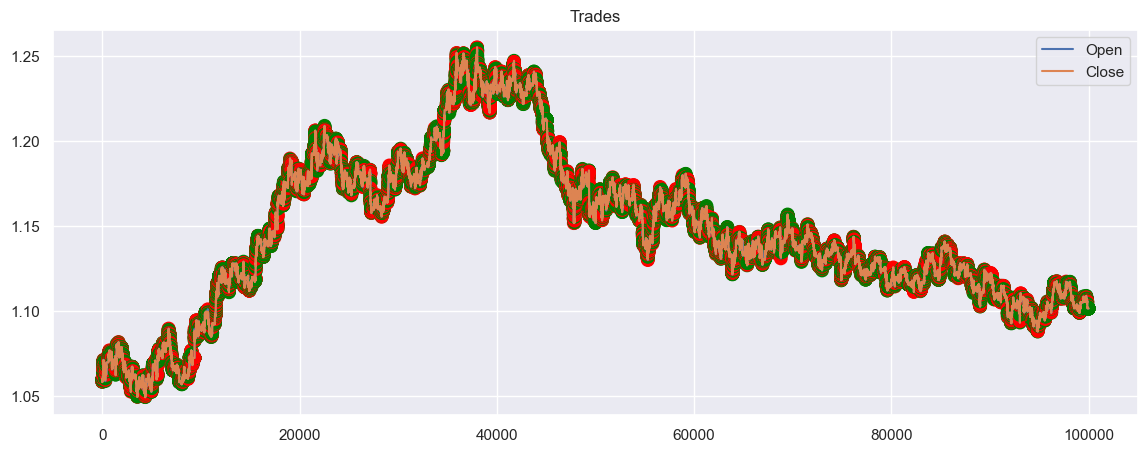

In [101]:
eurusd_env_val.render()

In [102]:
len([fee for fee in eurusd_env_val.get_attr('history')[0]['trading_costs'] if fee != 0])

13462

##### Evaluation set results

In [103]:
eurusd_env_eval = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/vecnormalize.pkl',
    make_vec_env(
        ForexEnvBasic,
        env_kwargs=dict(
            target_prices_df=target_prices_eval,
            features_df=basic_features_eval,
            **deepcopy(BASE_ENV_KWARGS)
        )
    )
)

In [104]:
obs = eurusd_env_eval.reset()
for i in tqdm(range(len(target_prices_eval) - 2)):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_eval.step(action)

100%|███████████████████████████████| 99998/99998 [00:23<00:00, 4253.96it/s]


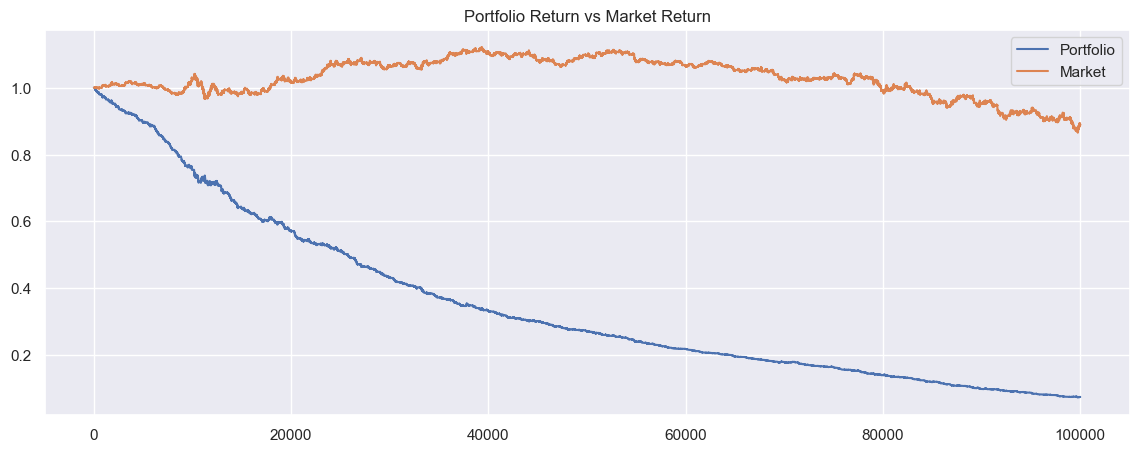

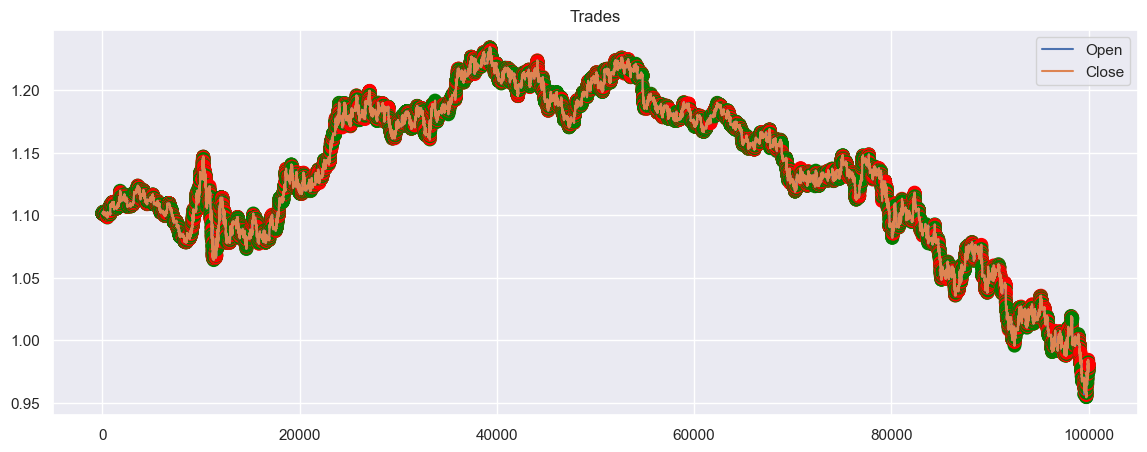

In [107]:
eurusd_env_eval.render()

In [108]:
len([fee for fee in eurusd_env_eval.get_attr('history')[0]['trading_costs'] if fee != 0])

13776

#### Best model

In [109]:
_, best_model_path, log_path = get_model_path(0, f'{LOGS_PATH}/training', 'ppo', 'ForexFullEURUSD-v1', load_best=True)

Loading latest experiment, id=1


In [110]:
best_model_vecnormalize = sorted(
    [filename for filename in os.listdir(f'{log_path}/ForexFullEURUSD-v1') if 'vecnormalize_' in filename], 
    key=lambda x: int(x.split('_')[1])
)[-1]

In [112]:
best_model_vecnormalize

'vecnormalize_200000_steps.pkl'

In [113]:
best_model = PPO.load(best_model_path)

##### Train set results

In [114]:
eurusd_env_trn = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/{best_model_vecnormalize}',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=False)
    )
)

In [115]:
obs = eurusd_env_trn.reset()
for i in tqdm(range(len(target_prices_trn) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_trn.step(action)

100%|█████████████████████████████| 492325/492325 [01:51<00:00, 4399.71it/s]


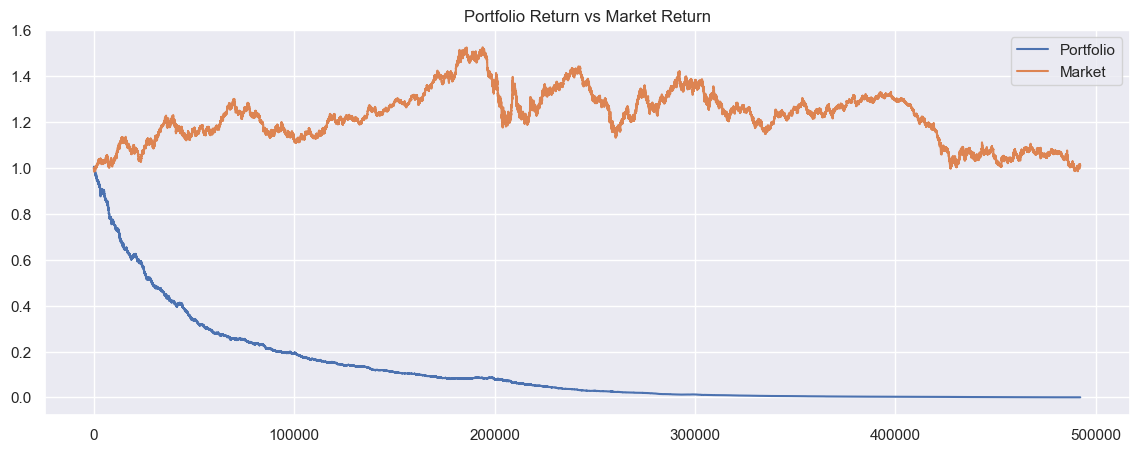

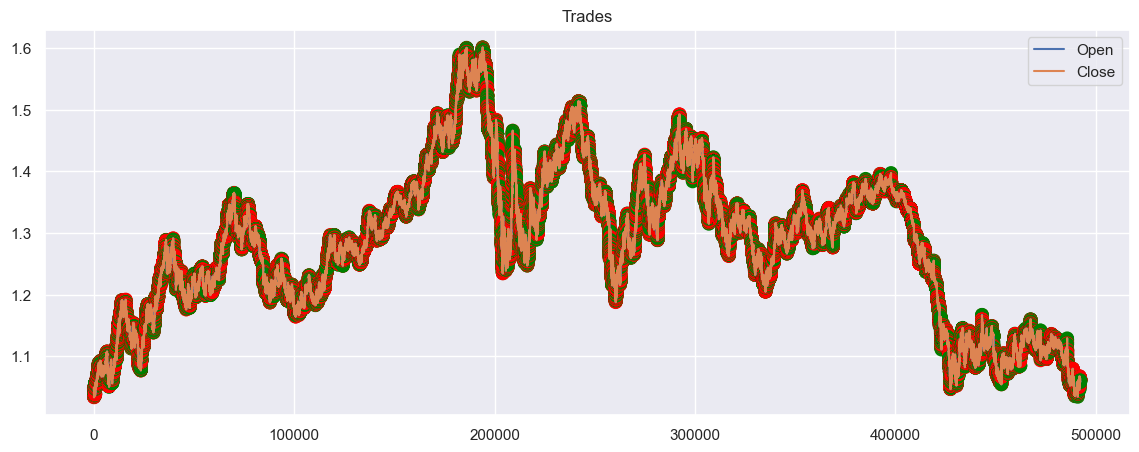

In [116]:
eurusd_env_trn.render()

In [117]:
len([fee for fee in eurusd_env_trn.get_attr('history')[0]['trading_costs'] if fee != 0])

52992

##### Validation set results

In [118]:
eurusd_env_val = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/{best_model_vecnormalize}',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=True)
    )
)

In [119]:
obs = eurusd_env_val.reset()
for i in tqdm(range(len(target_prices_val) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_val.step(action)

100%|███████████████████████████████| 99998/99998 [00:25<00:00, 3957.69it/s]


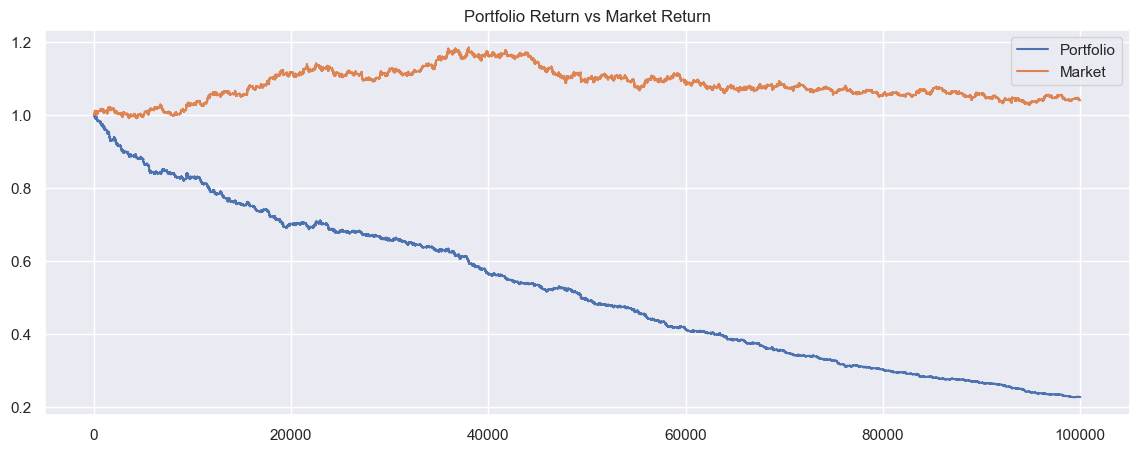

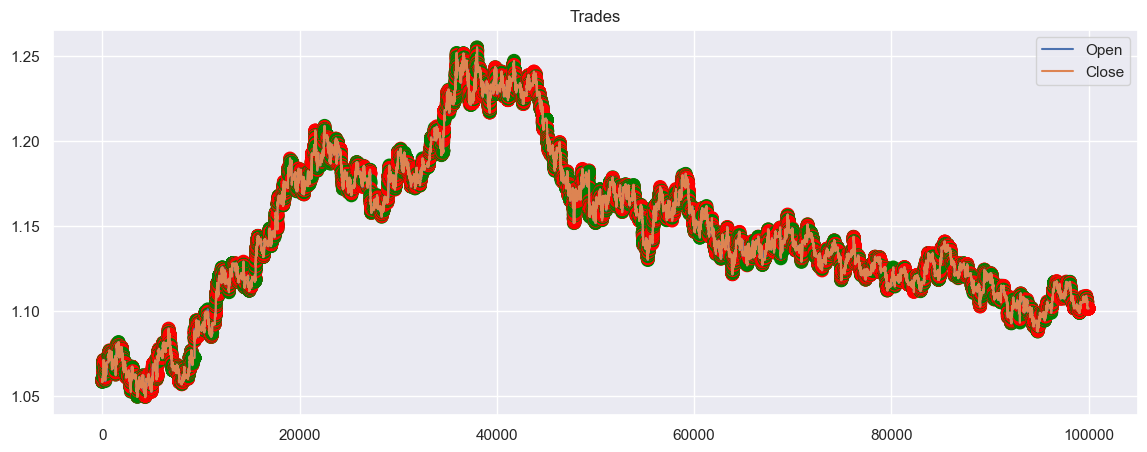

In [120]:
eurusd_env_val.render()

In [125]:
len([fee for fee in eurusd_env_val.get_attr('history')[0]['trading_costs'] if fee != 0])

9325

##### Evaluation set results

In [121]:
eurusd_env_eval = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/{best_model_vecnormalize}',
    make_vec_env(
        ForexEnvBasic,
        env_kwargs=dict(
            target_prices_df=target_prices_eval,
            features_df=basic_features_eval,
            **deepcopy(BASE_ENV_KWARGS)
        )
    )
)

In [122]:
obs = eurusd_env_eval.reset()
for i in tqdm(range(len(target_prices_eval) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_eval.step(action)

100%|███████████████████████████████| 99998/99998 [00:23<00:00, 4331.05it/s]


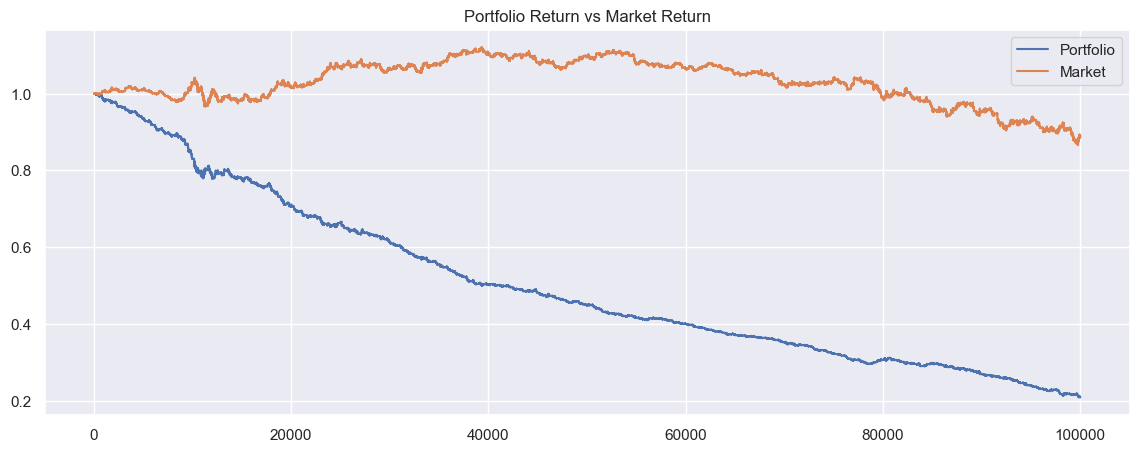

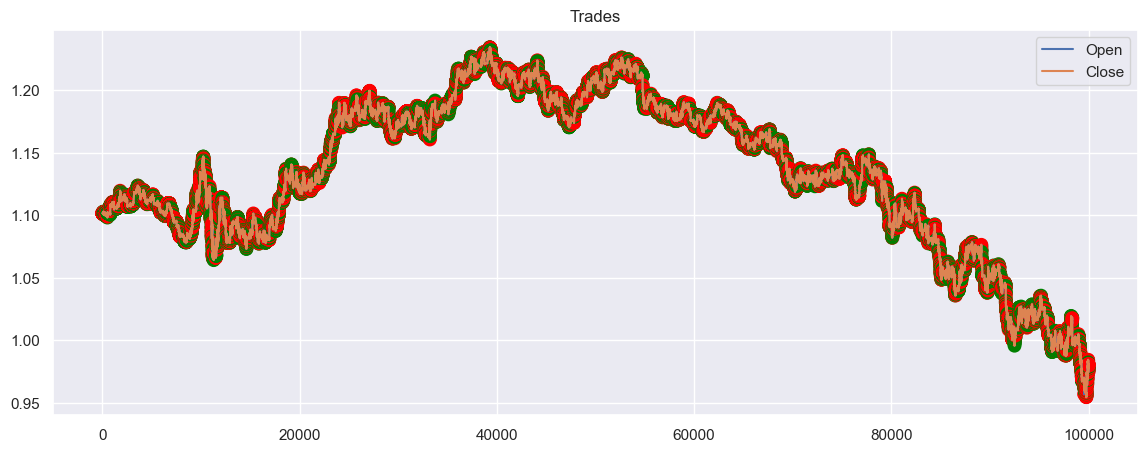

In [123]:
eurusd_env_eval.render()

In [124]:
len([fee for fee in eurusd_env_eval.get_attr('history')[0]['trading_costs'] if fee != 0])

9600

## 2 actions, basic features, running normalization, random short episodes environment

In [18]:
def create_full_eurusd_env_v2(eval):
    return create_eurusd_env(
        eval,
        target_prices_trn,
        target_prices_val,
        basic_features_trn,
        basic_features_val,
        BASE_ENV_KWARGS,
        trn_wrappers={RandomEpisodeForexWrapper: dict(episode_length=1000)}
    )

In [19]:
register(
    'ForexFullEURUSD-v2',
    entry_point=create_full_eurusd_env_v2
)

### DQN

In [20]:
sys.argv = [
    'python', 
    '--algo', 'dqn',
    '--env', 'ForexFullEURUSD-v2',
    '--tensorboard-log', f'{LOGS_PATH}/training/TensorBoard',
    '--n-timesteps', '5000000',
    '--eval-freq', '100000',
    '--eval-episodes', '1',
    '--log-folder', f'{LOGS_PATH}/training',
    '--seed', '604',
    '--verbose', '0',
    '--hyperparams', 'normalize:dict(norm_reward=False)', 'callback:"rl_trading.utils.TextProgressBarCallback"',
    '--conf-file', f'{HYPERPARAMS_PATH}/default/dqn.yml'
]

train()

========== ForexFullEURUSD-v2 ==========
Seed: 604
Loading hyperparameters from: /Users/astepura/Desktop/I-CUREUS/RL-trading/hyperparams/default/dqn.yml
Default hyperparameters for environment (ones being tuned will be overridden):
OrderedDict([('batch_size', 32),
             ('buffer_size', 1000000),
             ('callback', 'rl_trading.utils.TextProgressBarCallback'),
             ('exploration_final_eps', 0.05),
             ('exploration_fraction', 0.1),
             ('gamma', 0.99),
             ('gradient_steps', 1),
             ('learning_rate', 0.0001),
             ('learning_starts', 50000),
             ('normalize', {'norm_reward': False}),
             ('policy', 'MlpPolicy'),
             ('policy_kwargs', 'dict( net_arch=[64, 64] )'),
             ('target_update_interval', 10000),
             ('train_freq', 4)])
Log path: /Users/astepura/Desktop/I-CUREUS/RL-trading/logs/training/dqn/ForexFullEURUSD-v2_1


  2%|▊                                        | 100435/5000000 [00:37<13:50:48, 98.29it/s]

Eval num_timesteps=100000, episode_reward=-3.39 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


  4%|█▋                                       | 200301/5000000 [01:26<13:47:43, 96.64it/s]

Eval num_timesteps=200000, episode_reward=-2.24 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


  6%|██▌                                       | 300000/5000000 [02:02<26:25, 2963.43it/s]

Eval num_timesteps=300000, episode_reward=-2.40 +/- 0.00
Episode length: 99999.00 +/- 0.00


  8%|███▎                                     | 400220/5000000 [03:08<16:46:31, 76.17it/s]

Eval num_timesteps=400000, episode_reward=-2.43 +/- 0.00
Episode length: 99999.00 +/- 0.00


 10%|████                                     | 500194/5000000 [04:00<19:33:59, 63.88it/s]

Eval num_timesteps=500000, episode_reward=-2.09 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 12%|████▉                                    | 600206/5000000 [04:53<15:40:55, 77.93it/s]

Eval num_timesteps=600000, episode_reward=-1.73 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 14%|█████▋                                   | 700305/5000000 [05:44<13:53:52, 85.94it/s]

Eval num_timesteps=700000, episode_reward=-2.78 +/- 0.00
Episode length: 99999.00 +/- 0.00


 16%|██████▌                                  | 800341/5000000 [06:35<13:39:16, 85.44it/s]

Eval num_timesteps=800000, episode_reward=-0.62 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 18%|███████▍                                 | 900421/5000000 [07:30<14:27:35, 78.75it/s]

Eval num_timesteps=900000, episode_reward=-3.10 +/- 0.00
Episode length: 99999.00 +/- 0.00


 20%|████████                                | 1000233/5000000 [08:22<13:07:57, 84.60it/s]

Eval num_timesteps=1000000, episode_reward=-3.00 +/- 0.00
Episode length: 99999.00 +/- 0.00


 22%|████████▊                               | 1100277/5000000 [09:14<12:46:35, 84.79it/s]

Eval num_timesteps=1100000, episode_reward=-1.92 +/- 0.00
Episode length: 99999.00 +/- 0.00


 24%|█████████▌                              | 1200319/5000000 [10:06<13:03:59, 80.78it/s]

Eval num_timesteps=1200000, episode_reward=-2.40 +/- 0.00
Episode length: 99999.00 +/- 0.00


 26%|██████████▍                             | 1300375/5000000 [11:00<13:40:11, 75.18it/s]

Eval num_timesteps=1300000, episode_reward=-2.09 +/- 0.00
Episode length: 99999.00 +/- 0.00


 28%|███████████▏                            | 1400233/5000000 [11:51<13:04:08, 76.51it/s]

Eval num_timesteps=1400000, episode_reward=-1.53 +/- 0.00
Episode length: 99999.00 +/- 0.00


 30%|████████████                            | 1500252/5000000 [12:45<16:06:19, 60.36it/s]

Eval num_timesteps=1500000, episode_reward=-0.63 +/- 0.00
Episode length: 99999.00 +/- 0.00


 32%|████████████▊                           | 1600221/5000000 [13:38<12:18:28, 76.73it/s]

Eval num_timesteps=1600000, episode_reward=-1.38 +/- 0.00
Episode length: 99999.00 +/- 0.00


 34%|█████████████▌                          | 1700239/5000000 [14:31<11:17:05, 81.22it/s]

Eval num_timesteps=1700000, episode_reward=-1.22 +/- 0.00
Episode length: 99999.00 +/- 0.00


 36%|██████████████▍                         | 1800189/5000000 [15:23<12:10:53, 72.97it/s]

Eval num_timesteps=1800000, episode_reward=0.02 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 38%|███████████████▏                        | 1900255/5000000 [16:17<11:24:44, 75.45it/s]

Eval num_timesteps=1900000, episode_reward=-0.06 +/- 0.00
Episode length: 99999.00 +/- 0.00


 40%|████████████████                        | 2000164/5000000 [17:10<13:59:46, 59.54it/s]

Eval num_timesteps=2000000, episode_reward=-0.46 +/- 0.00
Episode length: 99999.00 +/- 0.00


 42%|████████████████▊                       | 2100093/5000000 [18:09<15:17:43, 52.66it/s]

Eval num_timesteps=2100000, episode_reward=-0.48 +/- 0.00
Episode length: 99999.00 +/- 0.00


 44%|█████████████████▌                      | 2200171/5000000 [19:05<12:08:38, 64.04it/s]

Eval num_timesteps=2200000, episode_reward=-0.46 +/- 0.00
Episode length: 99999.00 +/- 0.00


 46%|██████████████████▍                     | 2300223/5000000 [19:59<13:15:04, 56.59it/s]

Eval num_timesteps=2300000, episode_reward=-0.79 +/- 0.00
Episode length: 99999.00 +/- 0.00


 48%|███████████████████▏                    | 2400145/5000000 [20:57<11:09:22, 64.73it/s]

Eval num_timesteps=2400000, episode_reward=-0.09 +/- 0.00
Episode length: 99999.00 +/- 0.00


 50%|████████████████████▌                    | 2500169/5000000 [21:51<9:57:58, 69.68it/s]

Eval num_timesteps=2500000, episode_reward=-0.25 +/- 0.00
Episode length: 99999.00 +/- 0.00


 52%|████████████████████▊                   | 2600162/5000000 [22:45<12:45:25, 52.26it/s]

Eval num_timesteps=2600000, episode_reward=-0.28 +/- 0.00
Episode length: 99999.00 +/- 0.00


 54%|█████████████████████▌                  | 2700184/5000000 [23:39<10:39:03, 59.98it/s]

Eval num_timesteps=2700000, episode_reward=-0.11 +/- 0.00
Episode length: 99999.00 +/- 0.00


 56%|██████████████████████▉                  | 2800237/5000000 [24:33<9:05:05, 67.26it/s]

Eval num_timesteps=2800000, episode_reward=0.00 +/- 0.00
Episode length: 99999.00 +/- 0.00


 58%|███████████████████████▊                 | 2900357/5000000 [25:27<6:56:10, 84.09it/s]

Eval num_timesteps=2900000, episode_reward=-0.23 +/- 0.00
Episode length: 99999.00 +/- 0.00


 60%|████████████████████████▌                | 3000133/5000000 [26:21<8:15:15, 67.30it/s]

Eval num_timesteps=3000000, episode_reward=-0.36 +/- 0.00
Episode length: 99999.00 +/- 0.00


 62%|█████████████████████████▍               | 3100208/5000000 [27:14<7:48:08, 67.63it/s]

Eval num_timesteps=3100000, episode_reward=0.03 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 64%|██████████████████████████▏              | 3200271/5000000 [28:08<6:05:50, 81.99it/s]

Eval num_timesteps=3200000, episode_reward=-0.70 +/- 0.00
Episode length: 99999.00 +/- 0.00


 66%|███████████████████████████              | 3300169/5000000 [29:03<7:16:09, 64.96it/s]

Eval num_timesteps=3300000, episode_reward=0.01 +/- 0.00
Episode length: 99999.00 +/- 0.00


 68%|███████████████████████████▉             | 3400341/5000000 [29:56<5:09:59, 86.00it/s]

Eval num_timesteps=3400000, episode_reward=-0.02 +/- 0.00
Episode length: 99999.00 +/- 0.00


 70%|████████████████████████████▋            | 3500210/5000000 [30:49<6:55:23, 60.18it/s]

Eval num_timesteps=3500000, episode_reward=-0.09 +/- 0.00
Episode length: 99999.00 +/- 0.00


 72%|█████████████████████████████▌           | 3600217/5000000 [31:42<5:05:02, 76.48it/s]

Eval num_timesteps=3600000, episode_reward=0.03 +/- 0.00
Episode length: 99999.00 +/- 0.00


 74%|██████████████████████████████▎          | 3700181/5000000 [32:34<5:39:34, 63.80it/s]

Eval num_timesteps=3700000, episode_reward=0.03 +/- 0.00
Episode length: 99999.00 +/- 0.00


 76%|███████████████████████████████▏         | 3800205/5000000 [33:31<4:36:51, 72.23it/s]

Eval num_timesteps=3800000, episode_reward=0.02 +/- 0.00
Episode length: 99999.00 +/- 0.00


 78%|███████████████████████████████▉         | 3900285/5000000 [34:26<3:55:17, 77.90it/s]

Eval num_timesteps=3900000, episode_reward=0.02 +/- 0.00
Episode length: 99999.00 +/- 0.00


 80%|████████████████████████████████▊        | 4000205/5000000 [35:21<3:36:51, 76.84it/s]

Eval num_timesteps=4000000, episode_reward=0.01 +/- 0.00
Episode length: 99999.00 +/- 0.00


 82%|█████████████████████████████████▌       | 4100171/5000000 [36:15<3:55:36, 63.65it/s]

Eval num_timesteps=4100000, episode_reward=-0.05 +/- 0.00
Episode length: 99999.00 +/- 0.00


 84%|██████████████████████████████████▍      | 4200281/5000000 [37:09<2:42:40, 81.93it/s]

Eval num_timesteps=4200000, episode_reward=0.04 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 86%|███████████████████████████████████▎     | 4300226/5000000 [38:03<2:39:42, 73.03it/s]

Eval num_timesteps=4300000, episode_reward=-0.07 +/- 0.00
Episode length: 99999.00 +/- 0.00


 88%|████████████████████████████████████     | 4400169/5000000 [38:56<2:10:17, 76.73it/s]

Eval num_timesteps=4400000, episode_reward=0.01 +/- 0.00
Episode length: 99999.00 +/- 0.00


 90%|████████████████████████████████████▉    | 4500313/5000000 [39:49<1:41:22, 82.16it/s]

Eval num_timesteps=4500000, episode_reward=-0.06 +/- 0.00
Episode length: 99999.00 +/- 0.00


 92%|█████████████████████████████████████▋   | 4600291/5000000 [40:41<1:15:14, 88.55it/s]

Eval num_timesteps=4600000, episode_reward=-0.09 +/- 0.00
Episode length: 99999.00 +/- 0.00


 94%|████████████████████████████████████████▍  | 4700297/5000000 [41:35<58:55, 84.77it/s]

Eval num_timesteps=4700000, episode_reward=-0.10 +/- 0.00
Episode length: 99999.00 +/- 0.00


 96%|█████████████████████████████████████████▎ | 4800228/5000000 [42:28<57:43, 57.68it/s]

Eval num_timesteps=4800000, episode_reward=-0.07 +/- 0.00
Episode length: 99999.00 +/- 0.00


 98%|██████████████████████████████████████████▏| 4900225/5000000 [43:21<23:25, 71.00it/s]

Eval num_timesteps=4900000, episode_reward=-0.06 +/- 0.00
Episode length: 99999.00 +/- 0.00


100%|█████████████████████████████████████████| 5000000/5000000 [44:15<00:00, 1882.95it/s]

Eval num_timesteps=5000000, episode_reward=-0.11 +/- 0.00
Episode length: 99999.00 +/- 0.00
Saving to /Users/astepura/Desktop/I-CUREUS/RL-trading/logs/training/dqn/ForexFullEURUSD-v2_1


#### Final model

In [23]:
_, model_path, log_path = get_model_path(0, f'{LOGS_PATH}/training', 'dqn', 'ForexFullEURUSD-v2')

Loading latest experiment, id=1


In [24]:
model = DQN.load(model_path)

##### Train set results

In [28]:
eurusd_env_trn = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v2/vecnormalize.pkl',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=False)
    )
)

In [29]:
obs = eurusd_env_trn.reset()
for i in tqdm(range(len(target_prices_trn) - 2)):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_trn.step(action)

100%|███████████████████████████████████████████| 492325/492325 [01:31<00:00, 5382.05it/s]


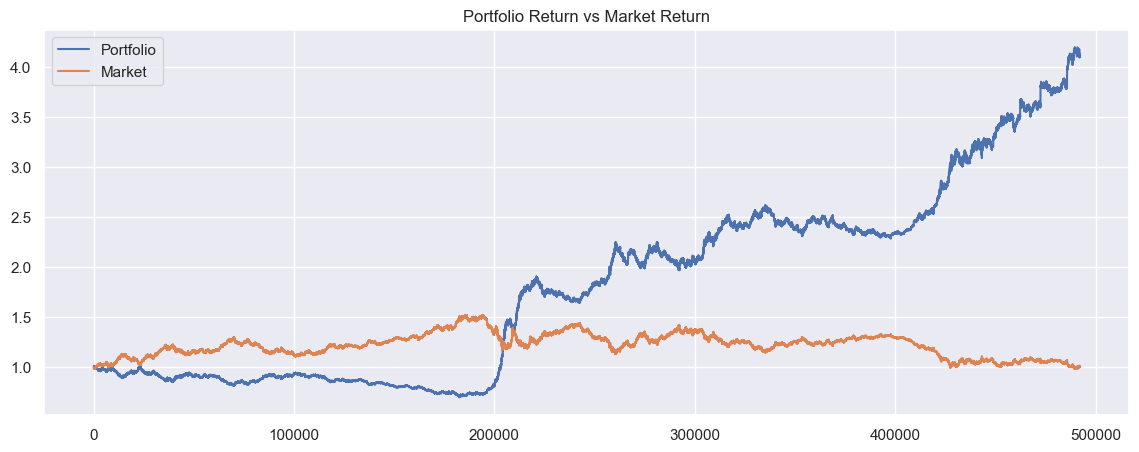

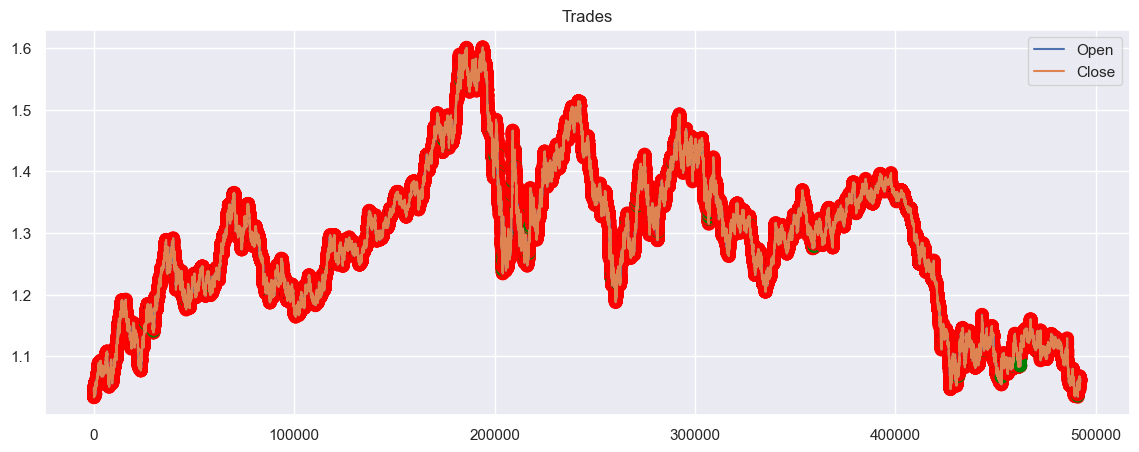

In [30]:
eurusd_env_trn.render()

In [31]:
len([fee for fee in eurusd_env_trn.get_attr('history')[0]['trading_costs'] if fee != 0])

1789

##### Validation set results

In [32]:
eurusd_env_val = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v2/vecnormalize.pkl',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=True)
    )
)

In [33]:
obs = eurusd_env_val.reset()
for i in tqdm(range(len(target_prices_val) - 2)):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_val.step(action)

100%|█████████████████████████████████████████████| 99998/99998 [00:18<00:00, 5335.12it/s]


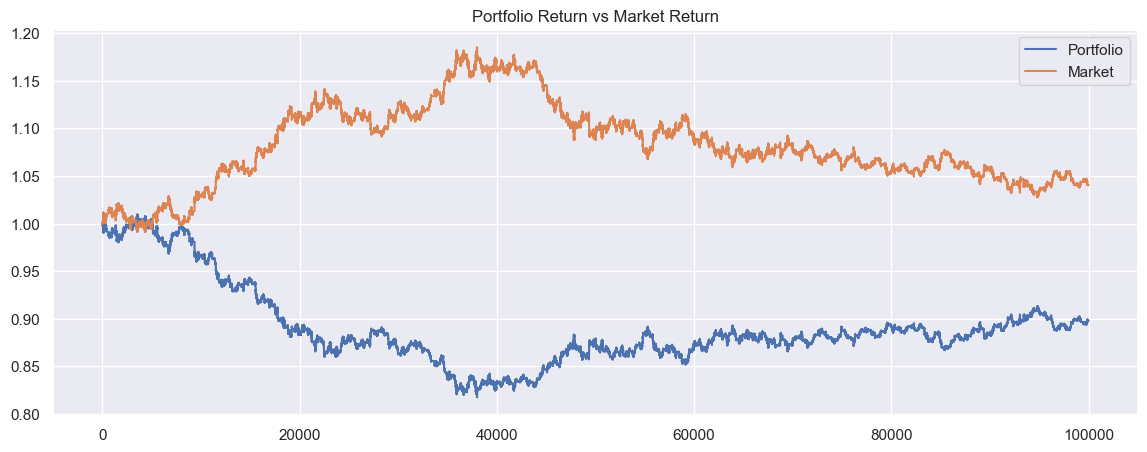

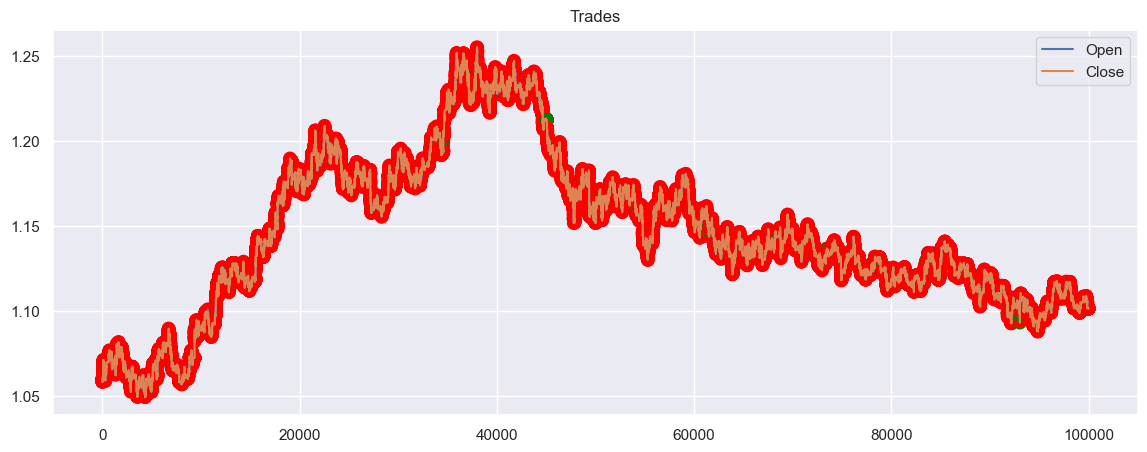

In [34]:
eurusd_env_val.render()

In [35]:
len([fee for fee in eurusd_env_val.get_attr('history')[0]['trading_costs'] if fee != 0])

302

##### Evaluation set results

In [36]:
eurusd_env_eval = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v2/vecnormalize.pkl',
    make_vec_env(
        ForexEnvBasic,
        env_kwargs=dict(
            target_prices_df=target_prices_eval,
            features_df=basic_features_eval,
            **deepcopy(BASE_ENV_KWARGS)
        )
    )
)

In [37]:
obs = eurusd_env_eval.reset()
for i in tqdm(range(len(target_prices_eval) - 2)):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_eval.step(action)

100%|█████████████████████████████████████████████| 99998/99998 [00:18<00:00, 5418.41it/s]


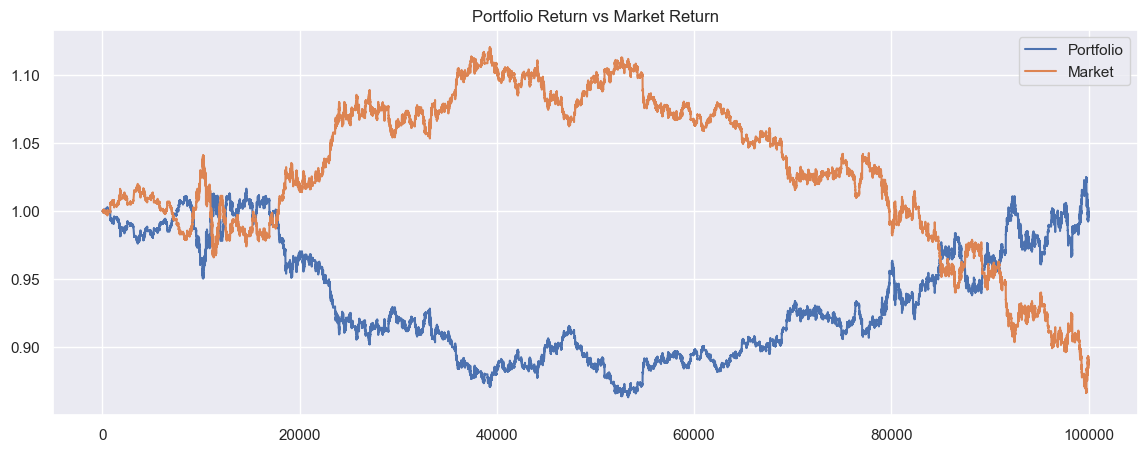

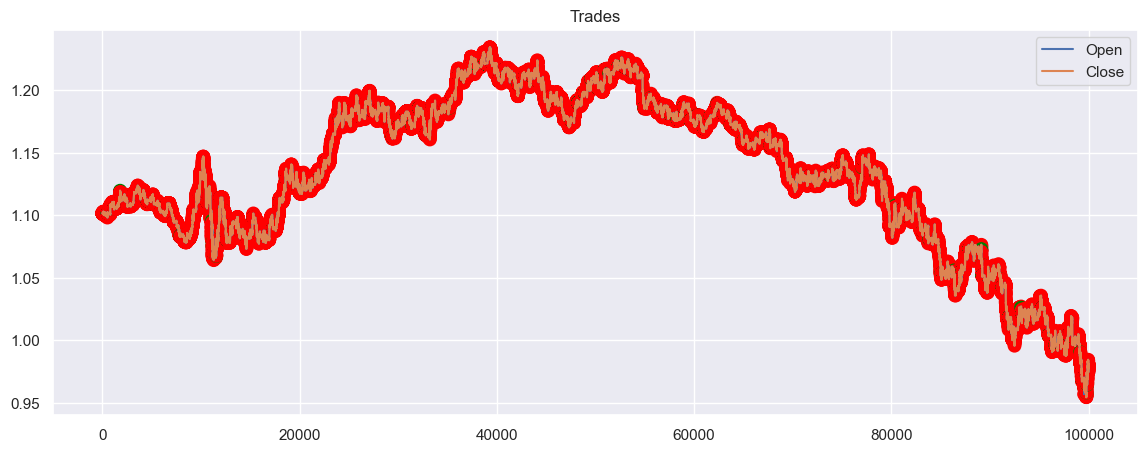

In [38]:
eurusd_env_eval.render()

In [39]:
len([fee for fee in eurusd_env_eval.get_attr('history')[0]['trading_costs'] if fee != 0])

350

#### Best model

In [40]:
_, best_model_path, log_path = get_model_path(0, f'{LOGS_PATH}/training', 'dqn', 'ForexFullEURUSD-v2', load_best=True)

Loading latest experiment, id=1


In [41]:
best_model_vecnormalize = sorted(
    [filename for filename in os.listdir(f'{log_path}/ForexFullEURUSD-v2') if 'vecnormalize_' in filename], 
    key=lambda x: int(x.split('_')[1])
)[-1]

In [42]:
best_model_vecnormalize

'vecnormalize_4200000_steps.pkl'

In [43]:
best_model = DQN.load(best_model_path)

##### Train set results

In [44]:
eurusd_env_trn = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v2/{best_model_vecnormalize}',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=False)
    )
)

In [45]:
obs = eurusd_env_trn.reset()
for i in tqdm(range(len(target_prices_trn) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_trn.step(action)

100%|███████████████████████████████████████████| 492325/492325 [01:32<00:00, 5304.00it/s]


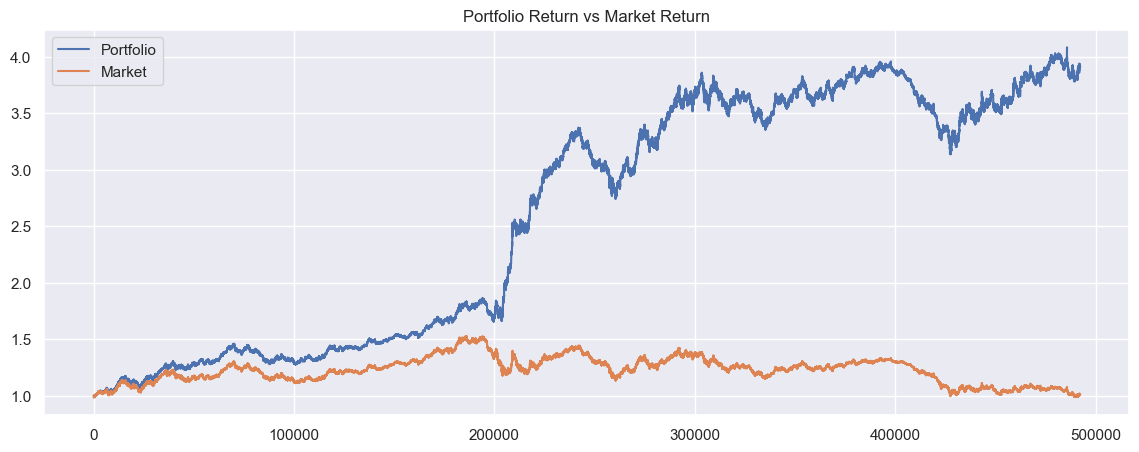

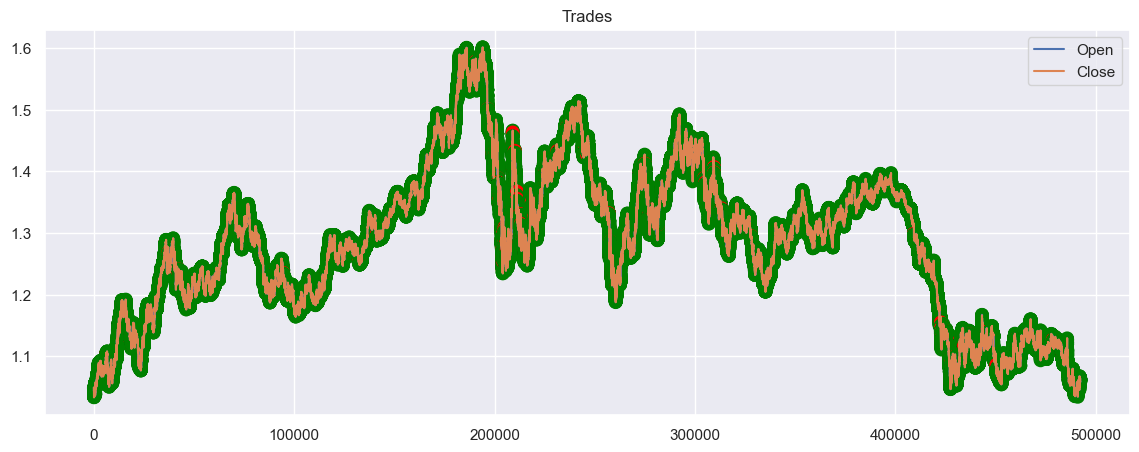

In [46]:
eurusd_env_trn.render()

In [47]:
len([fee for fee in eurusd_env_trn.get_attr('history')[0]['trading_costs'] if fee != 0])

720

##### Validation set results

In [48]:
eurusd_env_val = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v2/{best_model_vecnormalize}',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=True)
    )
)

In [49]:
obs = eurusd_env_val.reset()
for i in tqdm(range(len(target_prices_val) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_val.step(action)

100%|█████████████████████████████████████████████| 99998/99998 [00:19<00:00, 5230.05it/s]


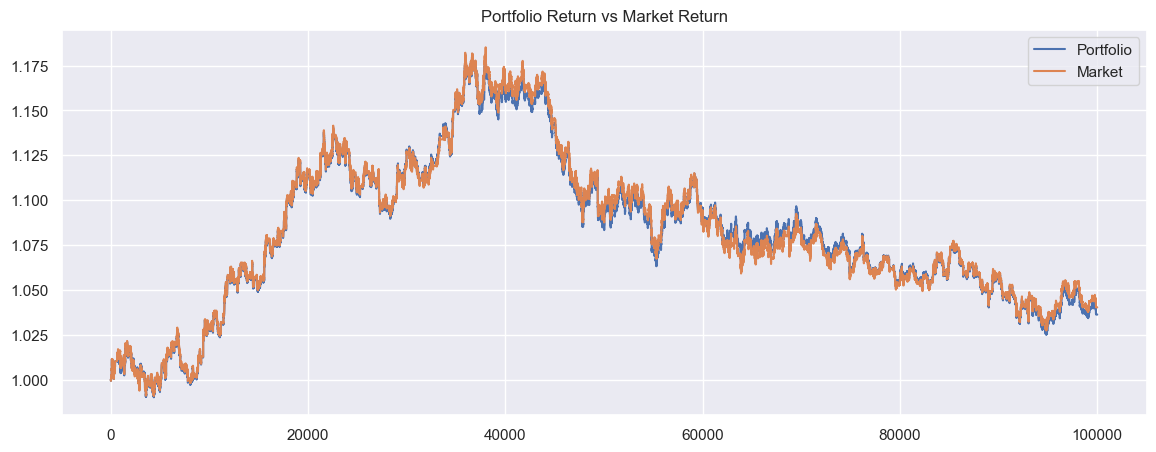

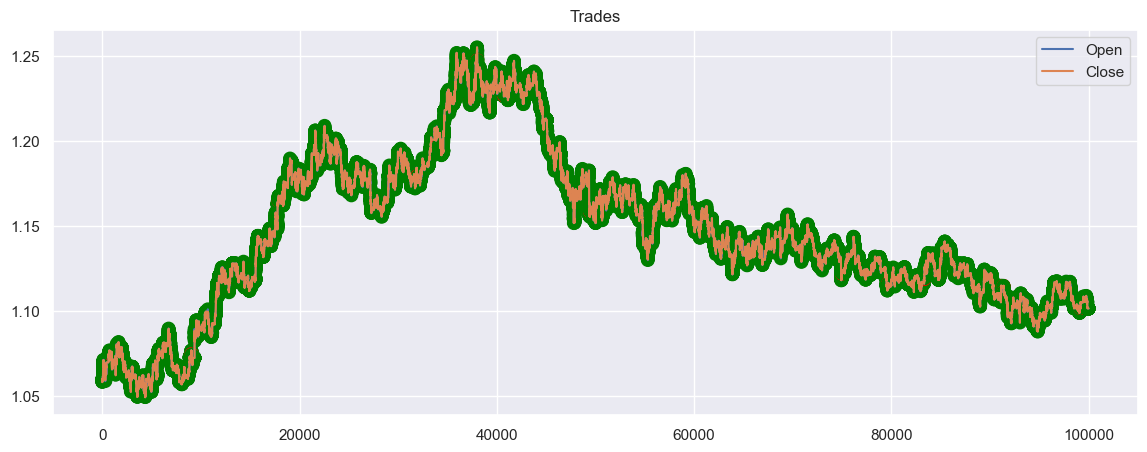

In [50]:
eurusd_env_val.render()

In [51]:
len([fee for fee in eurusd_env_val.get_attr('history')[0]['trading_costs'] if fee != 0])

63

##### Evaluation set results

In [52]:
eurusd_env_eval = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v2/{best_model_vecnormalize}',
    make_vec_env(
        ForexEnvBasic,
        env_kwargs=dict(
            target_prices_df=target_prices_eval,
            features_df=basic_features_eval,
            **deepcopy(BASE_ENV_KWARGS)
        )
    )
)

In [53]:
obs = eurusd_env_eval.reset()
for i in tqdm(range(len(target_prices_eval) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_eval.step(action)

100%|█████████████████████████████████████████████| 99998/99998 [00:19<00:00, 5020.71it/s]


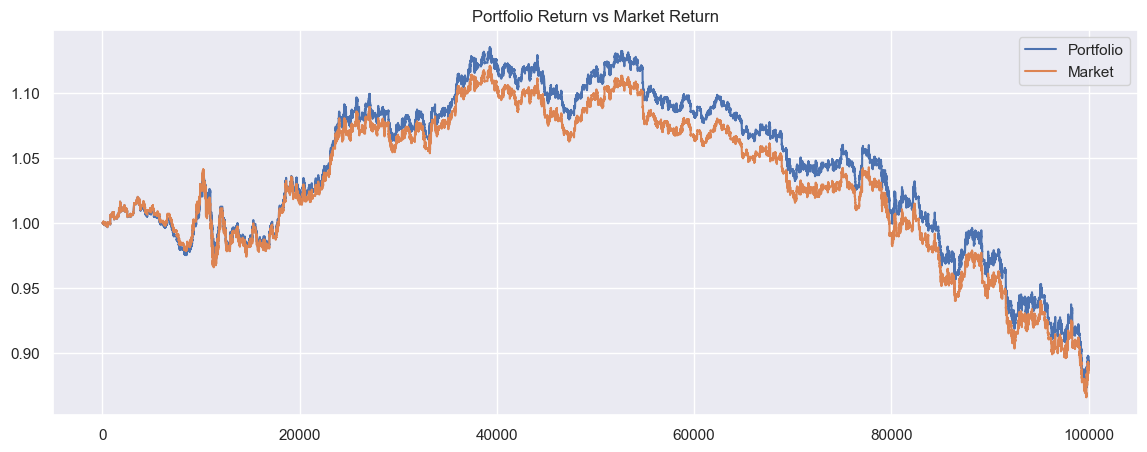

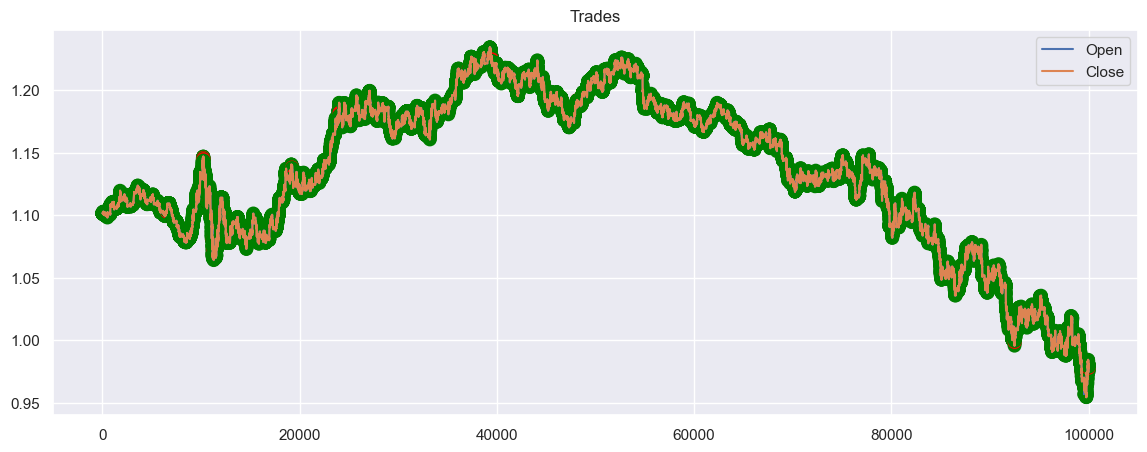

In [54]:
eurusd_env_eval.render()

In [55]:
len([fee for fee in eurusd_env_eval.get_attr('history')[0]['trading_costs'] if fee != 0])

76

### A2C

In [21]:
sys.argv = [
    'python', 
    '--algo', 'a2c',
    '--env', 'ForexFullEURUSD-v2',
    '--tensorboard-log', f'{LOGS_PATH}/training/TensorBoard',
    '--n-timesteps', '5000000',
    '--eval-freq', '100000',
    '--eval-episodes', '1',
    '--log-folder', f'{LOGS_PATH}/training',
    '--seed', '604',
    '--verbose', '0',
    '--hyperparams', 'normalize:dict(norm_reward=False)', 'callback:"rl_trading.utils.TextProgressBarCallback"',
    '--conf-file', f'{HYPERPARAMS_PATH}/default/a2c.yml'
]

train()

========== ForexFullEURUSD-v2 ==========
Seed: 604
Loading hyperparameters from: /Users/astepura/Desktop/I-CUREUS/RL-trading/hyperparams/default/a2c.yml
Default hyperparameters for environment (ones being tuned will be overridden):
OrderedDict([('callback', 'rl_trading.utils.TextProgressBarCallback'),
             ('ent_coef', 0.0),
             ('gae_lambda', 1.0),
             ('gamma', 0.99),
             ('learning_rate', 0.0007),
             ('max_grad_norm', 0.5),
             ('n_steps', 5),
             ('normalize', {'norm_reward': False}),
             ('normalize_advantage', False),
             ('policy', 'MlpPolicy'),
             ('policy_kwargs',
              'dict( net_arch=[dict(pi=[64, 64], vf=[64, 64])], '
              'activation_fn=nn.Tanh, ortho_init=True )'),
             ('use_rms_prop', True),
             ('vf_coef', 0.5)])
Log path: /Users/astepura/Desktop/I-CUREUS/RL-trading/logs/training/a2c/ForexFullEURUSD-v2_1


  2%|▊                                        | 100220/5000000 [01:01<26:19:25, 51.70it/s]

Eval num_timesteps=100000, episode_reward=-3.25 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


  4%|█▋                                       | 200319/5000000 [02:03<22:34:41, 59.05it/s]

Eval num_timesteps=200000, episode_reward=-2.49 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


  6%|██▍                                      | 300362/5000000 [03:05<22:46:08, 57.33it/s]

Eval num_timesteps=300000, episode_reward=-2.68 +/- 0.00
Episode length: 99999.00 +/- 0.00


  8%|███▎                                     | 400230/5000000 [04:08<21:48:10, 58.60it/s]

Eval num_timesteps=400000, episode_reward=-2.29 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 10%|████                                     | 500201/5000000 [05:10<25:04:29, 49.85it/s]

Eval num_timesteps=500000, episode_reward=-2.32 +/- 0.00
Episode length: 99999.00 +/- 0.00


 12%|████▉                                    | 600230/5000000 [06:11<20:10:15, 60.59it/s]

Eval num_timesteps=600000, episode_reward=-2.31 +/- 0.00
Episode length: 99999.00 +/- 0.00


 14%|█████▋                                   | 700199/5000000 [07:12<21:30:58, 55.51it/s]

Eval num_timesteps=700000, episode_reward=-2.37 +/- 0.00
Episode length: 99999.00 +/- 0.00


 16%|██████▌                                  | 800223/5000000 [08:13<19:44:55, 59.07it/s]

Eval num_timesteps=800000, episode_reward=-1.58 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 18%|███████▍                                 | 900406/5000000 [09:14<18:55:28, 60.17it/s]

Eval num_timesteps=900000, episode_reward=-1.55 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 20%|████████                                | 1000325/5000000 [10:14<17:48:29, 62.39it/s]

Eval num_timesteps=1000000, episode_reward=-1.44 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 22%|████████▊                               | 1100368/5000000 [11:15<17:38:28, 61.40it/s]

Eval num_timesteps=1100000, episode_reward=-0.83 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 24%|█████████▌                              | 1200249/5000000 [12:15<17:06:26, 61.70it/s]

Eval num_timesteps=1200000, episode_reward=-1.14 +/- 0.00
Episode length: 99999.00 +/- 0.00


 26%|██████████▍                             | 1300221/5000000 [13:16<20:36:35, 49.87it/s]

Eval num_timesteps=1300000, episode_reward=-0.65 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 28%|███████████▏                            | 1400230/5000000 [14:17<18:34:01, 53.86it/s]

Eval num_timesteps=1400000, episode_reward=-0.80 +/- 0.00
Episode length: 99999.00 +/- 0.00


 30%|████████████                            | 1500216/5000000 [15:18<19:09:03, 50.76it/s]

Eval num_timesteps=1500000, episode_reward=-0.84 +/- 0.00
Episode length: 99999.00 +/- 0.00


 32%|████████████▊                           | 1600226/5000000 [16:19<19:11:24, 49.21it/s]

Eval num_timesteps=1600000, episode_reward=-0.85 +/- 0.00
Episode length: 99999.00 +/- 0.00


 34%|█████████████▌                          | 1700203/5000000 [17:22<19:20:20, 47.40it/s]

Eval num_timesteps=1700000, episode_reward=-0.75 +/- 0.00
Episode length: 99999.00 +/- 0.00


 36%|██████████████▍                         | 1800433/5000000 [18:24<14:17:14, 62.21it/s]

Eval num_timesteps=1800000, episode_reward=-0.78 +/- 0.00
Episode length: 99999.00 +/- 0.00


 38%|███████████████▏                        | 1900389/5000000 [19:25<14:03:38, 61.23it/s]

Eval num_timesteps=1900000, episode_reward=-0.66 +/- 0.00
Episode length: 99999.00 +/- 0.00


 40%|████████████████                        | 2000210/5000000 [20:25<19:01:36, 43.80it/s]

Eval num_timesteps=2000000, episode_reward=-0.44 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 42%|████████████████▊                       | 2100231/5000000 [21:27<13:47:40, 58.39it/s]

Eval num_timesteps=2100000, episode_reward=-0.52 +/- 0.00
Episode length: 99999.00 +/- 0.00


 44%|█████████████████▌                      | 2200227/5000000 [22:28<15:14:25, 51.03it/s]

Eval num_timesteps=2200000, episode_reward=-0.40 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 46%|██████████████████▍                     | 2300229/5000000 [23:29<15:04:38, 49.74it/s]

Eval num_timesteps=2300000, episode_reward=-0.37 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 48%|███████████████████▏                    | 2400229/5000000 [24:29<12:02:18, 59.99it/s]

Eval num_timesteps=2400000, episode_reward=-0.32 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 50%|████████████████████                    | 2500226/5000000 [25:30<12:40:40, 54.77it/s]

Eval num_timesteps=2500000, episode_reward=-0.45 +/- 0.00
Episode length: 99999.00 +/- 0.00


 52%|████████████████████▊                   | 2600233/5000000 [26:30<12:39:03, 52.69it/s]

Eval num_timesteps=2600000, episode_reward=-0.36 +/- 0.00
Episode length: 99999.00 +/- 0.00


 54%|█████████████████████▌                  | 2700233/5000000 [27:30<12:31:07, 51.03it/s]

Eval num_timesteps=2700000, episode_reward=-0.46 +/- 0.00
Episode length: 99999.00 +/- 0.00


 56%|██████████████████████▍                 | 2800231/5000000 [28:30<12:16:11, 49.80it/s]

Eval num_timesteps=2800000, episode_reward=-0.56 +/- 0.00
Episode length: 99999.00 +/- 0.00


 58%|███████████████████████▏                | 2900226/5000000 [29:31<10:33:53, 55.21it/s]

Eval num_timesteps=2900000, episode_reward=-0.47 +/- 0.00
Episode length: 99999.00 +/- 0.00


 60%|████████████████████████▌                | 3000233/5000000 [30:31<9:42:50, 57.19it/s]

Eval num_timesteps=3000000, episode_reward=-0.40 +/- 0.00
Episode length: 99999.00 +/- 0.00


 62%|████████████████████████▊               | 3100234/5000000 [31:31<10:16:57, 51.32it/s]

Eval num_timesteps=3100000, episode_reward=-0.47 +/- 0.00
Episode length: 99999.00 +/- 0.00


 64%|██████████████████████████▏              | 3200235/5000000 [32:31<8:01:29, 62.30it/s]

Eval num_timesteps=3200000, episode_reward=-0.37 +/- 0.00
Episode length: 99999.00 +/- 0.00


 66%|███████████████████████████              | 3300235/5000000 [33:31<9:19:06, 50.67it/s]

Eval num_timesteps=3300000, episode_reward=-0.37 +/- 0.00
Episode length: 99999.00 +/- 0.00


 68%|███████████████████████████▉             | 3400226/5000000 [34:31<8:38:49, 51.39it/s]

Eval num_timesteps=3400000, episode_reward=-0.24 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 70%|████████████████████████████▋            | 3500231/5000000 [35:31<7:15:17, 57.42it/s]

Eval num_timesteps=3500000, episode_reward=-0.31 +/- 0.00
Episode length: 99999.00 +/- 0.00


 72%|█████████████████████████████▌           | 3600223/5000000 [36:31<7:26:43, 52.22it/s]

Eval num_timesteps=3600000, episode_reward=-0.26 +/- 0.00
Episode length: 99999.00 +/- 0.00


 74%|██████████████████████████████▎          | 3700235/5000000 [37:32<6:06:33, 59.10it/s]

Eval num_timesteps=3700000, episode_reward=-0.37 +/- 0.00
Episode length: 99999.00 +/- 0.00


 76%|███████████████████████████████▏         | 3800232/5000000 [38:32<6:35:07, 50.61it/s]

Eval num_timesteps=3800000, episode_reward=-0.31 +/- 0.00
Episode length: 99999.00 +/- 0.00


 78%|███████████████████████████████▉         | 3900232/5000000 [39:32<5:15:03, 58.18it/s]

Eval num_timesteps=3900000, episode_reward=-0.26 +/- 0.00
Episode length: 99999.00 +/- 0.00


 80%|████████████████████████████████▊        | 4000231/5000000 [40:32<5:11:47, 53.44it/s]

Eval num_timesteps=4000000, episode_reward=-0.27 +/- 0.00
Episode length: 99999.00 +/- 0.00


 82%|█████████████████████████████████▌       | 4100226/5000000 [41:32<4:42:49, 53.02it/s]

Eval num_timesteps=4100000, episode_reward=-0.23 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 84%|██████████████████████████████████▍      | 4200232/5000000 [42:32<4:12:57, 52.70it/s]

Eval num_timesteps=4200000, episode_reward=-0.22 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 86%|███████████████████████████████████▎     | 4300236/5000000 [43:33<3:26:49, 56.39it/s]

Eval num_timesteps=4300000, episode_reward=-0.16 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 88%|████████████████████████████████████     | 4400234/5000000 [44:33<2:40:46, 62.18it/s]

Eval num_timesteps=4400000, episode_reward=-0.27 +/- 0.00
Episode length: 99999.00 +/- 0.00


 90%|████████████████████████████████████▉    | 4500231/5000000 [45:33<2:29:23, 55.76it/s]

Eval num_timesteps=4500000, episode_reward=-0.21 +/- 0.00
Episode length: 99999.00 +/- 0.00


 92%|█████████████████████████████████████▋   | 4600216/5000000 [46:34<2:18:31, 48.10it/s]

Eval num_timesteps=4600000, episode_reward=-0.14 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 94%|██████████████████████████████████████▌  | 4700231/5000000 [47:35<1:26:34, 57.71it/s]

Eval num_timesteps=4700000, episode_reward=-0.18 +/- 0.00
Episode length: 99999.00 +/- 0.00


 96%|█████████████████████████████████████▍ | 4800217/5000000 [1:05:22<1:20:25, 41.40it/s]

Eval num_timesteps=4800000, episode_reward=-0.22 +/- 0.00
Episode length: 99999.00 +/- 0.00


 98%|████████████████████████████████████████▏| 4900378/5000000 [1:06:22<26:18, 63.12it/s]

Eval num_timesteps=4900000, episode_reward=-0.12 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


100%|███████████████████████████████████████| 5000000/5000000 [1:07:22<00:00, 1236.80it/s]

Eval num_timesteps=5000000, episode_reward=-0.16 +/- 0.00
Episode length: 99999.00 +/- 0.00
Saving to /Users/astepura/Desktop/I-CUREUS/RL-trading/logs/training/a2c/ForexFullEURUSD-v2_1


#### Final model

In [56]:
_, model_path, log_path = get_model_path(0, f'{LOGS_PATH}/training', 'a2c', 'ForexFullEURUSD-v2')

Loading latest experiment, id=1


In [57]:
model = A2C.load(model_path)

##### Train set results

In [58]:
eurusd_env_trn = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v2/vecnormalize.pkl',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=False)
    )
)

In [59]:
obs = eurusd_env_trn.reset()
for i in tqdm(range(len(target_prices_trn) - 2)):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_trn.step(action)

100%|███████████████████████████████████████████| 492325/492325 [01:53<00:00, 4331.15it/s]


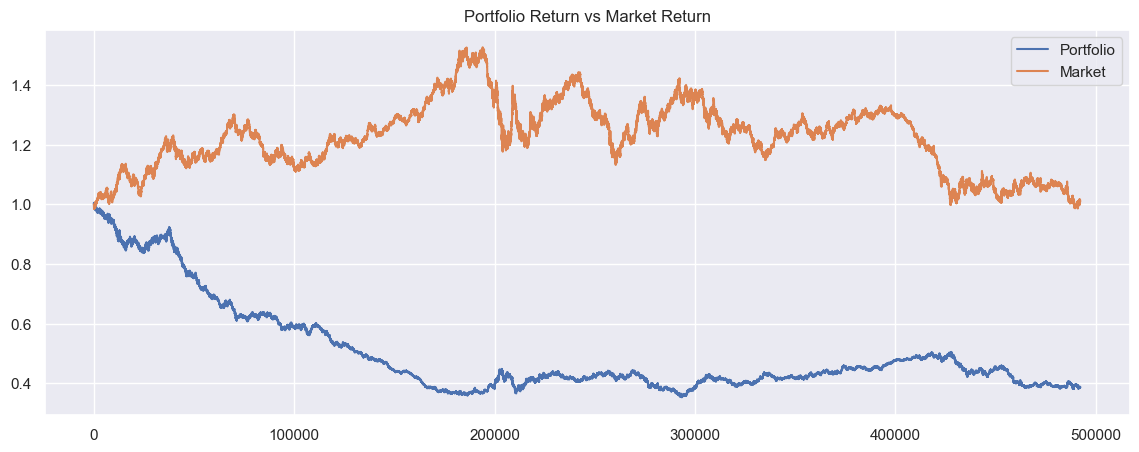

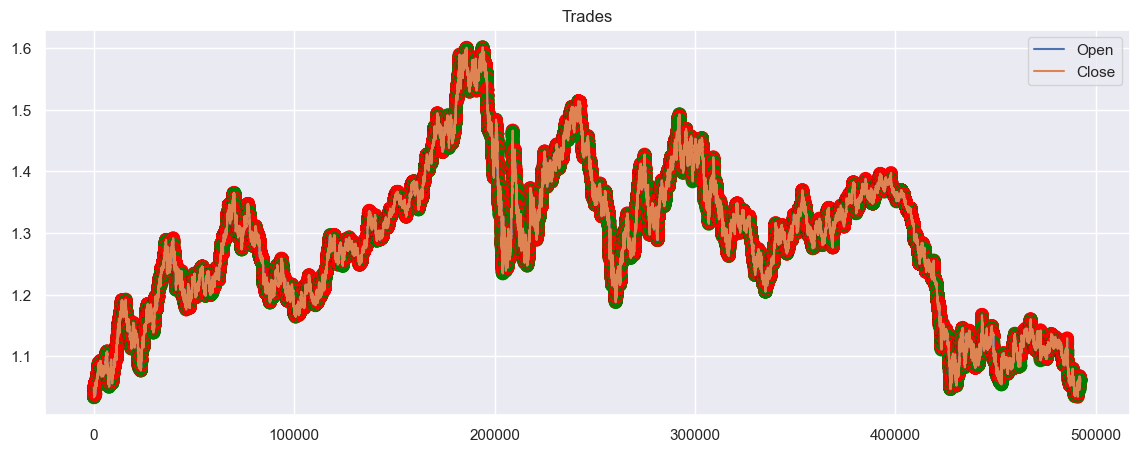

In [60]:
eurusd_env_trn.render()

In [61]:
len([fee for fee in eurusd_env_trn.get_attr('history')[0]['trading_costs'] if fee != 0])

14109

##### Validation set results

In [62]:
eurusd_env_val = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v2/vecnormalize.pkl',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=True)
    )
)

In [63]:
obs = eurusd_env_val.reset()
for i in tqdm(range(len(target_prices_val) - 2)):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_val.step(action)

100%|█████████████████████████████████████████████| 99998/99998 [00:23<00:00, 4335.43it/s]


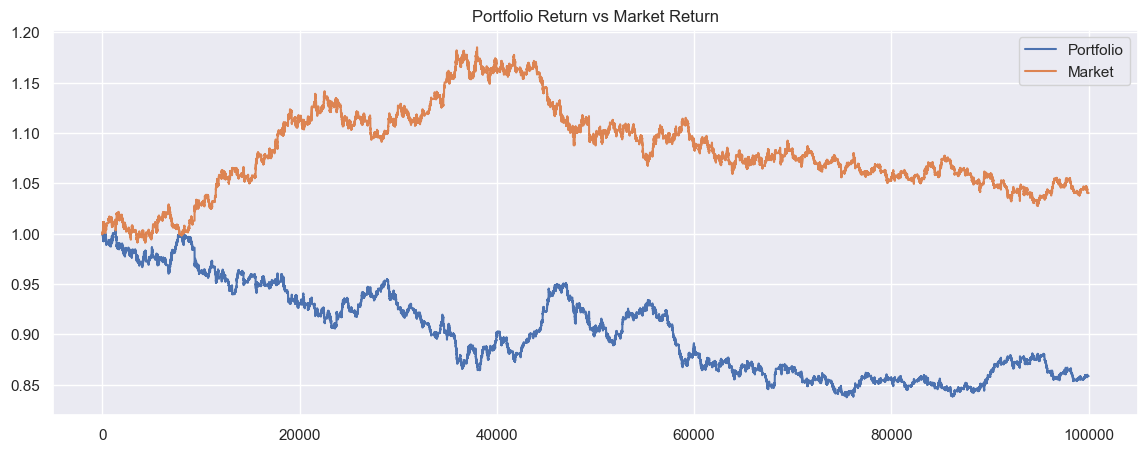

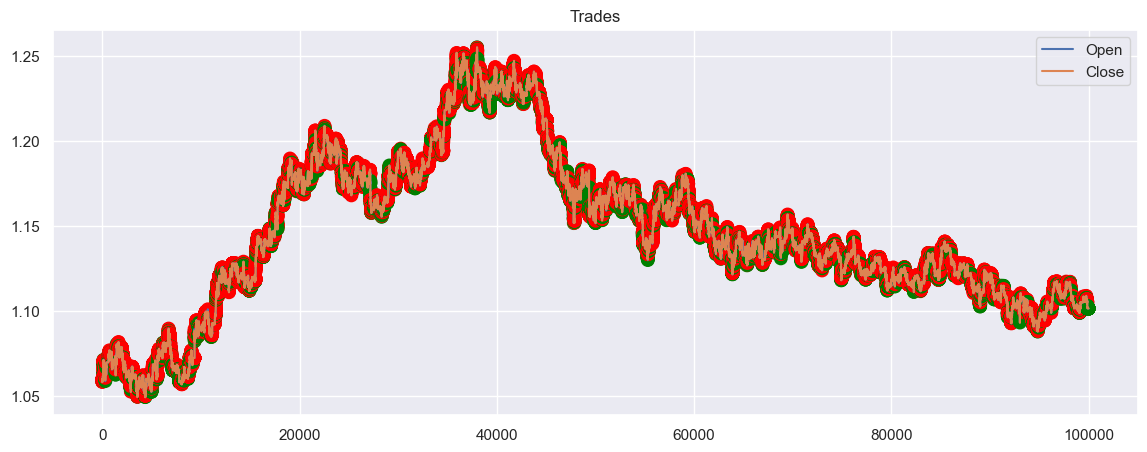

In [64]:
eurusd_env_val.render()

In [65]:
len([fee for fee in eurusd_env_val.get_attr('history')[0]['trading_costs'] if fee != 0])

1959

##### Evaluation set results

In [66]:
eurusd_env_eval = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v2/vecnormalize.pkl',
    make_vec_env(
        ForexEnvBasic,
        env_kwargs=dict(
            target_prices_df=target_prices_eval,
            features_df=basic_features_eval,
            **deepcopy(BASE_ENV_KWARGS)
        )
    )
)

In [67]:
obs = eurusd_env_eval.reset()
for i in tqdm(range(len(target_prices_eval) - 2)):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_eval.step(action)

100%|█████████████████████████████████████████████| 99998/99998 [00:23<00:00, 4327.99it/s]


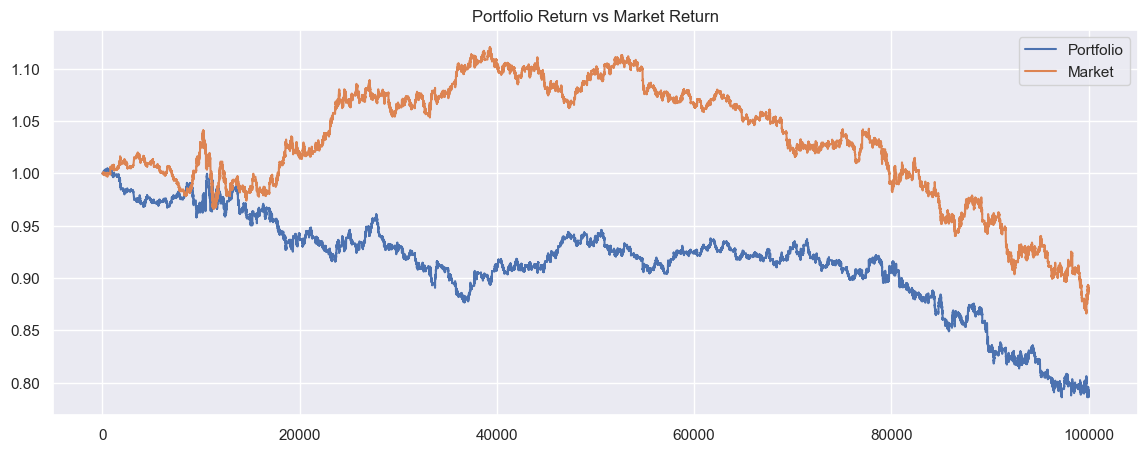

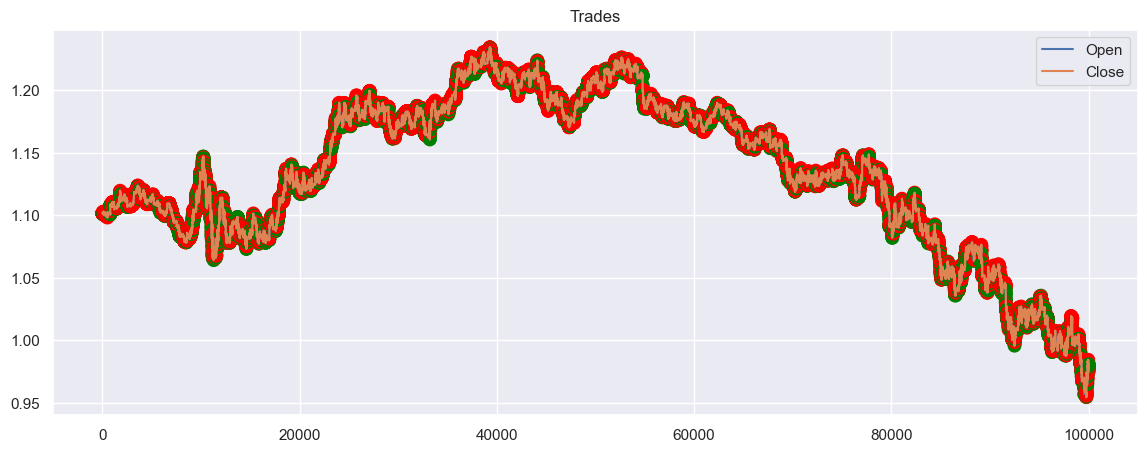

In [68]:
eurusd_env_eval.render()

In [69]:
len([fee for fee in eurusd_env_eval.get_attr('history')[0]['trading_costs'] if fee != 0])

2205

#### Best model

In [70]:
_, best_model_path, log_path = get_model_path(0, f'{LOGS_PATH}/training', 'a2c', 'ForexFullEURUSD-v2', load_best=True)

Loading latest experiment, id=1


In [71]:
best_model_vecnormalize = sorted(
    [filename for filename in os.listdir(f'{log_path}/ForexFullEURUSD-v2') if 'vecnormalize_' in filename], 
    key=lambda x: int(x.split('_')[1])
)[-1]

In [72]:
best_model_vecnormalize

'vecnormalize_4900000_steps.pkl'

In [73]:
best_model = A2C.load(best_model_path)

##### Train set results

In [74]:
eurusd_env_trn = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v2/{best_model_vecnormalize}',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=False)
    )
)

In [75]:
obs = eurusd_env_trn.reset()
for i in tqdm(range(len(target_prices_trn) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_trn.step(action)

100%|███████████████████████████████████████████| 492325/492325 [01:53<00:00, 4325.06it/s]


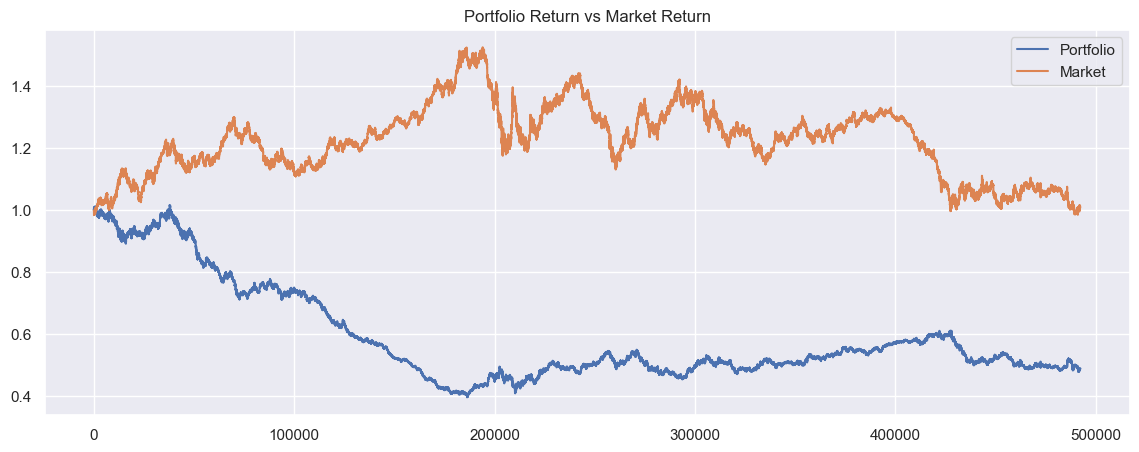

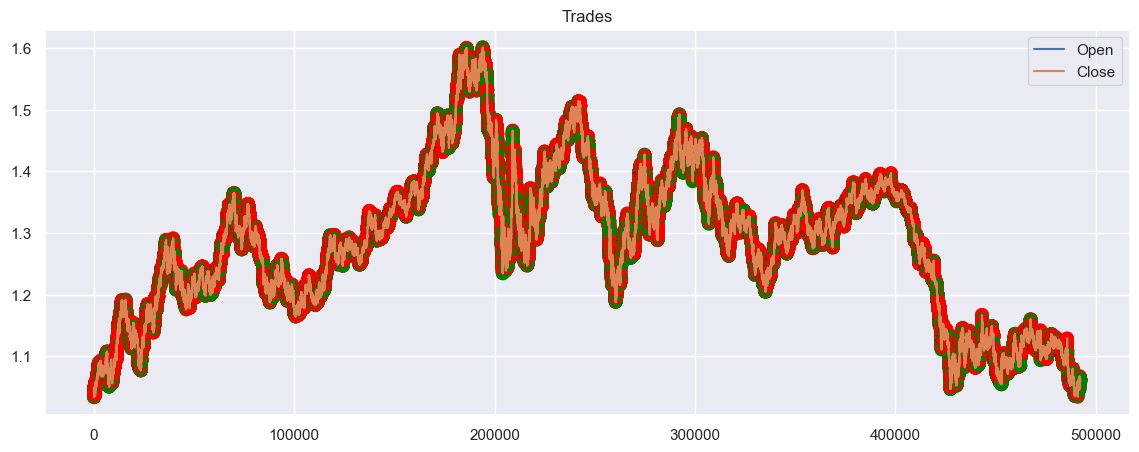

In [76]:
eurusd_env_trn.render()

In [77]:
len([fee for fee in eurusd_env_trn.get_attr('history')[0]['trading_costs'] if fee != 0])

12449

##### Validation set results

In [78]:
eurusd_env_val = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v2/{best_model_vecnormalize}',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=True)
    )
)

In [79]:
obs = eurusd_env_val.reset()
for i in tqdm(range(len(target_prices_val) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_val.step(action)

100%|█████████████████████████████████████████████| 99998/99998 [00:22<00:00, 4414.60it/s]


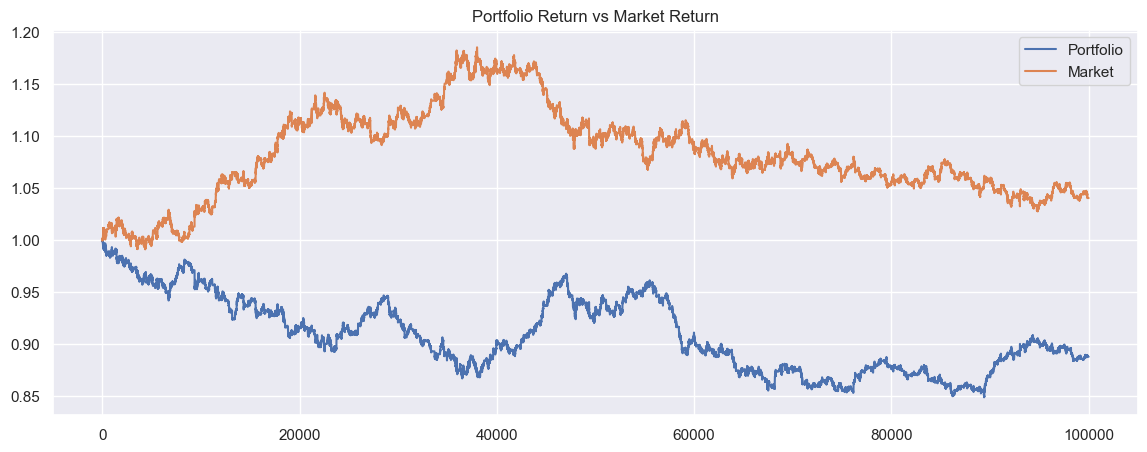

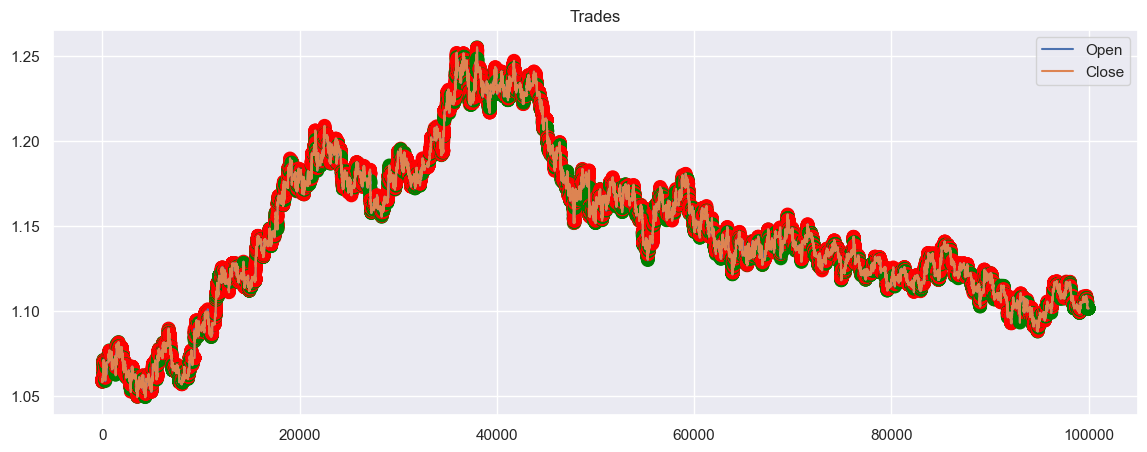

In [80]:
eurusd_env_val.render()

In [81]:
len([fee for fee in eurusd_env_val.get_attr('history')[0]['trading_costs'] if fee != 0])

1738

##### Evaluation set results

In [82]:
eurusd_env_eval = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v2/{best_model_vecnormalize}',
    make_vec_env(
        ForexEnvBasic,
        env_kwargs=dict(
            target_prices_df=target_prices_eval,
            features_df=basic_features_eval,
            **deepcopy(BASE_ENV_KWARGS)
        )
    )
)

In [83]:
obs = eurusd_env_eval.reset()
for i in tqdm(range(len(target_prices_eval) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_eval.step(action)

100%|█████████████████████████████████████████████| 99998/99998 [00:22<00:00, 4426.19it/s]


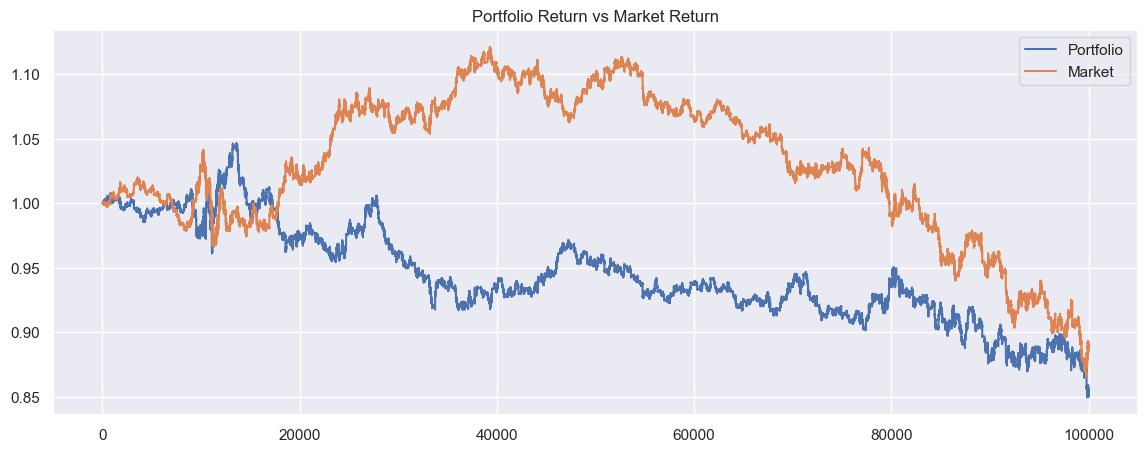

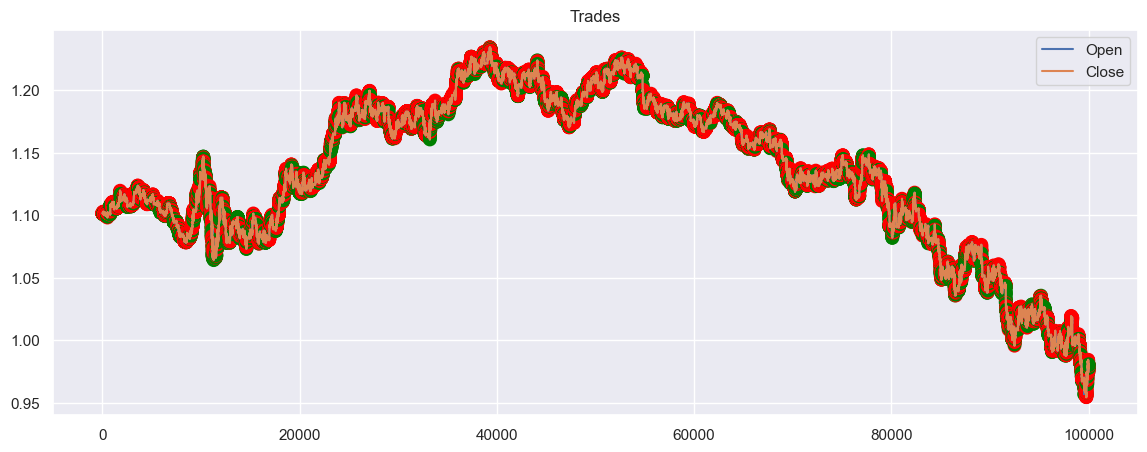

In [84]:
eurusd_env_eval.render()

In [85]:
len([fee for fee in eurusd_env_eval.get_attr('history')[0]['trading_costs'] if fee != 0])

1923

### PPO

In [22]:
sys.argv = [
    'python', 
    '--algo', 'ppo',
    '--env', 'ForexFullEURUSD-v2',
    '--tensorboard-log', f'{LOGS_PATH}/training/TensorBoard',
    '--n-timesteps', '5000000',
    '--eval-freq', '100000',
    '--eval-episodes', '1',
    '--log-folder', f'{LOGS_PATH}/training',
    '--seed', '604',
    '--verbose', '0',
    '--hyperparams', 'normalize:dict(norm_reward=False)', 'callback:"rl_trading.utils.TextProgressBarCallback"',
    '--conf-file', f'{HYPERPARAMS_PATH}/default/ppo.yml'
]

train()

========== ForexFullEURUSD-v2 ==========
Seed: 604
Loading hyperparameters from: /Users/astepura/Desktop/I-CUREUS/RL-trading/hyperparams/default/ppo.yml
Default hyperparameters for environment (ones being tuned will be overridden):
OrderedDict([('batch_size', 64),
             ('callback', 'rl_trading.utils.TextProgressBarCallback'),
             ('clip_range', 0.2),
             ('ent_coef', 0.0),
             ('gae_lambda', 0.95),
             ('gamma', 0.99),
             ('learning_rate', 0.0003),
             ('max_grad_norm', 0.5),
             ('n_epochs', 10),
             ('n_steps', 2048),
             ('normalize', {'norm_reward': False}),
             ('policy', 'MlpPolicy'),
             ('policy_kwargs',
              'dict( net_arch=[dict(pi=[64, 64], vf=[64, 64])], '
              'activation_fn=nn.Tanh, ortho_init=True )'),
             ('vf_coef', 0.5)])
Log path: /Users/astepura/Desktop/I-CUREUS/RL-trading/logs/training/ppo/ForexFullEURUSD-v2_1


  2%|▊                                        | 100249/5000000 [00:58<18:38:14, 73.03it/s]

Eval num_timesteps=100000, episode_reward=-1.73 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


  4%|█▋                                       | 200404/5000000 [01:56<14:30:02, 91.94it/s]

Eval num_timesteps=200000, episode_reward=-1.82 +/- 0.00
Episode length: 99999.00 +/- 0.00


  6%|██▍                                      | 300407/5000000 [02:54<13:25:45, 97.21it/s]

Eval num_timesteps=300000, episode_reward=-2.21 +/- 0.00
Episode length: 99999.00 +/- 0.00


  8%|███▏                                    | 400410/5000000 [03:52<12:25:59, 102.76it/s]

Eval num_timesteps=400000, episode_reward=-1.89 +/- 0.00
Episode length: 99999.00 +/- 0.00


 10%|████                                     | 500457/5000000 [04:49<12:37:46, 98.96it/s]

Eval num_timesteps=500000, episode_reward=-1.89 +/- 0.00
Episode length: 99999.00 +/- 0.00


 12%|████▉                                    | 600001/5000000 [05:47<18:43:49, 65.25it/s]

Eval num_timesteps=600000, episode_reward=-2.09 +/- 0.00
Episode length: 99999.00 +/- 0.00


 14%|█████▋                                   | 700407/5000000 [06:45<13:42:40, 87.11it/s]

Eval num_timesteps=700000, episode_reward=-2.09 +/- 0.00
Episode length: 99999.00 +/- 0.00


 16%|██████▌                                  | 800412/5000000 [07:43<12:49:31, 90.96it/s]

Eval num_timesteps=800000, episode_reward=-1.70 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 18%|███████▏                                | 900410/5000000 [08:41<11:16:21, 101.02it/s]

Eval num_timesteps=900000, episode_reward=-1.83 +/- 0.00
Episode length: 99999.00 +/- 0.00


 20%|████████                                | 1000782/5000000 [09:41<8:41:30, 127.81it/s]

Eval num_timesteps=1000000, episode_reward=-1.97 +/- 0.00
Episode length: 99999.00 +/- 0.00


 22%|████████▊                               | 1100382/5000000 [10:42<13:05:32, 82.74it/s]

Eval num_timesteps=1100000, episode_reward=-2.46 +/- 0.00
Episode length: 99999.00 +/- 0.00


 24%|█████████▌                              | 1200001/5000000 [16:42<18:53:02, 55.90it/s]

Eval num_timesteps=1200000, episode_reward=-2.12 +/- 0.00
Episode length: 99999.00 +/- 0.00


 26%|██████████▏                            | 1300366/5000000 [27:41<184:07:53,  5.58it/s]

Eval num_timesteps=1300000, episode_reward=-2.00 +/- 0.00
Episode length: 99999.00 +/- 0.00


 28%|███████████▏                            | 1400374/5000000 [33:41<11:31:42, 86.73it/s]

Eval num_timesteps=1400000, episode_reward=-1.79 +/- 0.00
Episode length: 99999.00 +/- 0.00


 30%|████████████                            | 1500736/5000000 [39:41<7:46:12, 125.10it/s]

Eval num_timesteps=1500000, episode_reward=-2.23 +/- 0.00
Episode length: 99999.00 +/- 0.00


 32%|████████████▊                           | 1600813/5000000 [40:40<6:40:23, 141.49it/s]

Eval num_timesteps=1600000, episode_reward=-2.15 +/- 0.00
Episode length: 99999.00 +/- 0.00


 34%|█████████████▌                          | 1700411/5000000 [41:38<10:06:47, 90.63it/s]

Eval num_timesteps=1700000, episode_reward=-2.09 +/- 0.00
Episode length: 99999.00 +/- 0.00


 36%|██████████████▍                         | 1800001/5000000 [42:36<11:49:07, 75.21it/s]

Eval num_timesteps=1800000, episode_reward=-2.22 +/- 0.00
Episode length: 99999.00 +/- 0.00


 38%|███████████████▌                         | 1900403/5000000 [43:34<9:19:55, 92.26it/s]

Eval num_timesteps=1900000, episode_reward=-2.44 +/- 0.00
Episode length: 99999.00 +/- 0.00


 40%|████████████████                        | 2000404/5000000 [44:32<7:57:31, 104.69it/s]

Eval num_timesteps=2000000, episode_reward=-2.68 +/- 0.00
Episode length: 99999.00 +/- 0.00


 42%|█████████████████▏                       | 2100406/5000000 [45:30<9:26:13, 85.35it/s]

Eval num_timesteps=2100000, episode_reward=-2.64 +/- 0.00
Episode length: 99999.00 +/- 0.00


 44%|█████████████████▌                      | 2200410/5000000 [46:28<7:30:09, 103.65it/s]

Eval num_timesteps=2200000, episode_reward=-2.39 +/- 0.00
Episode length: 99999.00 +/- 0.00


 46%|██████████████████▊                      | 2300400/5000000 [47:26<7:35:43, 98.73it/s]

Eval num_timesteps=2300000, episode_reward=-2.19 +/- 0.00
Episode length: 99999.00 +/- 0.00


 48%|███████████████████▋                     | 2400001/5000000 [48:23<9:57:45, 72.49it/s]

Eval num_timesteps=2400000, episode_reward=-2.09 +/- 0.00
Episode length: 99999.00 +/- 0.00


 50%|████████████████████                    | 2500576/5000000 [49:22<6:48:53, 101.88it/s]

Eval num_timesteps=2500000, episode_reward=-2.31 +/- 0.00
Episode length: 99999.00 +/- 0.00


 52%|█████████████████████▎                   | 2600389/5000000 [50:20<7:11:40, 92.65it/s]

Eval num_timesteps=2600000, episode_reward=-2.20 +/- 0.00
Episode length: 99999.00 +/- 0.00


 54%|█████████████████████▌                  | 2700807/5000000 [51:19<5:10:37, 123.36it/s]

Eval num_timesteps=2700000, episode_reward=-1.95 +/- 0.00
Episode length: 99999.00 +/- 0.00


 56%|██████████████████████▉                  | 2800406/5000000 [52:17<7:29:40, 81.53it/s]

Eval num_timesteps=2800000, episode_reward=-2.09 +/- 0.00
Episode length: 99999.00 +/- 0.00


 58%|███████████████████████▊                 | 2900395/5000000 [53:15<6:34:52, 88.62it/s]

Eval num_timesteps=2900000, episode_reward=-2.27 +/- 0.00
Episode length: 99999.00 +/- 0.00


 60%|████████████████████████▌                | 3000001/5000000 [54:13<7:36:39, 72.99it/s]

Eval num_timesteps=3000000, episode_reward=-2.74 +/- 0.00
Episode length: 99999.00 +/- 0.00


 62%|█████████████████████████▍               | 3100409/5000000 [55:11<6:10:47, 85.38it/s]

Eval num_timesteps=3100000, episode_reward=-2.32 +/- 0.00
Episode length: 99999.00 +/- 0.00


 64%|██████████████████████████▏              | 3200408/5000000 [56:09<5:01:55, 99.34it/s]

Eval num_timesteps=3200000, episode_reward=-2.52 +/- 0.00
Episode length: 99999.00 +/- 0.00


 66%|███████████████████████████              | 3300406/5000000 [57:07<5:00:08, 94.38it/s]

Eval num_timesteps=3300000, episode_reward=-2.78 +/- 0.00
Episode length: 99999.00 +/- 0.00


 68%|███████████████████████████▏            | 3400817/5000000 [58:05<3:03:50, 144.98it/s]

Eval num_timesteps=3400000, episode_reward=-2.42 +/- 0.00
Episode length: 99999.00 +/- 0.00


 70%|████████████████████████████▋            | 3499766/5000000 [58:45<07:51, 3178.74it/s]

Eval num_timesteps=3500000, episode_reward=-2.72 +/- 0.00
Episode length: 99999.00 +/- 0.00


 72%|████████████████████████████           | 3600001/5000000 [1:00:01<6:04:43, 63.97it/s]

Eval num_timesteps=3600000, episode_reward=-2.54 +/- 0.00
Episode length: 99999.00 +/- 0.00


 74%|████████████████████████████▊          | 3700404/5000000 [1:00:59<4:07:11, 87.62it/s]

Eval num_timesteps=3700000, episode_reward=-2.48 +/- 0.00
Episode length: 99999.00 +/- 0.00


 76%|█████████████████████████████▋         | 3800409/5000000 [1:01:57<3:22:25, 98.77it/s]

Eval num_timesteps=3800000, episode_reward=-2.72 +/- 0.00
Episode length: 99999.00 +/- 0.00


 78%|█████████████████████████████▋        | 3900809/5000000 [1:02:54<2:05:07, 146.40it/s]

Eval num_timesteps=3900000, episode_reward=-2.48 +/- 0.00
Episode length: 99999.00 +/- 0.00


 80%|███████████████████████████████▏       | 4000442/5000000 [1:03:52<2:48:09, 99.07it/s]

Eval num_timesteps=4000000, episode_reward=-2.73 +/- 0.00
Episode length: 99999.00 +/- 0.00


 82%|███████████████████████████████▉       | 4100001/5000000 [1:04:50<4:07:59, 60.48it/s]

Eval num_timesteps=4100000, episode_reward=-2.44 +/- 0.00
Episode length: 99999.00 +/- 0.00


 84%|███████████████████████████████▉      | 4200406/5000000 [1:05:48<2:06:01, 105.74it/s]

Eval num_timesteps=4200000, episode_reward=-2.41 +/- 0.00
Episode length: 99999.00 +/- 0.00


 86%|████████████████████████████████▋     | 4300409/5000000 [1:06:46<1:54:14, 102.07it/s]

Eval num_timesteps=4300000, episode_reward=-2.64 +/- 0.00
Episode length: 99999.00 +/- 0.00


 88%|█████████████████████████████████▍    | 4400752/5000000 [1:07:44<1:37:09, 102.79it/s]

Eval num_timesteps=4400000, episode_reward=-2.54 +/- 0.00
Episode length: 99999.00 +/- 0.00


 90%|███████████████████████████████████    | 4500408/5000000 [1:08:41<1:29:52, 92.65it/s]

Eval num_timesteps=4500000, episode_reward=-2.52 +/- 0.00
Episode length: 99999.00 +/- 0.00


 92%|███████████████████████████████████▉   | 4600409/5000000 [1:09:39<1:11:22, 93.30it/s]

Eval num_timesteps=4600000, episode_reward=-2.23 +/- 0.00
Episode length: 99999.00 +/- 0.00


 94%|████████████████████████████████████▋  | 4700001/5000000 [1:10:37<1:32:04, 54.31it/s]

Eval num_timesteps=4700000, episode_reward=-2.27 +/- 0.00
Episode length: 99999.00 +/- 0.00


 96%|███████████████████████████████████████▎ | 4800408/5000000 [1:11:35<39:04, 85.14it/s]

Eval num_timesteps=4800000, episode_reward=-2.58 +/- 0.00
Episode length: 99999.00 +/- 0.00


 98%|███████████████████████████████████████▏| 4900607/5000000 [1:12:33<15:51, 104.41it/s]

Eval num_timesteps=4900000, episode_reward=-2.43 +/- 0.00
Episode length: 99999.00 +/- 0.00


5000408it [1:13:31, 88.01it/s]                                                            

Eval num_timesteps=5000000, episode_reward=-2.28 +/- 0.00
Episode length: 99999.00 +/- 0.00


5001216it [1:13:31, 1133.65it/s]

Saving to /Users/astepura/Desktop/I-CUREUS/RL-trading/logs/training/ppo/ForexFullEURUSD-v2_1


#### Final model

In [86]:
_, model_path, log_path = get_model_path(0, f'{LOGS_PATH}/training', 'ppo', 'ForexFullEURUSD-v2')

Loading latest experiment, id=1


In [87]:
model = PPO.load(model_path)

##### Train set results

In [88]:
eurusd_env_trn = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v2/vecnormalize.pkl',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=False)
    )
)

In [89]:
obs = eurusd_env_trn.reset()
for i in tqdm(range(len(target_prices_trn) - 2)):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_trn.step(action)

100%|███████████████████████████████████████████| 492325/492325 [01:54<00:00, 4299.53it/s]


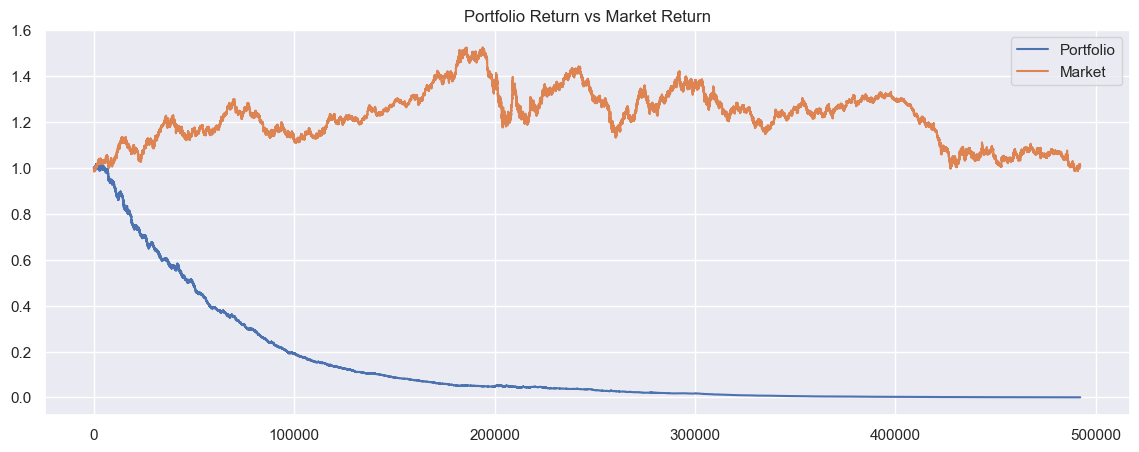

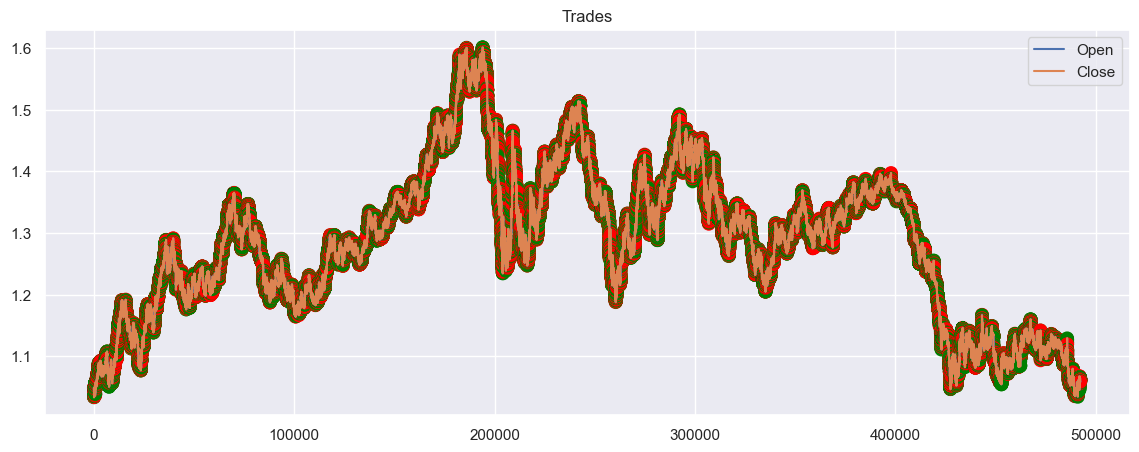

In [90]:
eurusd_env_trn.render()

In [91]:
len([fee for fee in eurusd_env_trn.get_attr('history')[0]['trading_costs'] if fee != 0])

70177

##### Validation set results

In [92]:
eurusd_env_val = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v2/vecnormalize.pkl',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=True)
    )
)

In [93]:
obs = eurusd_env_val.reset()
for i in tqdm(range(len(target_prices_val) - 2)):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_val.step(action)

100%|█████████████████████████████████████████████| 99998/99998 [00:23<00:00, 4306.84it/s]


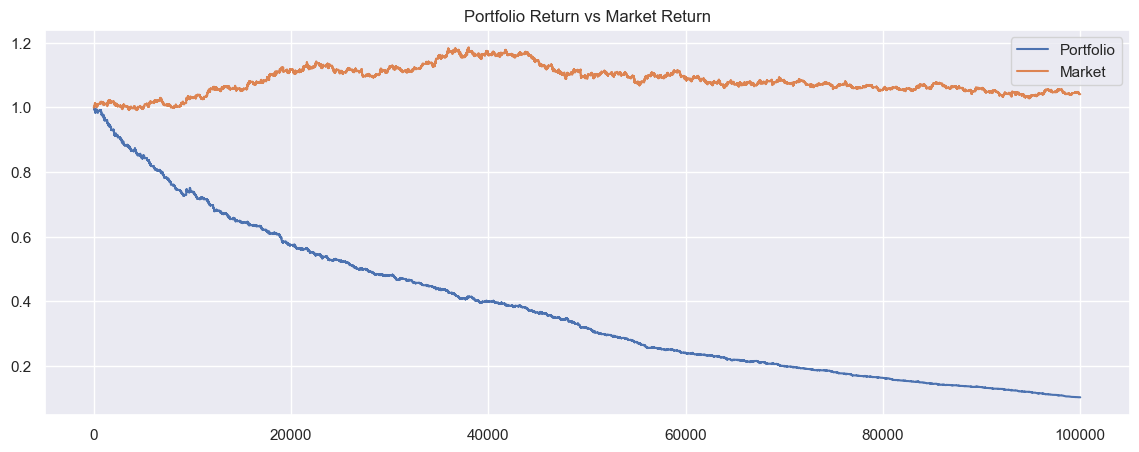

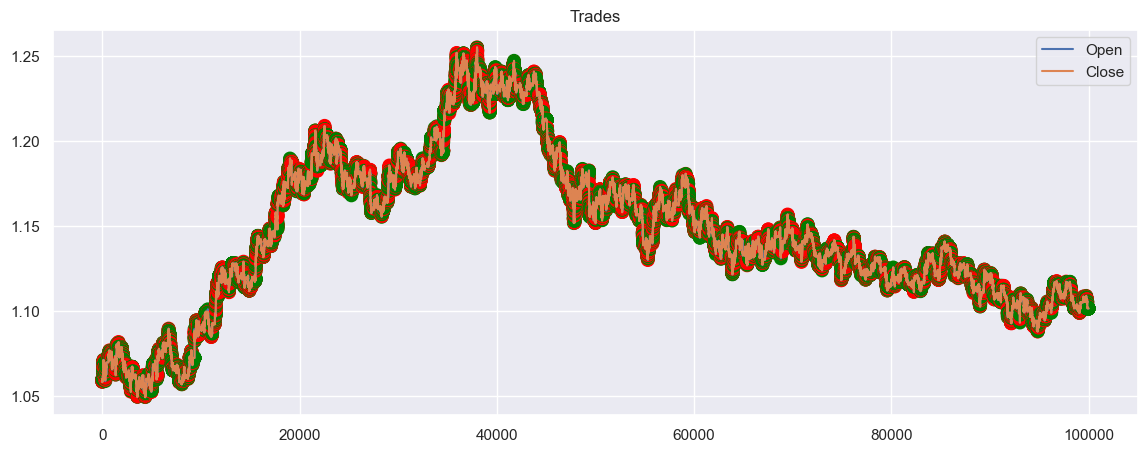

In [94]:
eurusd_env_val.render()

In [95]:
len([fee for fee in eurusd_env_val.get_attr('history')[0]['trading_costs'] if fee != 0])

13212

##### Evaluation set results

In [96]:
eurusd_env_eval = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v2/vecnormalize.pkl',
    make_vec_env(
        ForexEnvBasic,
        env_kwargs=dict(
            target_prices_df=target_prices_eval,
            features_df=basic_features_eval,
            **deepcopy(BASE_ENV_KWARGS)
        )
    )
)

In [97]:
obs = eurusd_env_eval.reset()
for i in tqdm(range(len(target_prices_eval) - 2)):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_eval.step(action)

100%|█████████████████████████████████████████████| 99998/99998 [00:22<00:00, 4383.43it/s]


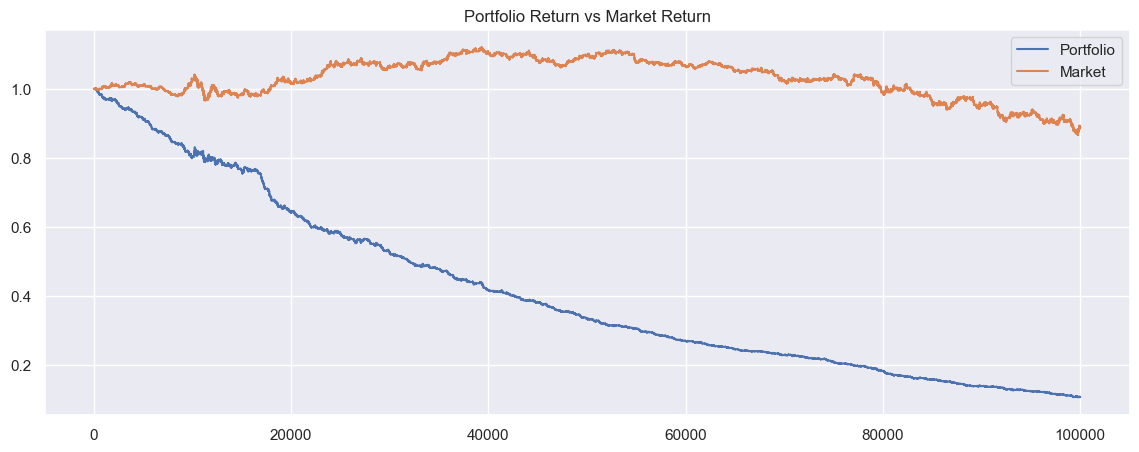

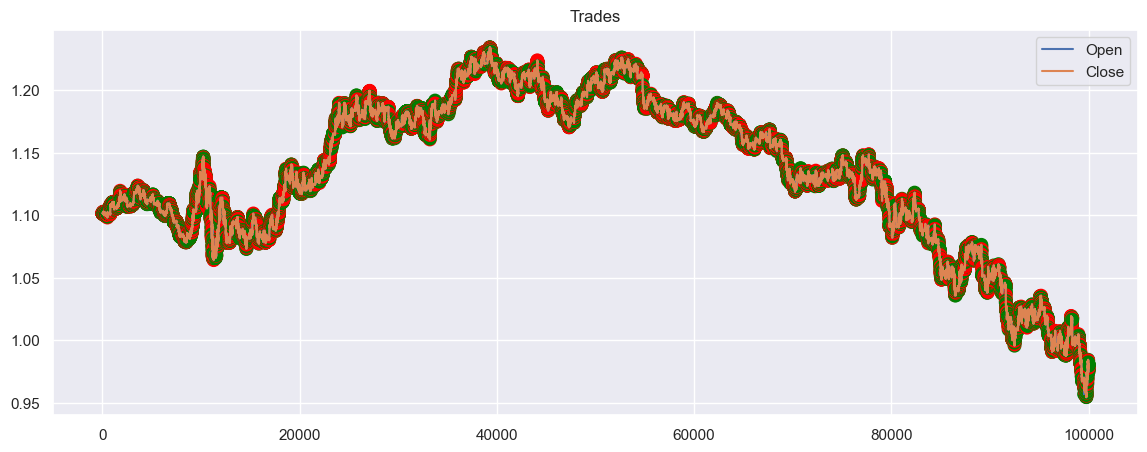

In [98]:
eurusd_env_eval.render()

In [99]:
len([fee for fee in eurusd_env_eval.get_attr('history')[0]['trading_costs'] if fee != 0])

13492

#### Best model

In [100]:
_, best_model_path, log_path = get_model_path(0, f'{LOGS_PATH}/training', 'ppo', 'ForexFullEURUSD-v2', load_best=True)

Loading latest experiment, id=1


In [101]:
best_model_vecnormalize = sorted(
    [filename for filename in os.listdir(f'{log_path}/ForexFullEURUSD-v2') if 'vecnormalize_' in filename], 
    key=lambda x: int(x.split('_')[1])
)[-1]

In [102]:
best_model_vecnormalize

'vecnormalize_800000_steps.pkl'

In [103]:
best_model = PPO.load(best_model_path)

##### Train set results

In [104]:
eurusd_env_trn = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v2/{best_model_vecnormalize}',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=False)
    )
)

In [105]:
obs = eurusd_env_trn.reset()
for i in tqdm(range(len(target_prices_trn) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_trn.step(action)

100%|███████████████████████████████████████████| 492325/492325 [01:52<00:00, 4373.33it/s]


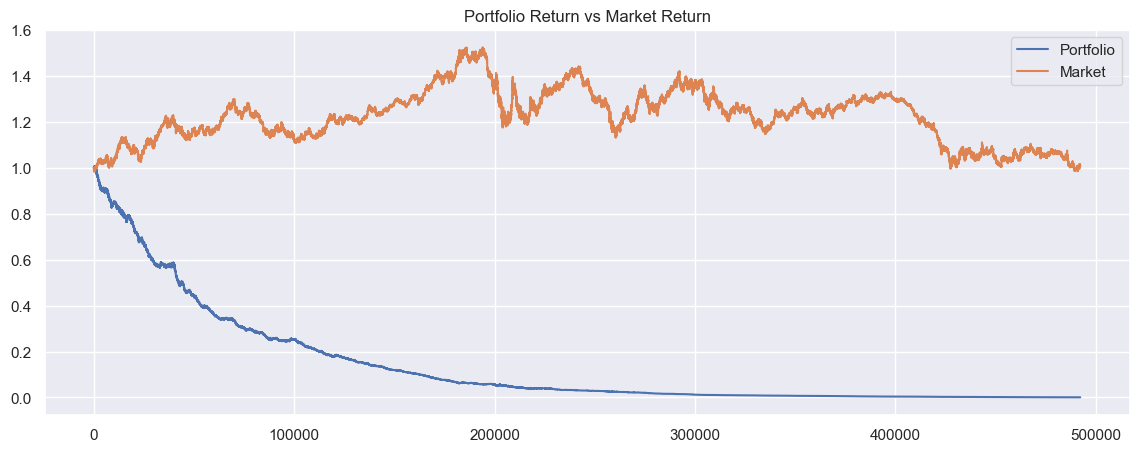

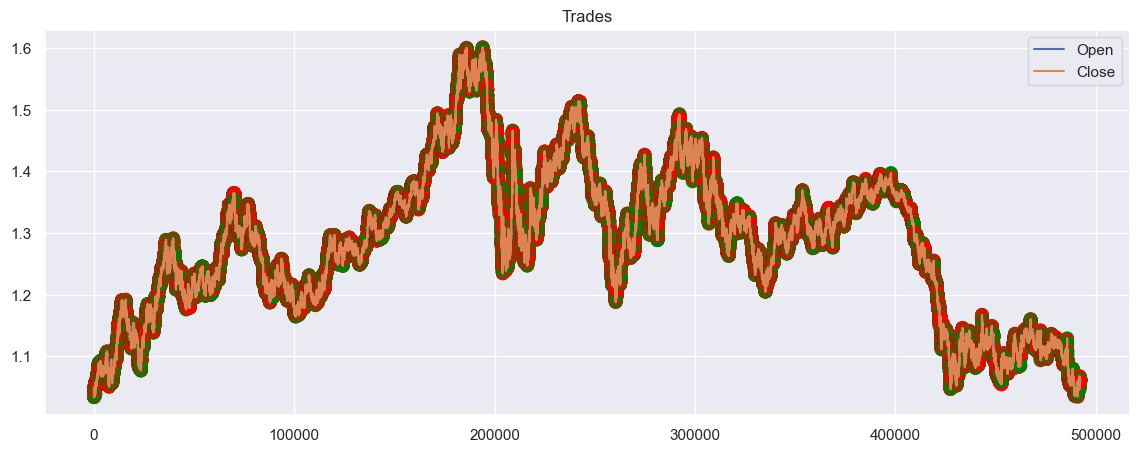

In [106]:
eurusd_env_trn.render()

In [107]:
len([fee for fee in eurusd_env_trn.get_attr('history')[0]['trading_costs'] if fee != 0])

58819

##### Validation set results

In [108]:
eurusd_env_val = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v2/{best_model_vecnormalize}',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=True)
    )
)

In [109]:
obs = eurusd_env_val.reset()
for i in tqdm(range(len(target_prices_val) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_val.step(action)

100%|█████████████████████████████████████████████| 99998/99998 [00:22<00:00, 4462.91it/s]


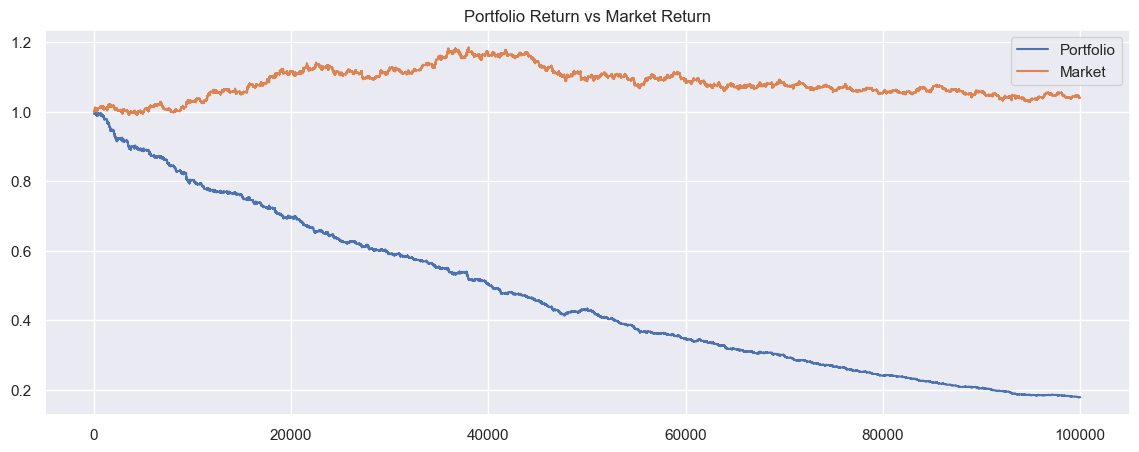

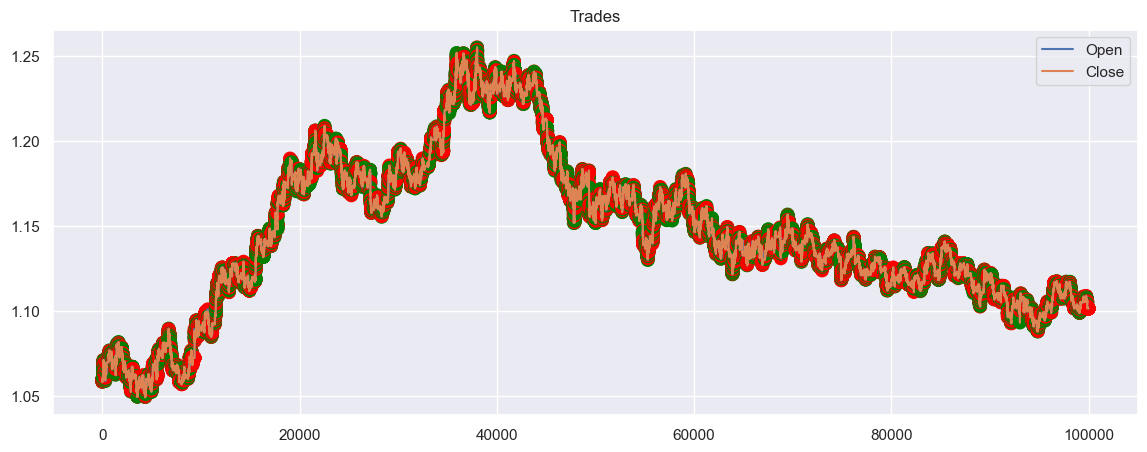

In [110]:
eurusd_env_val.render()

In [111]:
len([fee for fee in eurusd_env_val.get_attr('history')[0]['trading_costs'] if fee != 0])

10077

##### Evaluation set results

In [112]:
eurusd_env_eval = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v2/{best_model_vecnormalize}',
    make_vec_env(
        ForexEnvBasic,
        env_kwargs=dict(
            target_prices_df=target_prices_eval,
            features_df=basic_features_eval,
            **deepcopy(BASE_ENV_KWARGS)
        )
    )
)

In [113]:
obs = eurusd_env_eval.reset()
for i in tqdm(range(len(target_prices_eval) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_eval.step(action)

100%|█████████████████████████████████████████████| 99998/99998 [00:22<00:00, 4538.26it/s]


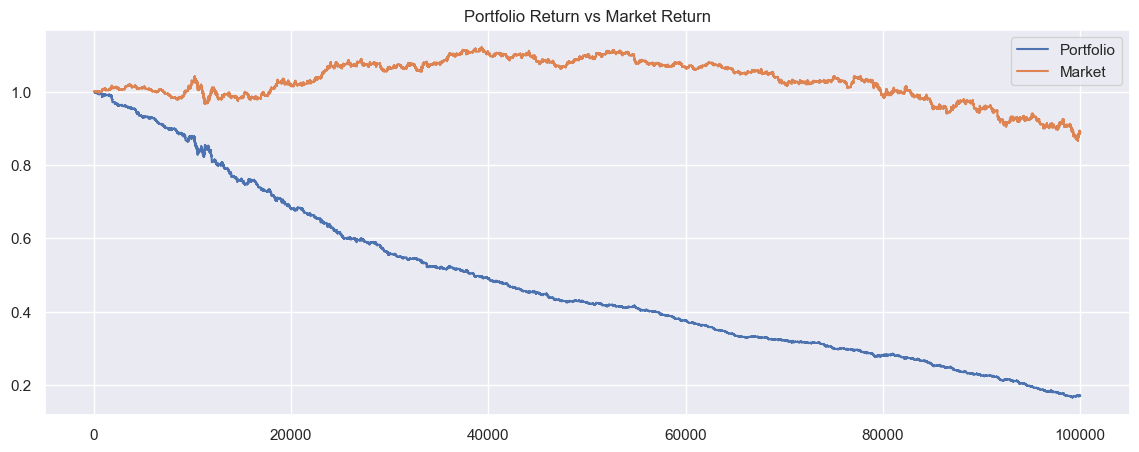

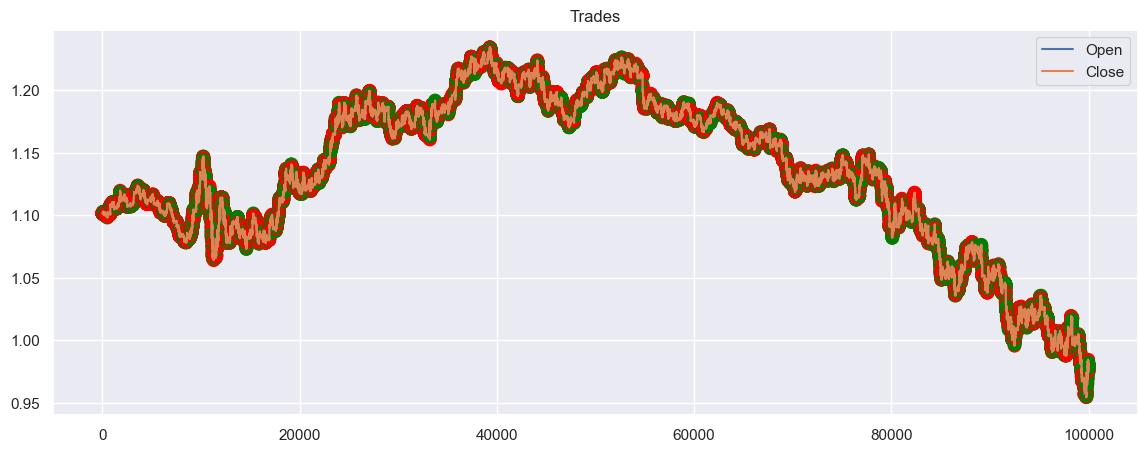

In [114]:
eurusd_env_eval.render()

In [115]:
len([fee for fee in eurusd_env_eval.get_attr('history')[0]['trading_costs'] if fee != 0])

10428

## 2 actions, extended features, running normalization

In [25]:
def create_full_eurusd_env_v3(eval):
    return create_eurusd_env(
        eval,
        target_prices_trn,
        target_prices_val,
        extended_features_trn,
        extended_features_val,
        BASE_ENV_KWARGS
    )

In [26]:
register(
    'ForexFullEURUSD-v3',
    entry_point=create_full_eurusd_env_v3
)

### DQN

In [ ]:
sys.argv = [
    'python', 
    '--algo', 'dqn',
    '--env', 'ForexFullEURUSD-v3',
    '--tensorboard-log', f'{LOGS_PATH}/training/TensorBoard',
    '--n-timesteps', '5000000',
    '--eval-freq', '100000',
    '--eval-episodes', '1',
    '--log-folder', f'{LOGS_PATH}/training',
    '--seed', '604',
    '--verbose', '0',
    '--hyperparams', 'normalize:dict(norm_reward=False)', 'callback:"rl_trading.utils.TextProgressBarCallback"',
    '--conf-file', f'{HYPERPARAMS_PATH}/default/dqn.yml'
]

train()

========== ForexFullEURUSD-v3 ==========
Seed: 604
Loading hyperparameters from: /Users/astepura/Desktop/I-CUREUS/RL-trading/hyperparams/default/dqn.yml
Default hyperparameters for environment (ones being tuned will be overridden):
OrderedDict([('batch_size', 32),
             ('buffer_size', 1000000),
             ('callback', 'rl_trading.utils.TextProgressBarCallback'),
             ('exploration_final_eps', 0.05),
             ('exploration_fraction', 0.1),
             ('gamma', 0.99),
             ('gradient_steps', 1),
             ('learning_rate', 0.0001),
             ('learning_starts', 50000),
             ('normalize', {'norm_reward': False}),
             ('policy', 'MlpPolicy'),
             ('policy_kwargs', 'dict( net_arch=[64, 64] )'),
             ('target_update_interval', 10000),
             ('train_freq', 4)])
Log path: /Users/astepura/Desktop/I-CUREUS/RL-trading/logs/training/dqn/ForexFullEURUSD-v3_2


/Users/astepura/miniforge3/envs/rl/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:229: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 1.90GB > 1.25GB
  warnings.warn(
  2%|▎                | 100148/5000000 [00:53<34:10:50, 39.82it/s]

Eval num_timesteps=100000, episode_reward=-3.05 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


  4%|▋                | 200171/5000000 [01:57<29:21:15, 45.42it/s]

Eval num_timesteps=200000, episode_reward=-1.66 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


  6%|█                | 300165/5000000 [03:03<29:36:20, 44.10it/s]

Eval num_timesteps=300000, episode_reward=-2.12 +/- 0.00
Episode length: 99999.00 +/- 0.00


  8%|█▎               | 400147/5000000 [04:13<30:19:48, 42.13it/s]

Eval num_timesteps=400000, episode_reward=-1.22 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 10%|█▌              | 500001/5000000 [05:33<100:45:14, 12.41it/s]

Eval num_timesteps=500000, episode_reward=-1.75 +/- 0.00
Episode length: 99999.00 +/- 0.00


 12%|██               | 600077/5000000 [07:05<49:50:35, 24.52it/s]

Eval num_timesteps=600000, episode_reward=-2.11 +/- 0.00
Episode length: 99999.00 +/- 0.00


 14%|██▍              | 700057/5000000 [08:30<59:40:25, 20.02it/s]

Eval num_timesteps=700000, episode_reward=-1.16 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 16%|██▋              | 800056/5000000 [10:06<56:37:24, 20.60it/s]

Eval num_timesteps=800000, episode_reward=-1.47 +/- 0.00
Episode length: 99999.00 +/- 0.00


 18%|███              | 900013/5000000 [12:06<79:07:04, 14.39it/s]

Eval num_timesteps=900000, episode_reward=-1.45 +/- 0.00
Episode length: 99999.00 +/- 0.00


 20%|███▏            | 1000001/5000000 [14:05<67:01:36, 16.58it/s]

Eval num_timesteps=1000000, episode_reward=-0.19 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 22%|███▌            | 1100025/5000000 [16:15<72:23:03, 14.97it/s]

Eval num_timesteps=1100000, episode_reward=-1.21 +/- 0.00
Episode length: 99999.00 +/- 0.00


 24%|███▌           | 1200001/5000000 [19:37<102:50:12, 10.26it/s]

Eval num_timesteps=1200000, episode_reward=-0.14 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 26%|████▏           | 1300025/5000000 [22:45<74:14:46, 13.84it/s]

Eval num_timesteps=1300000, episode_reward=-1.07 +/- 0.00
Episode length: 99999.00 +/- 0.00


 28%|████▍           | 1400025/5000000 [25:52<91:40:07, 10.91it/s]

Eval num_timesteps=1400000, episode_reward=-0.29 +/- 0.00
Episode length: 99999.00 +/- 0.00


 30%|████▊           | 1500029/5000000 [28:08<71:17:58, 13.64it/s]

Eval num_timesteps=1500000, episode_reward=-0.39 +/- 0.00
Episode length: 99999.00 +/- 0.00


 32%|█████           | 1600033/5000000 [30:20<70:37:07, 13.37it/s]

Eval num_timesteps=1600000, episode_reward=-0.65 +/- 0.00
Episode length: 99999.00 +/- 0.00


 34%|█████▍          | 1700017/5000000 [32:28<67:44:56, 13.53it/s]

Eval num_timesteps=1700000, episode_reward=-0.23 +/- 0.00
Episode length: 99999.00 +/- 0.00


 36%|█████▊          | 1800025/5000000 [34:43<68:51:38, 12.91it/s]

Eval num_timesteps=1800000, episode_reward=-0.73 +/- 0.00
Episode length: 99999.00 +/- 0.00


 38%|█████▋         | 1900001/5000000 [38:11<116:42:49,  7.38it/s]

Eval num_timesteps=1900000, episode_reward=-0.46 +/- 0.00
Episode length: 99999.00 +/- 0.00


 40%|██████▍         | 2000001/5000000 [41:01<57:17:44, 14.54it/s]

Eval num_timesteps=2000000, episode_reward=0.04 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 42%|██████▋         | 2100000/5000000 [43:33<1:50:00, 439.37it/s]

Eval num_timesteps=2100000, episode_reward=-0.46 +/- 0.00
Episode length: 99999.00 +/- 0.00


 44%|██████▌        | 2200017/5000000 [46:23<103:07:21,  7.54it/s]

Eval num_timesteps=2200000, episode_reward=-0.19 +/- 0.00
Episode length: 99999.00 +/- 0.00


 46%|███████▎        | 2300017/5000000 [49:14<83:09:03,  9.02it/s]

Eval num_timesteps=2300000, episode_reward=0.01 +/- 0.00
Episode length: 99999.00 +/- 0.00


 48%|███████▋        | 2400029/5000000 [51:15<38:05:37, 18.96it/s]

Eval num_timesteps=2400000, episode_reward=-0.26 +/- 0.00
Episode length: 99999.00 +/- 0.00


 50%|████████        | 2500033/5000000 [53:09<43:47:35, 15.86it/s]

Eval num_timesteps=2500000, episode_reward=-0.06 +/- 0.00
Episode length: 99999.00 +/- 0.00


 52%|████████▎       | 2600045/5000000 [54:57<35:34:58, 18.74it/s]

Eval num_timesteps=2600000, episode_reward=-0.43 +/- 0.00
Episode length: 99999.00 +/- 0.00


 54%|████████▋       | 2700025/5000000 [57:51<49:33:35, 12.89it/s]

Eval num_timesteps=2700000, episode_reward=0.02 +/- 0.00
Episode length: 99999.00 +/- 0.00


 56%|███████▎     | 2800001/5000000 [1:00:51<105:22:22,  5.80it/s]

Eval num_timesteps=2800000, episode_reward=-0.04 +/- 0.00
Episode length: 99999.00 +/- 0.00


 57%|███████▉      | 2836645/5000000 [1:01:54<1:55:11, 313.00it/s]

#### Final model

In [27]:
_, model_path, log_path = get_model_path(0, f'{LOGS_PATH}/training', 'dqn', 'ForexFullEURUSD-v3')

Loading latest experiment, id=2


In [28]:
model = DQN.load(model_path)

/Users/astepura/miniforge3/envs/rl/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:229: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 1.90GB > 1.30GB
  warnings.warn(


##### Train set results

In [29]:
eurusd_env_trn = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v3/vecnormalize.pkl',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v3', **kwargs),
        env_kwargs=dict(eval=False)
    )
)

In [30]:
obs = eurusd_env_trn.reset()
for i in tqdm(range(len(target_prices_trn) - 2)):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_trn.step(action)

100%|███████████████████| 492325/492325 [02:10<00:00, 3769.51it/s]


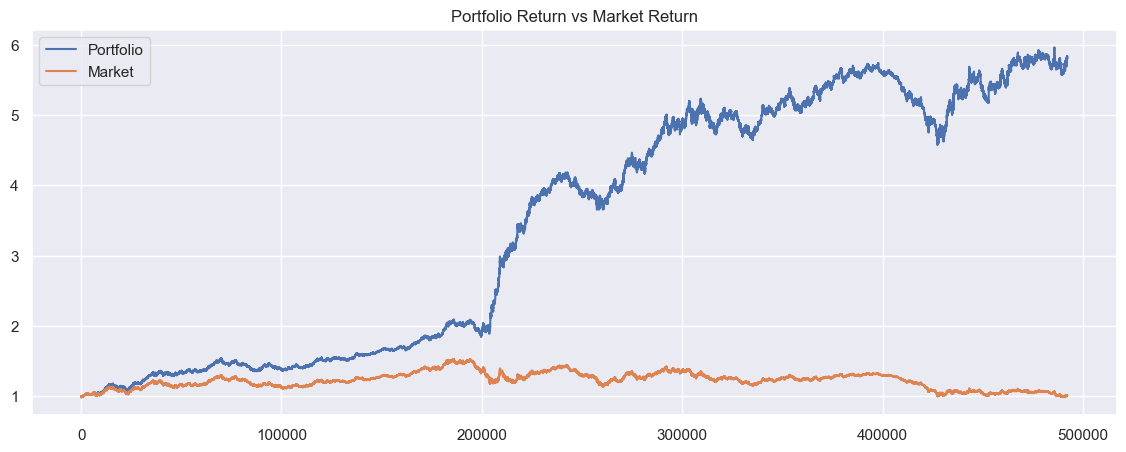

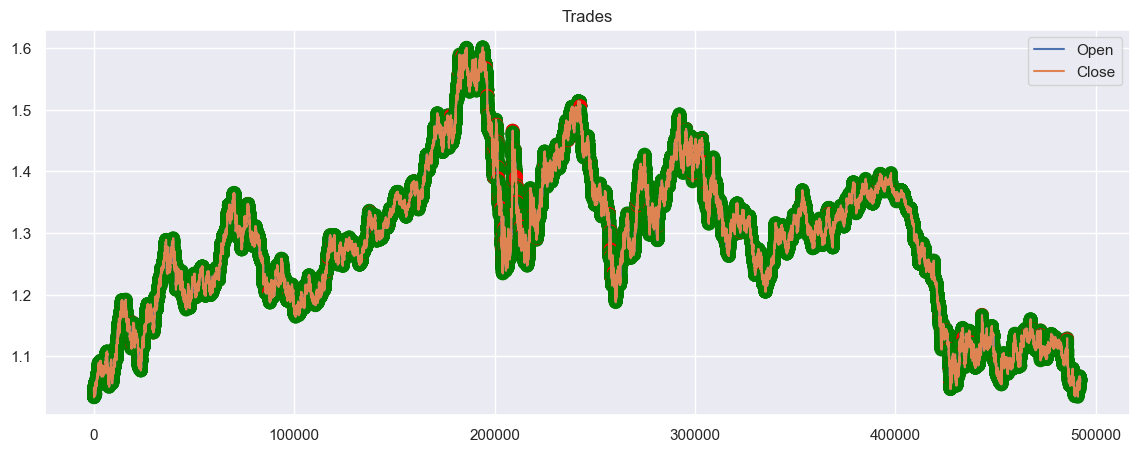

In [31]:
eurusd_env_trn.render()

In [32]:
len([fee for fee in eurusd_env_trn.get_attr('history')[0]['trading_costs'] if fee != 0])

1896

##### Validation set results

In [33]:
eurusd_env_val = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v3/vecnormalize.pkl',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v3', **kwargs),
        env_kwargs=dict(eval=True)
    )
)

In [34]:
obs = eurusd_env_val.reset()
for i in tqdm(range(len(target_prices_val) - 2)):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_val.step(action)

100%|█████████████████████| 99998/99998 [00:28<00:00, 3499.01it/s]


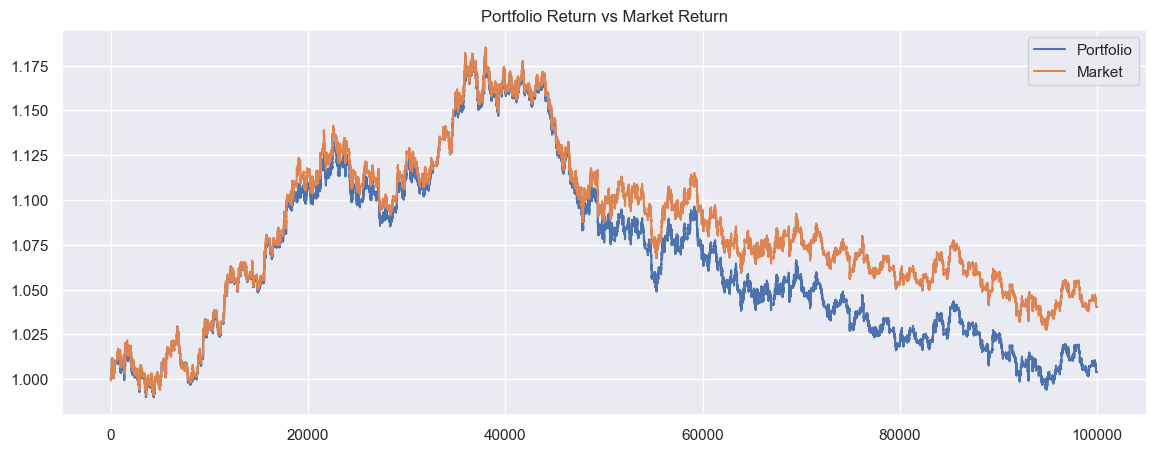

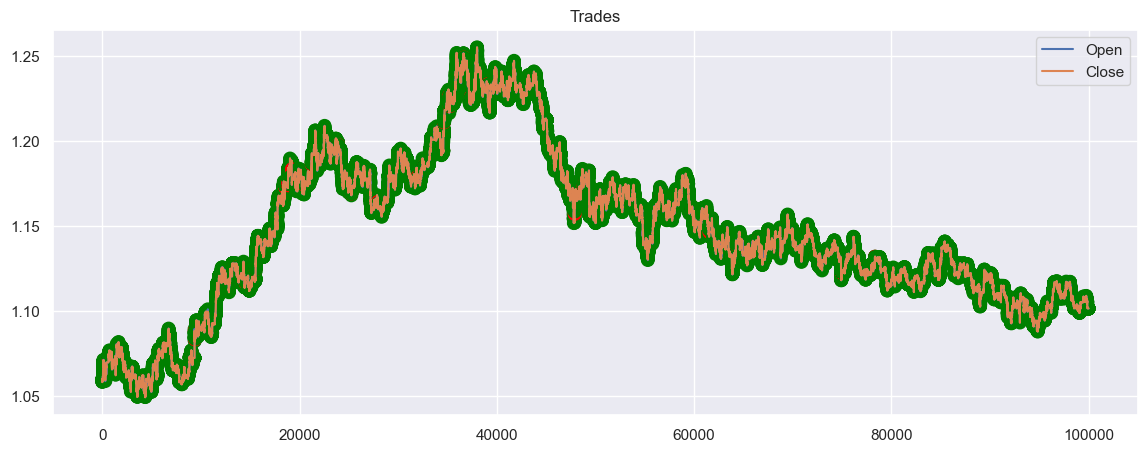

In [35]:
eurusd_env_val.render()

In [36]:
len([fee for fee in eurusd_env_val.get_attr('history')[0]['trading_costs'] if fee != 0])

140

##### Evaluation set results

In [37]:
eurusd_env_eval = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v3/vecnormalize.pkl',
    make_vec_env(
        ForexEnvBasic,
        env_kwargs=dict(
            target_prices_df=target_prices_eval,
            features_df=extended_features_eval,
            **deepcopy(BASE_ENV_KWARGS)
        )
    )
)

In [38]:
obs = eurusd_env_eval.reset()
for i in tqdm(range(len(target_prices_eval) - 2)):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_eval.step(action)

100%|█████████████████████| 99998/99998 [00:25<00:00, 3852.85it/s]


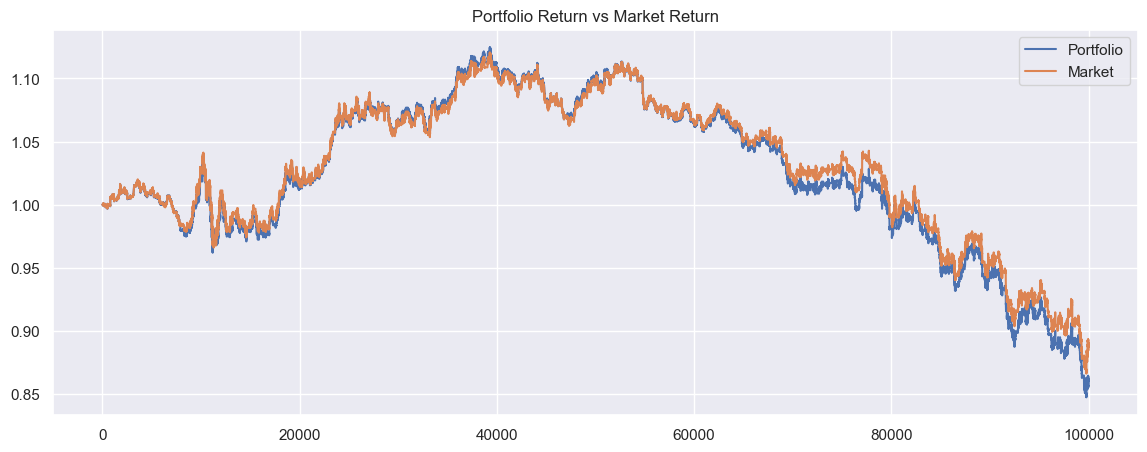

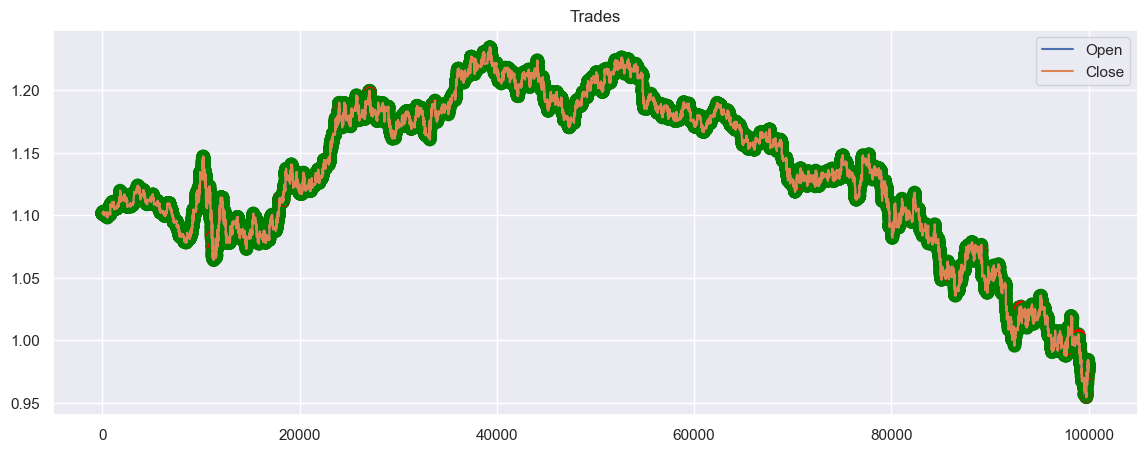

In [39]:
eurusd_env_eval.render()

In [40]:
len([fee for fee in eurusd_env_eval.get_attr('history')[0]['trading_costs'] if fee != 0])

223

#### Best model

In [41]:
_, best_model_path, log_path = get_model_path(0, f'{LOGS_PATH}/training', 'dqn', 'ForexFullEURUSD-v3', load_best=True)

Loading latest experiment, id=2


In [42]:
best_model_vecnormalize = sorted(
    [filename for filename in os.listdir(f'{log_path}/ForexFullEURUSD-v3') if 'vecnormalize_' in filename], 
    key=lambda x: int(x.split('_')[1])
)[-1]

In [43]:
best_model_vecnormalize

'vecnormalize_2900000_steps.pkl'

In [44]:
best_model = DQN.load(best_model_path)

/Users/astepura/miniforge3/envs/rl/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:229: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 1.90GB > 1.27GB
  warnings.warn(


##### Train set results

In [45]:
eurusd_env_trn = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v3/{best_model_vecnormalize}',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v3', **kwargs),
        env_kwargs=dict(eval=False)
    )
)

In [47]:
obs = eurusd_env_trn.reset()
for i in tqdm(range(len(target_prices_trn) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_trn.step(action)

100%|███████████████████| 492325/492325 [02:21<00:00, 3481.76it/s]


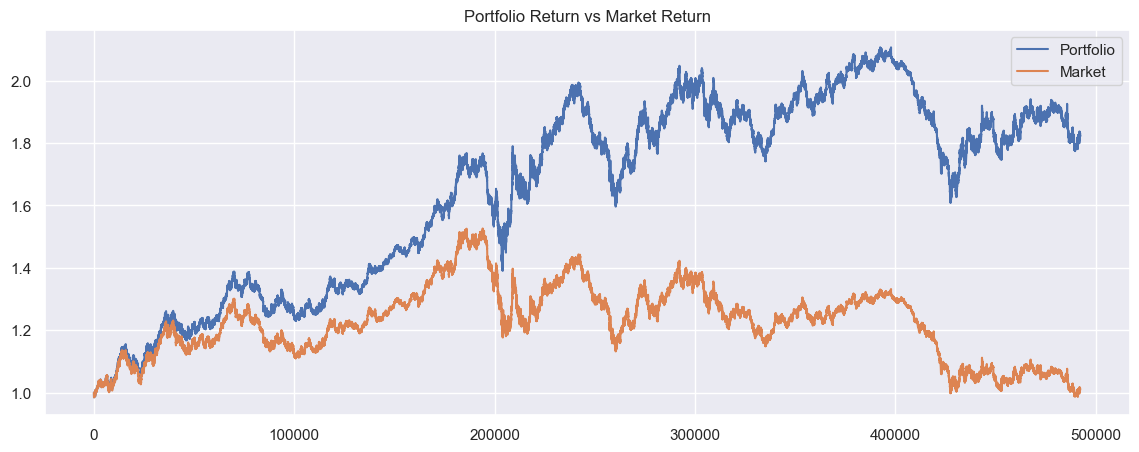

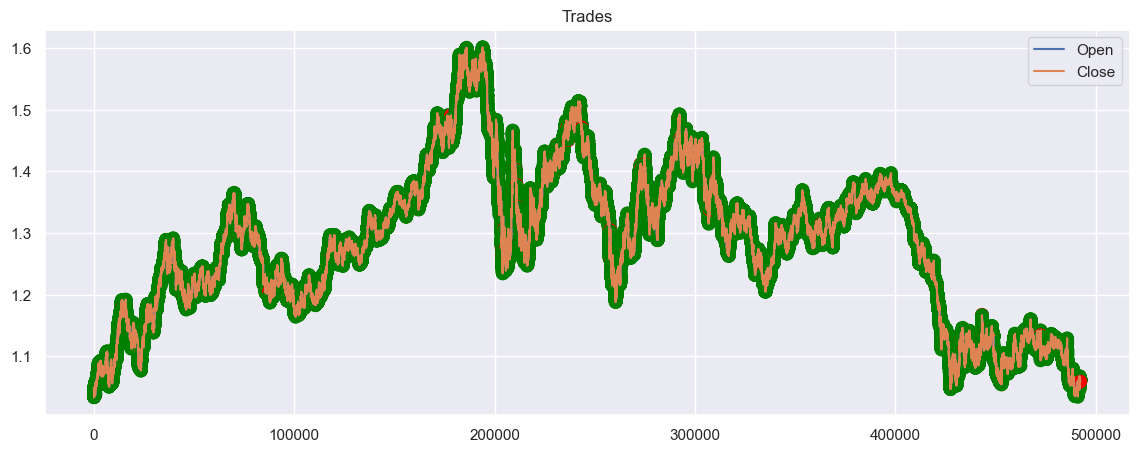

In [48]:
eurusd_env_trn.render()

In [49]:
len([fee for fee in eurusd_env_trn.get_attr('history')[0]['trading_costs'] if fee != 0])

624

##### Validation set results

In [50]:
eurusd_env_val = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v3/{best_model_vecnormalize}',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v3', **kwargs),
        env_kwargs=dict(eval=True)
    )
)

In [51]:
obs = eurusd_env_val.reset()
for i in tqdm(range(len(target_prices_val) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_val.step(action)

100%|█████████████████████| 99998/99998 [00:27<00:00, 3656.73it/s]


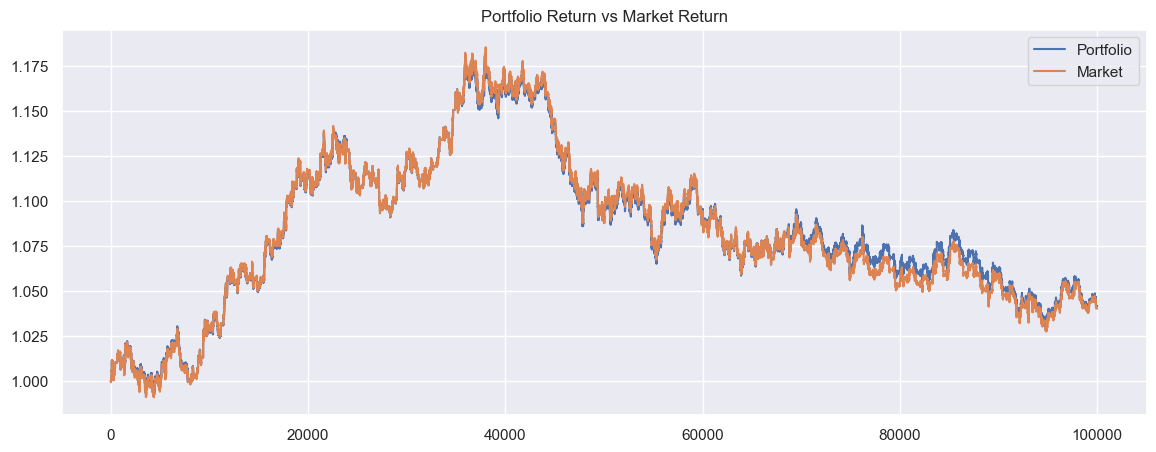

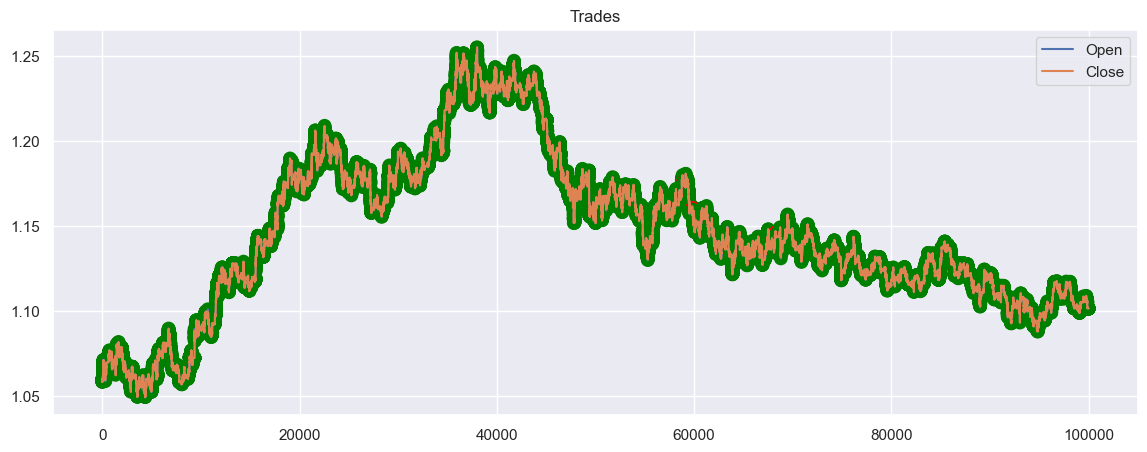

In [52]:
eurusd_env_val.render()

In [53]:
len([fee for fee in eurusd_env_eval.get_attr('history')[0]['trading_costs'] if fee != 0])

223

##### Evaluation set results

In [54]:
eurusd_env_eval = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v3/{best_model_vecnormalize}',
    make_vec_env(
        ForexEnvBasic,
        env_kwargs=dict(
            target_prices_df=target_prices_eval,
            features_df=extended_features_eval,
            **deepcopy(BASE_ENV_KWARGS)
        )
    )
)

In [55]:
obs = eurusd_env_eval.reset()
for i in tqdm(range(len(target_prices_eval) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_eval.step(action)

100%|█████████████████████| 99998/99998 [00:27<00:00, 3669.63it/s]


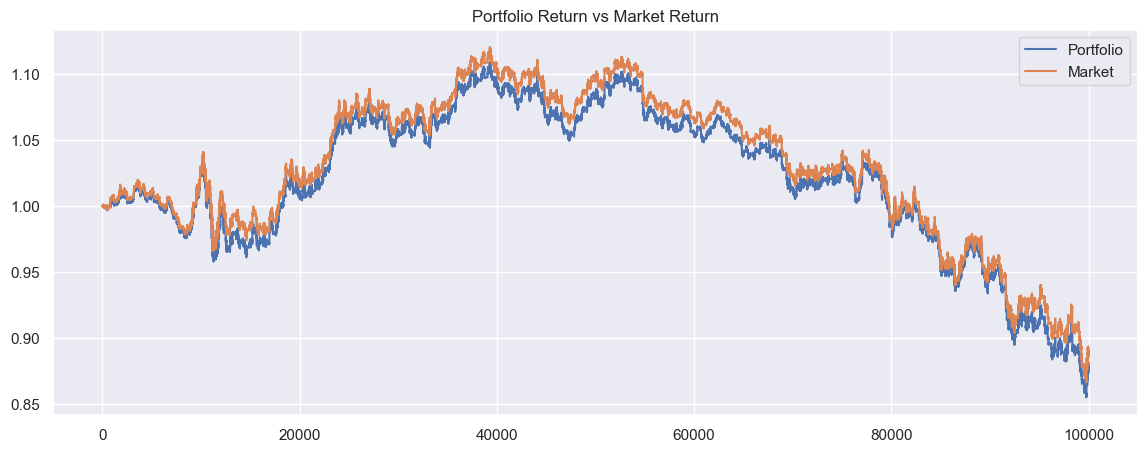

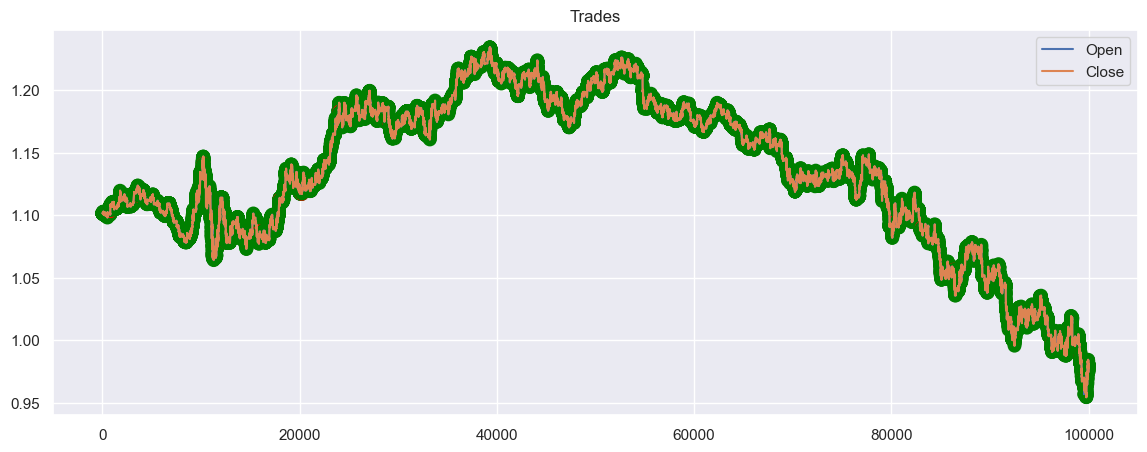

In [56]:
eurusd_env_eval.render()

In [57]:
len([fee for fee in eurusd_env_eval.get_attr('history')[0]['trading_costs'] if fee != 0])

75